## Introduction

The objetcive of this project is to build a data driven model for OD prediction in 4000L fermentor. Calibrated Raman data is used to improve the prediction accuracy based on the Extended Kalman Filter. Previously, EKF has been shown to reduce the RMSE by more than 30% in the demo. The objective of this expereiement is to assess the effectiveness of the Kalman filter in reducing RMSE when compared to the data-driven model with Raman OD measurmenets after 10 hours.

This version 6 is a continuation of version 5 to clean the plot and further develop EKF integration. This version 5 is mainly for Raman integration based on EKF framework.

In [1]:
import numpy as np

## Data Collection

### Retrive Time Series Data (X)

Extract time seires data for the cP 4000L fermentor for all avaialble batches from the SQL server. 

In [2]:
import pandas as pd
file_path = 'B100_cP_4000_L_data_02Aug2024.csv' 
df = pd.read_csv(file_path)

In [3]:
df.head()

Process_Step        SAP EquipmentID                Timestamp  \
0  4000-L Fermenter  NCDCA4426   FER-31131  2022-11-22 10:49:19.000   
1  4000-L Fermenter  NCDCA4426   FER-31131  2022-11-22 10:49:19.000   
2  4000-L Fermenter  NCDCA4426   FER-31131  2022-11-22 10:49:19.000   
3  4000-L Fermenter  NCDCA4426   FER-31131  2022-11-22 10:49:19.000   
4  4000-L Fermenter  NCDCA4426   FER-31131  2022-11-22 10:49:19.000   

   Fermentation  Age                       TagID       Value  \
0          True  0.0            Acid_Tank_Weight  120.889000   
1          True  0.0  Agitator_VFD_Current_Value   45.999996   
2          True  0.0       Airflow_Current_Value  600.000000   
3          True  0.0   Antifoam_Tank_Temperature   43.328940   
4          True  0.0        Antifoam_Tank_Weight   32.430000   

              Last_Updated  
0  2023-11-29 18:00:06.000  
1  2023-11-29 18:00:06.000  
2  2023-11-29 18:00:06.000  
3  2023-11-29 18:00:06.000  
4  2023-11-29 18:00:06.000

#### Drop irrelevant data

In [4]:
df = df.drop(columns=['Process_Step','Timestamp', 'Last_Updated','EquipmentID'])

In [5]:
df.shape

(975440, 5)

In [6]:
df.head()

SAP  Fermentation  Age                       TagID       Value
0  NCDCA4426          True  0.0            Acid_Tank_Weight  120.889000
1  NCDCA4426          True  0.0  Agitator_VFD_Current_Value   45.999996
2  NCDCA4426          True  0.0       Airflow_Current_Value  600.000000
3  NCDCA4426          True  0.0   Antifoam_Tank_Temperature   43.328940
4  NCDCA4426          True  0.0        Antifoam_Tank_Weight   32.430000

In [7]:
df_true = df[df['Fermentation'] == True]
df_true = df_true.drop(columns=['Fermentation'])
df_true['Age'] = df_true['Age'].round(2)


In [8]:
df_true.head(5)

SAP  Age                       TagID       Value
0  NCDCA4426  0.0            Acid_Tank_Weight  120.889000
1  NCDCA4426  0.0  Agitator_VFD_Current_Value   45.999996
2  NCDCA4426  0.0       Airflow_Current_Value  600.000000
3  NCDCA4426  0.0   Antifoam_Tank_Temperature   43.328940
4  NCDCA4426  0.0        Antifoam_Tank_Weight   32.430000

In [9]:
# Check for NaN values in the DataFrame
nan_df_true_summary = df_true.isna().sum()

# Display the count of NaN values per column
print(nan_df_true_summary)


SAP          0
Age          0
TagID        0
Value    13208
dtype: int64


#### Drop all rows with Glutamate in TagID

It is reported that "Glutamate_Concentration" and "Glutamate_Concentration_DMODX" are not reliable measurement.

In [10]:
tags_to_drop = ["Glutamate_Concentration", "Glutamate_Concentration_DMODX"]

# Filter the DataFrame to exclude rows with the specified TagID values
df_true = df_true[~df_true['TagID'].isin(tags_to_drop)]


### Retrive OD (Biomass) Measurement (Y)

#### Import data

In [11]:
import pandas as pd
file_path_Y = 'adjusted_df_Raman_Offline_OD.csv' 
df_Y = pd.read_csv(file_path_Y)

In [12]:
df_Y.head()

Primary ID  BatchID   Age(hr)      Max1      Max2      Max3  \
0            3CA3683-0  3CA3683  0.000000  5.863282  1.483690  0.293164   
1          3CA3683-2.1  3CA3683  2.100000  4.946474  1.499905  0.289281   
2  3CA3683-3.166666667  3CA3683  3.166667  4.920959  1.498602  0.281416   
3  3CA3683-4.266666667  3CA3683  4.266667  5.869157  1.526436  0.276953   
4  3CA3683-5.333333333  3CA3683  5.333333  5.234006  1.529197  0.266563   

       Max4      Max5      Max6  Age (h)  OD- Offline measurement  
0  0.796074  2.927938  1.212130      0.0                    0.492  
1  0.783597  2.861098  1.184933      NaN                      NaN  
2  0.761361  2.834997  1.056845      NaN                      NaN  
3  0.747706  2.735640  1.121744      NaN                      NaN  
4  0.732086  2.755655  0.991809      NaN                      NaN

#### Drop irrelevant columns

In [13]:
df_Y = df_Y.drop(columns=['Max1','Max2','Max3','Max4','Max5','Max6','Primary ID','Age (h)'])

In [14]:
df_Y.head()

BatchID   Age(hr)  OD- Offline measurement
0  3CA3683  0.000000                    0.492
1  3CA3683  2.100000                      NaN
2  3CA3683  3.166667                      NaN
3  3CA3683  4.266667                      NaN
4  3CA3683  5.333333                      NaN

In [15]:
df_Y.shape

(243, 3)

#### Interpolate the missing OD measurements

Interpolate for missing OD values.

In [16]:
df_Y['OD- Offline measurement'] = df_Y['OD- Offline measurement'].interpolate(method='linear')
# Round the 'Age(hr)' column to 2 decimal places
df_Y['Age(hr)'] = df_Y['Age(hr)'].round(2)

In [17]:
# Check for missing values column by column
missing_values_per_column = df_Y.isna().sum()
print("Missing values per column:")
print(missing_values_per_column)

Missing values per column:
BatchID                    0
Age(hr)                    0
OD- Offline measurement    0
dtype: int64


In [18]:
df_Y.head()

BatchID  Age(hr)  OD- Offline measurement
0  3CA3683     0.00                 0.492000
1  3CA3683     2.10                 0.582727
2  3CA3683     3.17                 0.673455
3  3CA3683     4.27                 0.764182
4  3CA3683     5.33                 0.854909

#### Combine the OD measurmenet with other parameters data.

In [19]:
# Reshape df_Y
df_Y_reshaped = df_Y.rename(columns={'BatchID': 'SAP', 'Age(hr)': 'Age', 'OD- Offline measurement': 'Value'})
df_Y_reshaped['TagID'] = 'OD_Offline_measurement'
# df_true_filtered = df_true.merge(unique_combinations, on=['SAP', 'Age'], how='inner')
df_combined = pd.concat([df_true, df_Y_reshaped], ignore_index=False)
df_sorted = df_combined.sort_values(by=['SAP', 'Age'])

In [20]:
df_sorted

SAP    Age                        TagID       Value
91220    3CA3489   0.00             Acid_Tank_Weight  146.370987
91221    3CA3489   0.00   Agitator_VFD_Current_Value   62.018430
91222    3CA3489   0.00        Airflow_Current_Value  153.000000
91223    3CA3489   0.00    Antifoam_Tank_Temperature   29.106360
91224    3CA3489   0.00         Antifoam_Tank_Weight   36.970000
...          ...    ...                          ...         ...
90013  NCDCA5337  48.17       Gas_Analyzer_OUR Ratio         NaN
90016  NCDCA5337  48.17           Jacket_Temperature   34.280518
90017  NCDCA5337  48.17               Oxygen Gas (%)    0.000000
90018  NCDCA5337  48.17     Seal_Pressure_Controller   17.621036
90019  NCDCA5337  48.17  Voltage_Foam_Echo_Amplitude   37.665960

[840339 rows x 4 columns]

In [21]:
# Check for NaN values in the DataFrame
nan_df_sorted = df_sorted.isna().sum()

# Display the count of NaN values per column
print(nan_df_sorted)


SAP          0
Age          0
TagID        0
Value    13208
dtype: int64


#### Modify the Age value of OD to match its closest values in X dataset

In [22]:
def adjust_age(df):
    df = df.copy()  # To avoid modifying the original DataFrame
    df_od = df[df['TagID'] == 'OD_Offline_measurement'].copy()
    
    for idx in df_od.index:
        # Find the position of the current index in the original DataFrame
        pos = df.index.get_loc(idx)

        # Initialize previous and next age values as NaN
        prev_age = np.nan
        next_age = np.nan
        
        # Get the current Age value
        current_age = df.at[idx, 'Age']
        
        # Compute differences
        diff_prev = abs(current_age - prev_age) if not np.isnan(prev_age) else np.nan
        diff_next = abs(current_age - next_age) if not np.isnan(next_age) else np.nan

        # Adjust Age based on smaller difference
        if not np.isnan(diff_prev) and (np.isnan(diff_next) or diff_prev < diff_next):
            df.at[idx, 'Age'] = prev_age
        elif not np.isnan(diff_next):
            df.at[idx, 'Age'] = next_age

    return df

# Apply the adjustment function
df_adjusted = adjust_age(df_sorted)

# Display the adjusted DataFrame
print(df_adjusted)

             SAP    Age                        TagID       Value
91220    3CA3489   0.00             Acid_Tank_Weight  146.370987
91221    3CA3489   0.00   Agitator_VFD_Current_Value   62.018430
91222    3CA3489   0.00        Airflow_Current_Value  153.000000
91223    3CA3489   0.00    Antifoam_Tank_Temperature   29.106360
91224    3CA3489   0.00         Antifoam_Tank_Weight   36.970000
...          ...    ...                          ...         ...
90013  NCDCA5337  48.17       Gas_Analyzer_OUR Ratio         NaN
90016  NCDCA5337  48.17           Jacket_Temperature   34.280518
90017  NCDCA5337  48.17               Oxygen Gas (%)    0.000000
90018  NCDCA5337  48.17     Seal_Pressure_Controller   17.621036
90019  NCDCA5337  48.17  Voltage_Foam_Echo_Amplitude   37.665960

[840339 rows x 4 columns]


#### Drop the rows where OD values are not available

In [23]:
valid_groups = df_adjusted[df_adjusted['TagID'] == 'OD_Offline_measurement'][['SAP', 'Age']].drop_duplicates()

# Step 2: Filter df_adjusted to keep only rows in valid groups
df_sorted = df_adjusted.merge(valid_groups, on=['SAP', 'Age'], how='inner')

# Display the filtered DataFrame
print(df_sorted)

            SAP   Age                        TagID       Value
0       3CA3683   0.0             Acid_Tank_Weight  148.497742
1       3CA3683   0.0   Agitator_VFD_Current_Value   62.040550
2       3CA3683   0.0        Airflow_Current_Value  105.000000
3       3CA3683   0.0    Antifoam_Tank_Temperature   29.664057
4       3CA3683   0.0         Antifoam_Tank_Weight   36.346664
...         ...   ...                          ...         ...
3622  NCDCA5242  48.0           Jacket_Temperature   35.036987
3623  NCDCA5242  48.0               Oxygen Gas (%)    0.000000
3624  NCDCA5242  48.0     Seal_Pressure_Controller   19.256874
3625  NCDCA5242  48.0  Voltage_Foam_Echo_Amplitude   48.337017
3626  NCDCA5242  48.0       OD_Offline_measurement    9.080000

[3627 rows x 4 columns]


In [24]:
df_sorted.head(50)

SAP   Age                        TagID        Value
0   3CA3683  0.00             Acid_Tank_Weight   148.497742
1   3CA3683  0.00   Agitator_VFD_Current_Value    62.040550
2   3CA3683  0.00        Airflow_Current_Value   105.000000
3   3CA3683  0.00    Antifoam_Tank_Temperature    29.664057
4   3CA3683  0.00         Antifoam_Tank_Weight    36.346664
5   3CA3683  0.00    cP_Supplement_Tank_Weight   245.096130
6   3CA3683  0.00             Dissolved_Oxygen    16.872280
7   3CA3683  0.00         Fermentor_pH_Probe_A     7.296911
8   3CA3683  0.00         Fermentor_pH_Probe_B     7.320632
9   3CA3683  0.00      Fermentor_Skid_Pressure     0.196637
10  3CA3683  0.00   Fermentor_Skid_Temperature    35.934555
11  3CA3683  0.00             Fermentor_Weight  2732.191000
12  3CA3683  0.00       Gas_Analyzer_CER Ratio     0.000000
13  3CA3683  0.00       Gas_Analyzer_OUR Ratio     0.289999
14  3CA3683  0.00           Jacket_Temperature    35.143017
15  3CA3683  0.00               Oxygen Gas (%)    20.007372
16  3CA3683  0.00     Seal_Pressure_Controller    15.427862
17  3CA3683  0.00  Voltage_Foam_Echo_Amplitude     5.664873
18  3CA3683  0.00       OD_Offline_measurement     0.492000
19  3CA3683  2.10             Acid_Tank_Weight   148.123810
20  3CA3683  2.10   Agitator_VFD_Current_Value    79.703120
21  3CA3683  2.10        Airflow_Current_Value   107.000000
22  3CA3683  2.10    Antifoam_Tank_Temperature    29.348806
23  3CA3683  2.10         Antifoam_Tank_Weight    35.976666
24  3CA3683  2.10    cP_Supplement_Tank_Weight   244.780273
25  3CA3683  2.10             Dissolved_Oxygen    29.356556
26  3CA3683  2.10         Fermentor_pH_Probe_A     7.096578
27  3CA3683  2.10         Fermentor_pH_Probe_B     7.125509
28  3CA3683  2.10      Fermentor_Skid_Pressure    -0.036075
29  3CA3683  2.10   Fermentor_Skid_Temperature    36.009130
30  3CA3683  2.10             Fermentor_Weight  2732.277340
31  3CA3683  2.10       Gas_Analyzer_CER Ratio     1.350000
32  3CA3683  2.10       Gas_Analyzer_OUR Ratio     2.900000
33  3CA3683  2.10           Jacket_Temperature    34.732360
34  3CA3683  2.10               Oxygen Gas (%)    17.569467
35  3CA3683  2.10     Seal_Pressure_Controller    14.880819
36  3CA3683  2.10  Voltage_Foam_Echo_Amplitude     4.491701
37  3CA3683  2.10       OD_Offline_measurement     0.582727
38  3CA3683  3.17             Acid_Tank_Weight   147.968000
39  3CA3683  3.17   Agitator_VFD_Current_Value    88.020340
40  3CA3683  3.17        Airflow_Current_Value   107.000000
41  3CA3683  3.17    Antifoam_Tank_Temperature    29.205591
42  3CA3683  3.17         Antifoam_Tank_Weight    35.700000
43  3CA3683  3.17    cP_Supplement_Tank_Weight   244.742000
44  3CA3683  3.17             Dissolved_Oxygen    40.540817
45  3CA3683  3.17         Fermentor_pH_Probe_A     7.088159
46  3CA3683  3.17         Fermentor_pH_Probe_B     7.116688
47  3CA3683  3.17      Fermentor_Skid_Pressure    -0.035523
48  3CA3683  3.17   Fermentor_Skid_Temperature    35.956560
49  3CA3683  3.17             Fermentor_Weight  2733.819820

## Model Development

### Prepare Training Data

In [25]:
import pandas as pd

# Pivot the dataframe
df_pivot = df_sorted.pivot_table(index=['SAP', 'Age'], columns='TagID', values='Value').reset_index()

In [26]:
df_pivot

TagID        SAP    Age  Acid_Tank_Weight  Agitator_VFD_Current_Value  \
0        3CA3683   0.00        148.497742                   62.040550   
1        3CA3683   2.10        148.123810                   79.703120   
2        3CA3683   3.17        147.968000                   88.020340   
3        3CA3683   4.27        147.854000                   95.864044   
4        3CA3683   5.33        147.747000                  102.642296   
..           ...    ...               ...                         ...   
238    NCDCA5242  24.00         78.276190                  135.800000   
239    NCDCA5242  33.23         47.588574                  135.800000   
240    NCDCA5242  38.00         30.794000                  135.800000   
241    NCDCA5242  43.47         11.884000                  135.800000   
242    NCDCA5242  48.00         -3.612000                  135.800000   

TagID  Airflow_Current_Value  Antifoam_Tank_Temperature  Antifoam_Tank_Weight  \
0                     105.00                  29.664057             36.346664   
1                     107.00                  29.348806             35.976666   
2                     107.00                  29.205591             35.700000   
3                     108.00                  29.072578             35.373333   
4                     108.00                  28.938305             35.157500   
..                       ...                        ...                   ...   
238                   202.00                  29.258549             25.062271   
239                   313.50                  28.063501             18.070000   
240                   348.40                  27.163866             13.030000   
241                   363.50                  25.627740              4.960000   
242                   367.25                  23.003717             -1.407500   

TagID  Dissolved_Oxygen  Fermentor_Skid_Pressure  Fermentor_Skid_Temperature  \
0             16.872280                 0.196637                   35.934555   
1             29.356556                -0.036075                   36.009130   
2             40.540817                -0.035523                   35.956560   
3             43.950860                -0.034955                   35.851063   
4             43.374990                -0.034403                   35.923523   
..                  ...                      ...                         ...   
238           36.524635                 0.039108                   35.994110   
239           38.910355                 0.130594                   36.004970   
240           42.374744                 0.154679                   35.989296   
241           40.156380                 0.173201                   35.983124   
242           40.814076                 0.178242                   35.995660   

TagID  ...  Fermentor_pH_Probe_A  Fermentor_pH_Probe_B  \
0      ...              7.296911              7.320632   
1      ...              7.096578              7.125509   
2      ...              7.088159              7.116688   
3      ...              7.090473              7.117965   
4      ...              7.099322              7.127253   
..     ...                   ...                   ...   
238    ...              7.197657              7.160179   
239    ...              7.202316              7.156224   
240    ...              7.199340              7.146384   
241    ...              7.199654              7.140380   
242    ...              7.200529              7.137072   

TagID  Gas_Analyzer_CER Ratio  Gas_Analyzer_OUR Ratio  Jacket_Temperature  \
0                    0.000000                0.289999           35.143017   
1                    1.350000                2.900000           34.732360   
2                    1.876364                3.818182           34.668915   
3                    2.365000                4.315907           35.582330   
4                    2.853636                4.931590           36.887375   
..                        ... 

In [27]:
# Extract target variable
#df_target = df_sorted[df_sorted['TagID'] == 'OD_Offline_measurement'][['SAP', 'Age', 'Value']].rename(columns={'Value': 'OD_Offline_measurement'})

# Merge target with features
#df_merged = pd.merge(df_pivot, df_target, on=['SAP', 'Age'], how='inner')

In [28]:
# Extract target variable without renaming
df_target = df_sorted[df_sorted['TagID'] == 'OD_Offline_measurement'][['SAP', 'Age', 'Value']]
#df_merged = df_pivot.drop(columns=['OD_Offline_measurement'])
df_merged = df_pivot

In [29]:
df_merged.fillna(method='ffill', inplace=True)  # Example of forward filling

C:\Users\U1031072\AppData\Local\Temp\ipykernel_41704\2851892773.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True)  # Example of forward filling


In [30]:
df_merged

TagID        SAP    Age  Acid_Tank_Weight  Agitator_VFD_Current_Value  \
0        3CA3683   0.00        148.497742                   62.040550   
1        3CA3683   2.10        148.123810                   79.703120   
2        3CA3683   3.17        147.968000                   88.020340   
3        3CA3683   4.27        147.854000                   95.864044   
4        3CA3683   5.33        147.747000                  102.642296   
..           ...    ...               ...                         ...   
238    NCDCA5242  24.00         78.276190                  135.800000   
239    NCDCA5242  33.23         47.588574                  135.800000   
240    NCDCA5242  38.00         30.794000                  135.800000   
241    NCDCA5242  43.47         11.884000                  135.800000   
242    NCDCA5242  48.00         -3.612000                  135.800000   

TagID  Airflow_Current_Value  Antifoam_Tank_Temperature  Antifoam_Tank_Weight  \
0                     105.00                  29.664057             36.346664   
1                     107.00                  29.348806             35.976666   
2                     107.00                  29.205591             35.700000   
3                     108.00                  29.072578             35.373333   
4                     108.00                  28.938305             35.157500   
..                       ...                        ...                   ...   
238                   202.00                  29.258549             25.062271   
239                   313.50                  28.063501             18.070000   
240                   348.40                  27.163866             13.030000   
241                   363.50                  25.627740              4.960000   
242                   367.25                  23.003717             -1.407500   

TagID  Dissolved_Oxygen  Fermentor_Skid_Pressure  Fermentor_Skid_Temperature  \
0             16.872280                 0.196637                   35.934555   
1             29.356556                -0.036075                   36.009130   
2             40.540817                -0.035523                   35.956560   
3             43.950860                -0.034955                   35.851063   
4             43.374990                -0.034403                   35.923523   
..                  ...                      ...                         ...   
238           36.524635                 0.039108                   35.994110   
239           38.910355                 0.130594                   36.004970   
240           42.374744                 0.154679                   35.989296   
241           40.156380                 0.173201                   35.983124   
242           40.814076                 0.178242                   35.995660   

TagID  ...  Fermentor_pH_Probe_A  Fermentor_pH_Probe_B  \
0      ...              7.296911              7.320632   
1      ...              7.096578              7.125509   
2      ...              7.088159              7.116688   
3      ...              7.090473              7.117965   
4      ...              7.099322              7.127253   
..     ...                   ...                   ...   
238    ...              7.197657              7.160179   
239    ...              7.202316              7.156224   
240    ...              7.199340              7.146384   
241    ...              7.199654              7.140380   
242    ...              7.200529              7.137072   

TagID  Gas_Analyzer_CER Ratio  Gas_Analyzer_OUR Ratio  Jacket_Temperature  \
0                    0.000000                0.289999           35.143017   
1                    1.350000                2.900000           34.732360   
2                    1.876364                3.818182           34.668915   
3                    2.365000                4.315907           35.582330   
4                    2.853636                4.931590           36.887375   
..                        ... 

In [31]:
df_merged.shape

(243, 21)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_columns = [col for col in df_merged.columns if col not in ['SAP', 'Age', 'OD_Offline_measurement']]
df_merged[feature_columns] = scaler.fit_transform(df_merged[feature_columns])

In [33]:
df_merged

TagID        SAP    Age  Acid_Tank_Weight  Agitator_VFD_Current_Value  \
0        3CA3683   0.00          1.193354                   -2.119154   
1        3CA3683   2.10          1.184981                   -1.537068   
2        3CA3683   3.17          1.181492                   -1.262966   
3        3CA3683   4.27          1.178940                   -1.004470   
4        3CA3683   5.33          1.176544                   -0.781086   
..           ...    ...               ...                         ...   
238    NCDCA5242  24.00         -0.378971                    0.311656   
239    NCDCA5242  33.23         -1.066094                    0.311656   
240    NCDCA5242  38.00         -1.442140                    0.311656   
241    NCDCA5242  43.47         -1.865552                    0.311656   
242    NCDCA5242  48.00         -2.212521                    0.311656   

TagID  Airflow_Current_Value  Antifoam_Tank_Temperature  Antifoam_Tank_Weight  \
0                  -1.243157                   0.398832              1.524905   
1                  -1.223754                   0.312831              1.475907   
2                  -1.223754                   0.273761              1.439269   
3                  -1.214052                   0.237475              1.396009   
4                  -1.214052                   0.200845              1.367427   
..                       ...                        ...                   ...   
238                -0.302090                   0.288208              0.030536   
239                 0.779652                  -0.037804             -0.895435   
240                 1.118242                  -0.283227             -1.562872   
241                 1.264738                  -0.702287             -2.631565   
242                 1.301119                  -1.418128             -3.474800   

TagID  Dissolved_Oxygen  Fermentor_Skid_Pressure  Fermentor_Skid_Temperature  \
0             -0.662198                 0.138953                   -0.000238   
1              0.102369                -0.755045                    0.072214   
2              0.787320                -0.752927                    0.021140   
3              0.996159                -0.750743                   -0.081353   
4              0.960892                -0.748625                   -0.010956   
..                  ...                      ...                         ...   
238            0.541360                -0.466218                    0.057621   
239            0.687467                -0.114762                    0.068172   
240            0.899634                -0.022238                    0.052945   
241            0.763776                 0.048917                    0.046948   
242            0.804055                 0.068285                    0.059127   

TagID  ...  Fermentor_pH_Probe_A  Fermentor_pH_Probe_B  \
0      ...              0.914200              1.010933   
1      ...             -1.416856             -0.922032   
2      ...             -1.514818             -1.009416   
3      ...             -1.487893             -0.996766   
4      ...             -1.384927             -0.904759   
..     ...                   ...                   ...   
238    ...             -0.240714             -0.578578   
239    ...             -0.186495             -0.617755   
240    ...             -0.221123             -0.715237   
241    ...             -0.217478             -0.774711   
242    ...             -0.207296             -0.807488   

TagID  Gas_Analyzer_CER Ratio  Gas_Analyzer_OUR Ratio  Jacket_Temperature  \
0                   -1.115593               -1.040564            0.168668   
1                   -0.771727               -0.394295           -0.018851   
2                   -0.637654               -0.166942           -0.047822   
3                   -0.513190               -0.043699            0.369272   
4                   -0.388727                0.108752            0.965196   
..                        ... 

In [34]:
pip install scikit-learn

In [35]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target variable
X_process = df_merged[feature_columns]
y_process = df_merged['OD_Offline_measurement']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_process, y_process, test_size=0.2, random_state=42)

In [36]:
y_process

0      0.492000
1      0.582727
2      0.673455
3      0.764182
4      0.854909
         ...   
238    3.560000
239    4.940000
240    6.320000
241    7.700000
242    9.080000
Name: OD_Offline_measurement, Length: 243, dtype: float64

### 3 Random Forest

Random forest, ensemble method. 
- Ensemble leaening:builds multiple models and combine their predictions to improve overall performance.
- Decision trees:each tree in he forest is trained on random subset of the training data and features.
- Key concepts: 1. bagging (bootstrap aggregating): multiple subset of the trainig data are created by sampling with replacent. 2.feature randomness: for each tree, select a random subset of features for splitting the node. 
- Training process: 1. Bootstrap sampling: create multiple bootstrap samples from the original training set. 2. Tree building: for each bootstrap sample, train a decision tree. 3. aggregation:combine trees predictions. Classification (majority vote); regression: the average of the predictions from all trees. 

Advantages:
- robust to overfitting, especially with large datasets.
- provides estimates of feature importance.
- handling missig values
- classification/regression

Disadvantages:
- require significant memory
- can beocme complex with many trees

In [37]:
X_train

TagID  Acid_Tank_Weight  Agitator_VFD_Current_Value  Airflow_Current_Value  \
115           -0.810667                    0.704592               0.803213   
207           -1.266894                    1.072088               1.457155   
158            0.309680                    0.688274              -0.226902   
132           -0.286500                    0.688251              -0.239029   
84             0.684369                    0.264110              -0.909418   
..                  ...                         ...                    ...   
106            1.207488                   -2.119737              -0.631949   
14             1.026391                    0.195729              -1.082109   
92             1.106869                   -0.130028              -1.184947   
179           -1.173628                    0.706360               1.140232   
102            1.207488                   -2.119737              -0.631949   

TagID  Antifoam_Tank_Temperature  Antifoam_Tank_Weight  Dissolved_Oxygen  \
115                    -0.072224             -0.735198          1.178388   
207                    -1.188255             -1.474808          0.655888   
158                    -0.144703             -0.467693         -0.863536   
132                    -0.337484             -0.025914          0.048608   
84                     -0.379622              0.503003         -0.109686   
..                           ...                   ...               ...   
106                     2.552366              1.187656         -0.867626   
14                     -0.004811              1.012409          0.044781   
92                      0.192694              0.866297         -0.235574   
179                    -0.048382             -0.464162          0.571519   
102                     2.552366              1.187656         -0.867626   

TagID  Fermentor_Skid_Pressure  Fermentor_Skid_Temperature  Fermentor_Weight  \
115                  -0.101613                    0.051292          0.441509   
207                   0.489559                    0.056485          1.226711   
158                  -0.412430                    0.063103         -0.308013   
132                  -0.414731                    0.081622         -0.372884   
84                    0.149708                    0.064837         -0.593130   
..                         ...                         ...               ...   
106                  -0.232268                    0.160744         -0.857192   
14                   -0.698126                   -0.005470         -1.033962   
92                    0.382508                   -0.044278         -0.776919   
179                   0.000641                    0.066450          1.083437   
102                  -0.232268                    0.160744         -0.857192   

TagID  Fermentor_pH_Probe_A  Fermentor_pH_Probe_B  Gas_Analyzer_CER Ratio  \
115               -0.210759              0.454210               -1.115593   
207               -0.204261              1.027046                0.593549   
158                0.144003             -0.181784                0.359211   
132               -0.076020             -0.197203                0.463358   
84                -0.199170             -1.406394               -1.115593   
..                      ...                   ...                     ...   
106                1.245544              1.046824               -1.115593   
14                -0.223193              0.048931                1.131658   
92                -0.257831             -1.203686               -1.115593   
179               -0.205787              0.702880                0.761661   
102                1.245544              1.046824               -1.115593   

TagID  Gas_Analyzer_OUR Ratio  Jacket_Temperature  Oxygen Gas (%)  \
115                 -1.112371            0.017367        0.103066   
207                  0.497110           -0.198873        0.161452   
158                  0.348542            0.088848        

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split the already scaled dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

# Define 7-fold cross-validation
kf = KFold(n_splits=7, shuffle=True, random_state=42)

# Perform cross-validation for MSE and R² on the training data
cv_mse_results = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_mse = -cv_mse_results  # Convert to positive MSE values
cv_r2_results = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='r2')

# Calculate mean and standard deviation for training data
mean_mse = np.mean(cv_mse)
std_mse = np.std(cv_mse)
mean_r2 = np.mean(cv_r2_results)
std_r2 = np.std(cv_r2_results)

# Plot cross-validation results for MSE and R²
plt.figure(figsize=(14, 7))

# Fit the model on the entire training data
rf_model.fit(X_train, y_train)

# Predict on test data
y_test_pred_rf = rf_model.predict(X_test)

# Calculate MSE and R² on the test data
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

# Perform cross-validation on the test data
cv_mse_results_test = cross_val_score(rf_model, X_test, y_test, cv=kf, scoring='neg_mean_squared_error')
cv_mse_test = -cv_mse_results_test
cv_r2_results_test = cross_val_score(rf_model, X_test, y_test, cv=kf, scoring='r2')

# Calculate mean and standard deviation for cross-validation on test data
mean_test_mse_rf = np.mean(cv_mse_test)
std_test_mse_rf = np.std(cv_mse_test)
mean_test_r2_rf = np.mean(cv_r2_results_test)
std_test_r2_rf = np.std(cv_r2_results_test)

# Compile results for Random Forest
rf_results = {
    'Train_MSE_Mean': mean_mse,
    'Train_MSE_SD': std_mse,
    'Train_R2_Mean': mean_r2,
    'Train_R2_SD': std_r2,
    'Test_MSE': mse_test_rf,
    'Test_R2': r2_test_rf,
    'Test_MSE_Mean': mean_test_mse_rf,
    'Test_MSE_SD': std_test_mse_rf,
    'Test_R2_Mean': mean_test_r2_rf,
    'Test_R2_SD': std_test_r2_rf
}

rf_results


{'Train_MSE_Mean': 1.2224104166609806,
 'Train_MSE_SD': 0.3018847492147377,
 'Train_R2_Mean': 0.8749172576772537,
 'Train_R2_SD': 0.036247744225276365,
 'Test_MSE': 1.0890964367705027,
 'Test_R2': 0.8837537209144367,
 'Test_MSE_Mean': 0.8014571460065439,
 'Test_MSE_SD': 0.28249358562441435,
 'Test_R2_Mean': 0.8885313382990468,
 'Test_R2_SD': 0.04638489238020478}

<Figure size 1400x700 with 0 Axes>

In [39]:
import joblib

# Save the model
joblib.dump(rf_model, 'rf_model_processsParameters.pkl')

['rf_model_processsParameters.pkl']

In [40]:
import joblib

# Save the model
joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']

In [41]:
y_test_pred_rf

array([ 3.57731226,  1.0707208 ,  8.69140993,  6.0430035 ,  5.90474255,
        3.07170039,  6.85656092,  5.71554288,  1.11854045,  3.9009632 ,
        2.24284952,  1.25307773,  8.02438967, 10.32834878,  2.36757891,
        9.66362237,  8.83466367,  2.22378395,  5.90988256, 10.55724182,
        2.07576184,  2.22378395,  1.34080467,  7.6704894 ,  2.81841923,
        2.42897218,  1.11854045,  2.55408676,  2.45050465,  0.68214017,
        2.13424785,  7.34728067,  3.57731226,  2.89803587,  2.22378395,
        9.34636565,  3.33360141,  3.2375734 ,  0.558891  ,  8.1465815 ,
        4.24163849,  9.47156298,  3.14042219,  2.22378395,  3.1141151 ,
        5.90988256,  5.54611241,  8.01393128, 10.14693772])

#### Random Forest: Plot for Training Data

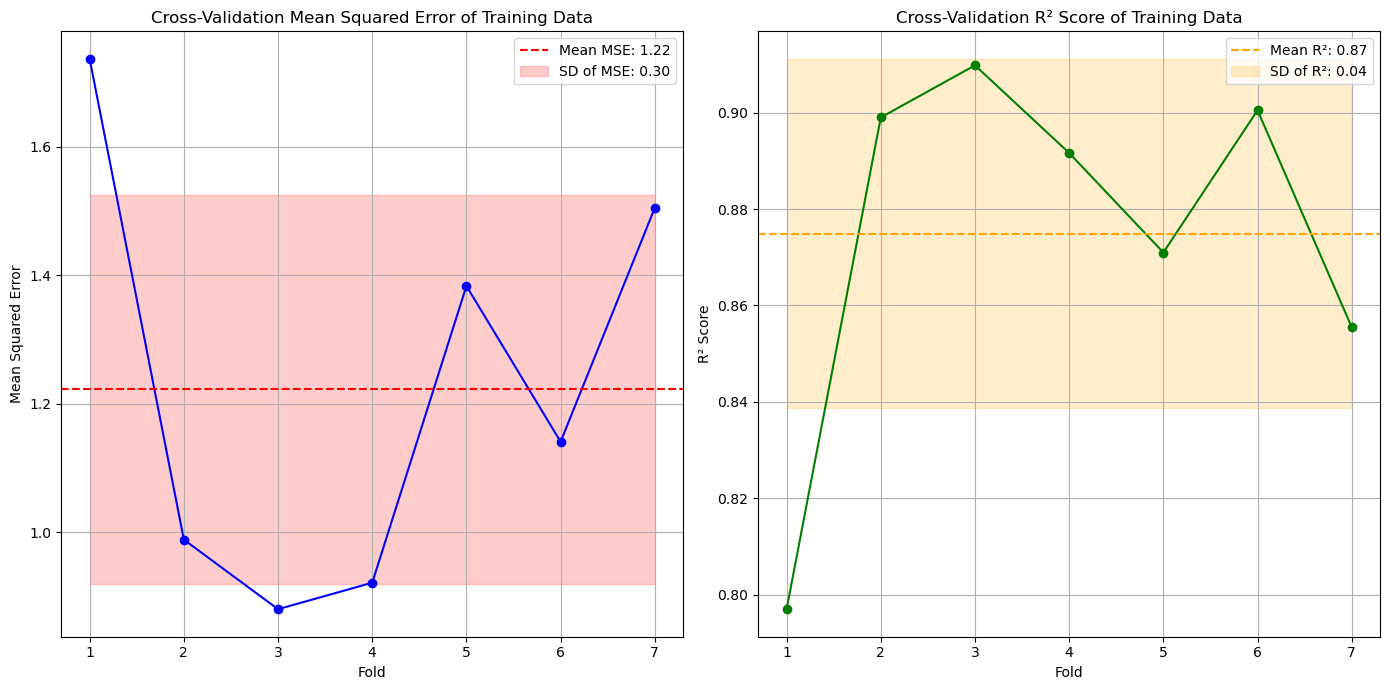

In [42]:
# Plot MSE
# Plot MSE for training data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cv_mse) + 1), cv_mse, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Mean Squared Error of Training Data')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.xticks(range(1, len(cv_mse) + 1))  # Ensure x-ticks correspond to folds
plt.grid(True)
plt.axhline(mean_mse, color='r', linestyle='--', label=f'Mean MSE: {mean_mse:.2f}')
plt.fill_between(range(1, len(cv_mse) + 1), 
                 mean_mse - std_mse, 
                 mean_mse + std_mse, 
                 color='r', alpha=0.2, label=f'SD of MSE: {std_mse:.2f}')
plt.legend()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cv_r2_results) + 1), cv_r2_results, marker='o', linestyle='-', color='g')
plt.title('Cross-Validation R² Score of Training Data')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.xticks(range(1, len(cv_r2_results) + 1))  # Ensure x-ticks correspond to folds
plt.grid(True)
plt.axhline(mean_r2, color='orange', linestyle='--', label=f'Mean R²: {mean_r2:.2f}')
plt.fill_between(range(1, len(cv_r2_results) + 1), 
                 mean_r2 - std_r2, 
                 mean_r2 + std_r2, 
                 color='orange', alpha=0.2, label=f'SD of R²: {std_r2:.2f}')
plt.legend()

plt.tight_layout()
plt.show()


#### Random Forest: Plot for Test Data

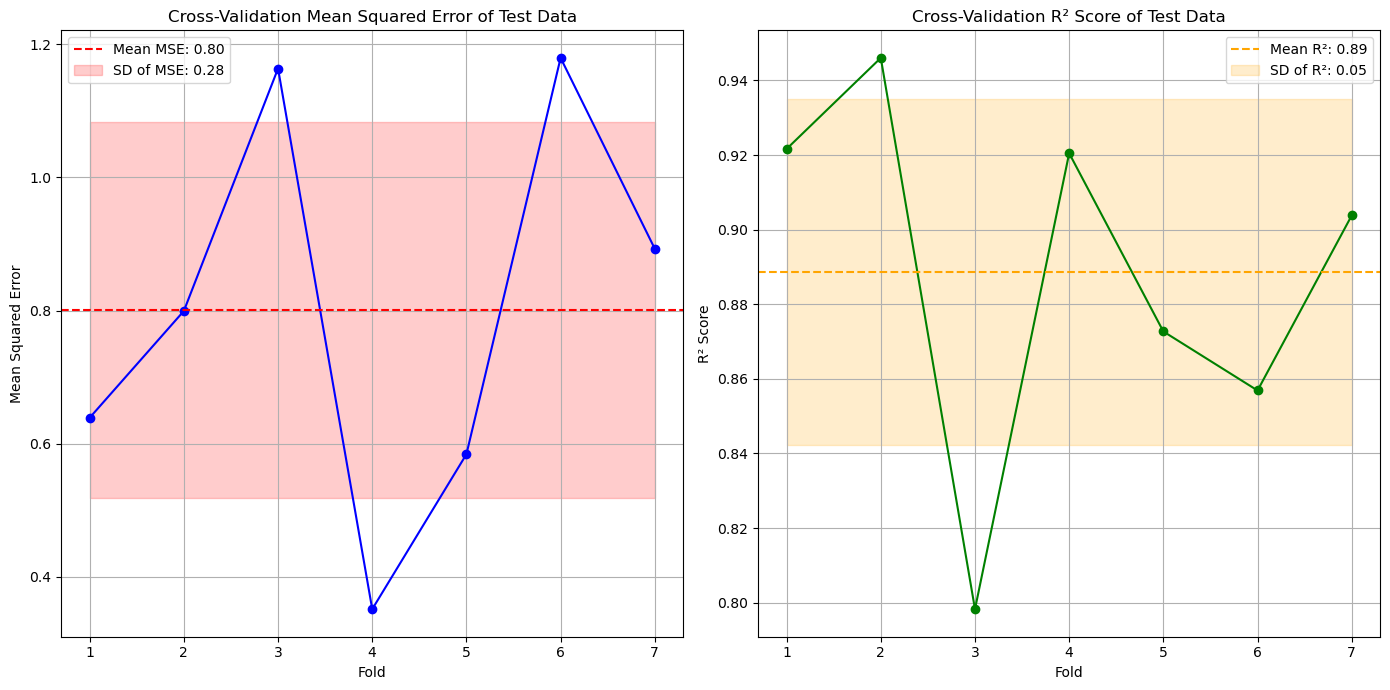

In [43]:
import matplotlib.pyplot as plt

# Plot MSE for test data
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(cv_mse_test) + 1), cv_mse_test, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Mean Squared Error of Test Data')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.xticks(range(1, len(cv_mse_test) + 1))  # Ensure x-ticks correspond to folds
plt.grid(True)
plt.axhline(mean_test_mse_rf, color='r', linestyle='--', label=f'Mean MSE: {mean_test_mse_rf:.2f}')
plt.fill_between(range(1, len(cv_mse_test) + 1), 
                 mean_test_mse_rf - std_test_mse_rf, 
                 mean_test_mse_rf + std_test_mse_rf, 
                 color='r', alpha=0.2, label=f'SD of MSE: {std_test_mse_rf:.2f}')
plt.legend()

# Plot R² for test data
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cv_r2_results_test) + 1), cv_r2_results_test, marker='o', linestyle='-', color='g')
plt.title('Cross-Validation R² Score of Test Data')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.xticks(range(1, len(cv_r2_results_test) + 1))  # Ensure x-ticks correspond to folds
plt.grid(True)
plt.axhline(mean_test_r2_rf, color='orange', linestyle='--', label=f'Mean R²: {mean_test_r2_rf:.2f}')
plt.fill_between(range(1, len(cv_r2_results_test) + 1), 
                 mean_test_r2_rf - std_test_r2_rf, 
                 mean_test_r2_rf + std_test_r2_rf, 
                 color='orange', alpha=0.2, label=f'SD of R²: {std_test_r2_rf:.2f}')
plt.legend()

plt.tight_layout()
plt.show()


## Predict OD using the Random Forest model - remove NaN values

In [44]:
df_true.head(5)

SAP  Age                       TagID       Value
0  NCDCA4426  0.0            Acid_Tank_Weight  120.889000
1  NCDCA4426  0.0  Agitator_VFD_Current_Value   45.999996
2  NCDCA4426  0.0       Airflow_Current_Value  600.000000
3  NCDCA4426  0.0   Antifoam_Tank_Temperature   43.328940
4  NCDCA4426  0.0        Antifoam_Tank_Weight   32.430000

In [45]:
import pandas as pd

# Pivot the dataframe
df_true_pivot = df_true.pivot_table(index=['SAP', 'Age'], columns='TagID', values='Value').reset_index()

Remove rows with any NaN values

In [46]:
# Remove rows with any NaN values
df_true_pivot_clean = df_true_pivot.dropna()

# Check the result
print("Number of rows before dropping NaN values:", len(df_true_pivot))
print("Number of rows after dropping NaN values:", len(df_true_pivot_clean))

Number of rows before dropping NaN values: 46672
Number of rows after dropping NaN values: 40067


In [47]:
df_true_pivot_clean

TagID        SAP    Age  Acid_Tank_Weight  Agitator_VFD_Current_Value  \
0        3CA3489   0.00        146.370987                   62.018430   
1        3CA3489   0.03        146.373215                   62.307884   
2        3CA3489   0.07        146.361000                   62.594276   
3        3CA3489   0.10        146.389038                   62.880634   
4        3CA3489   0.13        146.376251                   63.166912   
...          ...    ...               ...                         ...   
42286  NCDCA2365  46.97         26.384998                  135.797150   
42287  NCDCA2365  47.00         26.221998                  135.797180   
42288  NCDCA2365  47.03         26.109999                  135.797200   
42289  NCDCA2365  47.07         26.040000                  135.797211   
42290  NCDCA2365  47.10         25.872000                  135.797241   

TagID  Airflow_Current_Value  Antifoam_Tank_Temperature  Antifoam_Tank_Weight  \
0                 153.000000                  29.106360             36.970000   
1                 106.500000                  29.106950             36.743336   
2                 106.625000                  29.102137             36.730000   
3                 106.399994                  29.107002             36.728573   
4                 107.000000                  29.100983             36.745937   
...                      ...                        ...                   ...   
42286             333.333344                  24.616438             13.402858   
42287             333.500000                  24.604850             13.416668   
42288             333.500000                  24.599901             13.513333   
42289             333.000000                  24.581696             13.510000   
42290             335.000000                  24.572480             13.455000   

TagID  Dissolved_Oxygen  Fermentor_Skid_Pressure  Fermentor_Skid_Temperature  \
0             63.992100                 0.143882                   36.060425   
1             12.113700                 0.065651                   36.076748   
2              2.086756                 0.065615                   36.083534   
3              8.575014                 0.065579                   36.046360   
4             12.184182                 0.065542                   36.007553   
...                 ...                      ...                         ...   
42286         28.979440                 0.480479                   35.993870   
42287         25.797817                 0.482127                   36.006310   
42288         26.762304                 0.483776                   35.992440   
42289         29.286163                 0.485424                   36.015900   
42290         27.586826                 0.487072                   35.986400   

TagID  Fermentor_Weight  Fermentor_pH_Probe_A  Fermentor_pH_Probe_B  \
0            2761.83984              7.205970              7.192805   
1            2762.30900              7.205966              7.191095   
2            2762.97974              7.201891              7.189330   
3            2762.83984              7.199189              7.187338   
4            2762.85000              7.196096              7.183259   
...                 ...                   ...                   ...   
42286        3068.79980              7.201025              7.219150   
42287        3069.58000              7.199111              7.217204   
42288        3069.14000              7.202305              7.218309   
42289        3069.95000              7.198209              7.217926   
42290        3070.02000              7.200132              7.218206   

TagID  Gas_Analyzer_CER Ratio  Gas_Analyzer_OUR Ratio  Jacket_Temperature  \
0                        0.00                0.433216           35.992490   
1                        0.00                0.433216           36.433960   
2                        0.00                0.219999           35.703674   
3                        0.0

In [48]:
# Check for NaN values in the DataFrame
nan_summary = df_true_pivot_clean.isna().sum()

# Display the count of NaN values per column
print(nan_summary)

TagID
SAP                            0
Age                            0
Acid_Tank_Weight               0
Agitator_VFD_Current_Value     0
Airflow_Current_Value          0
Antifoam_Tank_Temperature      0
Antifoam_Tank_Weight           0
Dissolved_Oxygen               0
Fermentor_Skid_Pressure        0
Fermentor_Skid_Temperature     0
Fermentor_Weight               0
Fermentor_pH_Probe_A           0
Fermentor_pH_Probe_B           0
Gas_Analyzer_CER Ratio         0
Gas_Analyzer_OUR Ratio         0
Jacket_Temperature             0
Oxygen Gas (%)                 0
Seal_Pressure_Controller       0
Voltage_Foam_Echo_Amplitude    0
cP_Supplement_Tank_Weight      0
dtype: int64


Extract and scale the features. The trained Random Forest model was using StandardScaler.

In [49]:
from sklearn.preprocessing import StandardScaler

feature_columns_all = [col for col in df_true_pivot_clean.columns if col not in ['SAP', 'Age']]

# Drop the columns that were not used during training
df_true_pivot_features = df_true_pivot_clean[feature_columns_all]  # feature_columns_all already excludes 'Age' and 'SAP'

# Scale the features
scaler = StandardScaler()
df_true_pivot_features_scaled = scaler.fit_transform(df_true_pivot_features)
df_true_pivot_features_scaled = pd.DataFrame(df_true_pivot_features_scaled, columns=feature_columns_all)
# Predict using the trained model
#predictions = rf_model.predict(df_true_pivot_features_scaled)


In [50]:
df_true_pivot_features_scaled

Acid_Tank_Weight  Agitator_VFD_Current_Value  Airflow_Current_Value  \
0              1.151515                   -2.971734              -0.666176   
1              1.151568                   -2.959059              -1.164549   
2              1.151278                   -2.946518              -1.163210   
3              1.151942                   -2.933979              -1.165621   
4              1.151639                   -2.921444              -1.159191   
...                 ...                         ...                    ...   
40062         -1.690611                    0.258889               1.266586   
40063         -1.694472                    0.258890               1.268372   
40064         -1.697124                    0.258891               1.268372   
40065         -1.698783                    0.258892               1.263013   
40066         -1.702762                    0.258893               1.284449   

       Antifoam_Tank_Temperature  Antifoam_Tank_Weight  Dissolved_Oxygen  \
0                       0.328248              1.848329          2.534552   
1                       0.328435              1.812997         -0.863953   
2                       0.326914              1.810918         -1.520808   
3                       0.328451              1.810696         -1.095769   
4                       0.326549              1.813403         -0.859336   
...                          ...                   ...               ...   
40062                  -1.090701             -1.825305          0.240906   
40063                  -1.094363             -1.823152          0.032481   
40064                  -1.095927             -1.808084          0.095663   
40065                  -1.101680             -1.808604          0.260999   
40066                  -1.104593             -1.817177          0.149677   

       Fermentor_Skid_Pressure  Fermentor_Skid_Temperature  Fermentor_Weight  \
0                    -0.056213                    0.152723         -0.891786   
1                    -0.119530                    0.187117         -0.887038   
2                    -0.119559                    0.201416         -0.880250   
3                    -0.119588                    0.123088         -0.881666   
4                    -0.119618                    0.041321         -0.881563   
...                        ...                         ...               ...   
40062                 0.216211                    0.012490          2.214746   
40063                 0.217545                    0.038702          2.222642   
40064                 0.218879                    0.009477          2.218189   
40065                 0.220213                    0.058908          2.226386   
40066                 0.221547                   -0.003249          2.227095   

       Fermentor_pH_Probe_A  Fermentor_pH_Probe_B  Gas_Analyzer_CER Ratio  \
0                  0.105481              0.054801               -0.939266   
1                  0.105435              0.037485               -0.939266   
2                  0.055837              0.019601               -0.939266   
3                  0.022945             -0.000568               -0.939266   
4                 -0.014700             -0.041880               -0.939266   
...                     ...                   ...                     ...   
40062              0.045286              0.321628                1.301883   
40063              0.021990              0.301923                1.301883   
40064              0.060870              0.313118                1.301883   
40065              0.011021              0.309231                1.301883   
40066              0.034422              0.312071                1.301883   

       Gas_Analyzer_OUR Ratio  Jacket_Temperature  Oxygen Gas (%)  \
0                   -0.853895            0.939419        0.971967   
1                   -0.853895            1.335184        0.930033   
2                   -0.906068            0.680504        0.88810

### Predict OD (NaN dropped)

In [51]:
# Predict using the trained model
predictions = rf_model.predict(df_true_pivot_features_scaled)

In [52]:
predictions

array([ 1.0416488 ,  1.03158584,  0.93412726, ..., 10.14019755,
       10.12307025, 10.12060528])

In [53]:
df_true_pivot_clean.head()

TagID      SAP   Age  Acid_Tank_Weight  Agitator_VFD_Current_Value  \
0      3CA3489  0.00        146.370987                   62.018430   
1      3CA3489  0.03        146.373215                   62.307884   
2      3CA3489  0.07        146.361000                   62.594276   
3      3CA3489  0.10        146.389038                   62.880634   
4      3CA3489  0.13        146.376251                   63.166912   

TagID  Airflow_Current_Value  Antifoam_Tank_Temperature  Antifoam_Tank_Weight  \
0                 153.000000                  29.106360             36.970000   
1                 106.500000                  29.106950             36.743336   
2                 106.625000                  29.102137             36.730000   
3                 106.399994                  29.107002             36.728573   
4                 107.000000                  29.100983             36.745937   

TagID  Dissolved_Oxygen  Fermentor_Skid_Pressure  Fermentor_Skid_Temperature  \
0             63.992100                 0.143882                   36.060425   
1             12.113700                 0.065651                   36.076748   
2              2.086756                 0.065615                   36.083534   
3              8.575014                 0.065579                   36.046360   
4             12.184182                 0.065542                   36.007553   

TagID  Fermentor_Weight  Fermentor_pH_Probe_A  Fermentor_pH_Probe_B  \
0            2761.83984              7.205970              7.192805   
1            2762.30900              7.205966              7.191095   
2            2762.97974              7.201891              7.189330   
3            2762.83984              7.199189              7.187338   
4            2762.85000              7.196096              7.183259   

TagID  Gas_Analyzer_CER Ratio  Gas_Analyzer_OUR Ratio  Jacket_Temperature  \
0                         0.0                0.433216           35.992490   
1                         0.0                0.433216           36.433960   
2                         0.0                0.219999           35.703674   
3                         0.0                0.429186           35.438560   
4                         0.0                0.399185           35.169280   

TagID  Oxygen Gas (%)  Seal_Pressure_Controller  Voltage_Foam_Echo_Amplitude  \
0           20.198816                 19.732876                     6.616014   
1           20.025131                 19.812042                     4.452748   
2           19.851448                 18.743958                     4.528327   
3           19.660587                 16.753440                     4.511223   
4           19.469583                 16.545090                     4.587913   

TagID  cP_Supplement_Tank_Weight  
0                     249.032669  
1                     249.040054  
2                     249.047455  
3                     249.054855  
4                     249.062241

In [54]:
df_true_pivot_features_scaled.head()

Acid_Tank_Weight  Agitator_VFD_Current_Value  Airflow_Current_Value  \
0          1.151515                   -2.971734              -0.666176   
1          1.151568                   -2.959059              -1.164549   
2          1.151278                   -2.946518              -1.163210   
3          1.151942                   -2.933979              -1.165621   
4          1.151639                   -2.921444              -1.159191   

   Antifoam_Tank_Temperature  Antifoam_Tank_Weight  Dissolved_Oxygen  \
0                   0.328248              1.848329          2.534552   
1                   0.328435              1.812997         -0.863953   
2                   0.326914              1.810918         -1.520808   
3                   0.328451              1.810696         -1.095769   
4                   0.326549              1.813403         -0.859336   

   Fermentor_Skid_Pressure  Fermentor_Skid_Temperature  Fermentor_Weight  \
0                -0.056213                    0.152723         -0.891786   
1                -0.119530                    0.187117         -0.887038   
2                -0.119559                    0.201416         -0.880250   
3                -0.119588                    0.123088         -0.881666   
4                -0.119618                    0.041321         -0.881563   

   Fermentor_pH_Probe_A  Fermentor_pH_Probe_B  Gas_Analyzer_CER Ratio  \
0              0.105481              0.054801               -0.939266   
1              0.105435              0.037485               -0.939266   
2              0.055837              0.019601               -0.939266   
3              0.022945             -0.000568               -0.939266   
4             -0.014700             -0.041880               -0.939266   

   Gas_Analyzer_OUR Ratio  Jacket_Temperature  Oxygen Gas (%)  \
0               -0.853895            0.939419        0.971967   
1               -0.853895            1.335184        0.930033   
2               -0.906068            0.680504        0.888100   
3               -0.854881            0.442837        0.842020   
4               -0.862222            0.201435        0.795904   

   Seal_Pressure_Controller  Voltage_Foam_Echo_Amplitude  \
0                  1.462159                    -1.031071   
1                  1.507026                    -1.135565   
2                  0.901692                    -1.131914   
3                 -0.226428                    -1.132740   
4                 -0.344510                    -1.129036   

   cP_Supplement_Tank_Weight  
0                   0.799969  
1                   0.800074  
2                   0.800179  
3                   0.800284  
4                   0.800389

In [55]:
df_true_pivot_features_scaled

Acid_Tank_Weight  Agitator_VFD_Current_Value  Airflow_Current_Value  \
0              1.151515                   -2.971734              -0.666176   
1              1.151568                   -2.959059              -1.164549   
2              1.151278                   -2.946518              -1.163210   
3              1.151942                   -2.933979              -1.165621   
4              1.151639                   -2.921444              -1.159191   
...                 ...                         ...                    ...   
40062         -1.690611                    0.258889               1.266586   
40063         -1.694472                    0.258890               1.268372   
40064         -1.697124                    0.258891               1.268372   
40065         -1.698783                    0.258892               1.263013   
40066         -1.702762                    0.258893               1.284449   

       Antifoam_Tank_Temperature  Antifoam_Tank_Weight  Dissolved_Oxygen  \
0                       0.328248              1.848329          2.534552   
1                       0.328435              1.812997         -0.863953   
2                       0.326914              1.810918         -1.520808   
3                       0.328451              1.810696         -1.095769   
4                       0.326549              1.813403         -0.859336   
...                          ...                   ...               ...   
40062                  -1.090701             -1.825305          0.240906   
40063                  -1.094363             -1.823152          0.032481   
40064                  -1.095927             -1.808084          0.095663   
40065                  -1.101680             -1.808604          0.260999   
40066                  -1.104593             -1.817177          0.149677   

       Fermentor_Skid_Pressure  Fermentor_Skid_Temperature  Fermentor_Weight  \
0                    -0.056213                    0.152723         -0.891786   
1                    -0.119530                    0.187117         -0.887038   
2                    -0.119559                    0.201416         -0.880250   
3                    -0.119588                    0.123088         -0.881666   
4                    -0.119618                    0.041321         -0.881563   
...                        ...                         ...               ...   
40062                 0.216211                    0.012490          2.214746   
40063                 0.217545                    0.038702          2.222642   
40064                 0.218879                    0.009477          2.218189   
40065                 0.220213                    0.058908          2.226386   
40066                 0.221547                   -0.003249          2.227095   

       Fermentor_pH_Probe_A  Fermentor_pH_Probe_B  Gas_Analyzer_CER Ratio  \
0                  0.105481              0.054801               -0.939266   
1                  0.105435              0.037485               -0.939266   
2                  0.055837              0.019601               -0.939266   
3                  0.022945             -0.000568               -0.939266   
4                 -0.014700             -0.041880               -0.939266   
...                     ...                   ...                     ...   
40062              0.045286              0.321628                1.301883   
40063              0.021990              0.301923                1.301883   
40064              0.060870              0.313118                1.301883   
40065              0.011021              0.309231                1.301883   
40066              0.034422              0.312071                1.301883   

       Gas_Analyzer_OUR Ratio  Jacket_Temperature  Oxygen Gas (%)  \
0                   -0.853895            0.939419        0.971967   
1                   -0.853895            1.335184        0.930033   
2                   -0.906068            0.680504        0.88810

### Plot the result (NaN dropped)

#### Plot the predicted result

C:\Users\U1031072\AppData\Local\Temp\ipykernel_41704\4004303932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_pivot_clean['Predictions'] = predictions


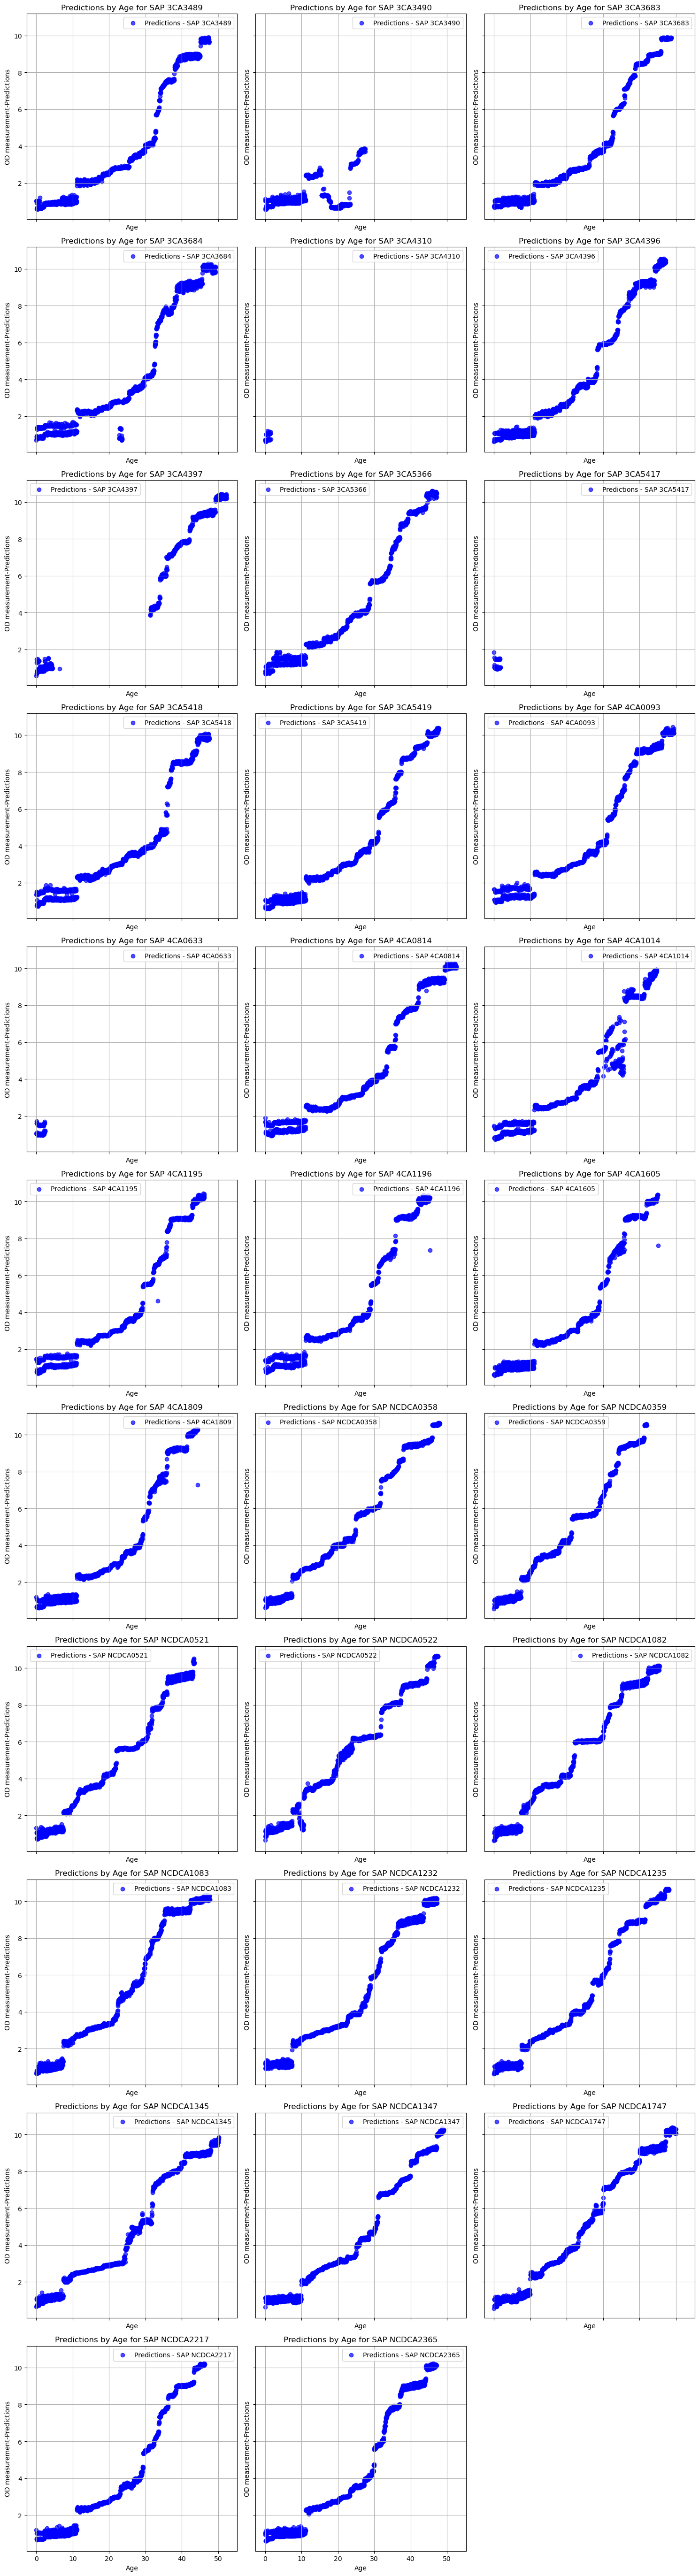

In [56]:
# Assuming 'df_true_pivot_clean' and 'df_true_pivot_features_scaled' have the same index or rows correspond 1:1

# Attach the predictions to the dataframe
df_true_pivot_clean['Predictions'] = predictions

# Now you can proceed with your plotting code
import matplotlib.pyplot as plt
import numpy as np

# Get unique batches
batches = df_true_pivot_clean['SAP'].unique()

# Define number of columns
num_cols = 3
num_batches = len(batches)
num_rows = int(np.ceil(num_batches / num_cols))  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)

# Flatten the axes array for easy iteration if there's more than one row
axes = axes.flatten()

# Plot data for each batch
for i, batch in enumerate(batches):
    # Filter data for the current batch
    batch_data = df_true_pivot_clean[df_true_pivot_clean['SAP'] == batch]
    
    # Plot predictions by Age for the current batch
    axes[i].scatter(batch_data['Age'], batch_data['Predictions'], alpha=0.7, color='blue', label=f'Predictions - SAP {batch}')
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('OD measurement-Predictions')
    axes[i].set_title(f'Predictions by Age for SAP {batch}')
    axes[i].legend()
    axes[i].grid(True)

# Turn off unused subplots
for j in range(len(batches), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [57]:
batch_data

TagID        SAP    Age  Acid_Tank_Weight  Agitator_VFD_Current_Value  \
40877  NCDCA2365   0.00        140.715000                   56.785885   
40878  NCDCA2365   0.03        140.752000                   62.210056   
40879  NCDCA2365   0.07        140.789000                   62.496445   
40880  NCDCA2365   0.10        140.803986                   62.780420   
40881  NCDCA2365   0.13        140.802719                   63.069103   
...          ...    ...               ...                         ...   
42286  NCDCA2365  46.97         26.384998                  135.797150   
42287  NCDCA2365  47.00         26.221998                  135.797180   
42288  NCDCA2365  47.03         26.109999                  135.797200   
42289  NCDCA2365  47.07         26.040000                  135.797211   
42290  NCDCA2365  47.10         25.872000                  135.797241   

TagID  Airflow_Current_Value  Antifoam_Tank_Temperature  Antifoam_Tank_Weight  \
40877             295.333344                  35.327057             32.720000   
40878             109.000000                  35.303825             32.060000   
40879             105.999992                  35.279633             32.160000   
40880             106.500000                  35.262790             32.184998   
40881             106.285706                  35.239380             32.240000   
...                      ...                        ...                   ...   
42286             333.333344                  24.616438             13.402858   
42287             333.500000                  24.604850             13.416668   
42288             333.500000                  24.599901             13.513333   
42289             333.000000                  24.581696             13.510000   
42290             335.000000                  24.572480             13.455000   

TagID  Dissolved_Oxygen  Fermentor_Skid_Pressure  Fermentor_Skid_Temperature  \
40877         -0.052959                 0.198231                   36.084175   
40878         15.337918                 0.199717                   36.158424   
40879          6.147085                 0.199100                   36.144650   
40880          1.967773                 0.198483                   36.049843   
40881          1.331219                 0.197866                   35.989117   
...                 ...                      ...                         ...   
42286         28.979440                 0.480479                   35.993870   
42287         25.797817                 0.482127                   36.006310   
42288         26.762304                 0.483776                   35.992440   
42289         29.286163                 0.485424                   36.015900   
42290         27.586826                 0.487072                   35.986400   

TagID  ...  Fermentor_pH_Probe_A  Fermentor_pH_Probe_B  \
40877  ...              7.218395              7.256680   
40878  ...              7.215407              7.254269   
40879  ...              7.212153              7.253208   
40880  ...              7.210090              7.250667   
40881  ...              7.208116              7.247120   
...    ...                   ...                   ...   
42286  ...              7.201025              7.219150   
42287  ...              7.199111              7.217204   
42288  ...              7.202305              7.218309   
42289  ...              7.198209              7.217926   
42290  ...              7.200132              7.218206   

TagID  Gas_Analyzer_CER Ratio  Gas_Analyzer_OUR Ratio  Jacket_Temperature  \
40877                0.000000                0.199999           37.447205   
40878                0.000000                0.457674           36.563140   
40879                0.000000                0.734419           34.578796   
40880                0.000000                0.734419           34.906770   
40881                0.069195                1.275290           34.250794   
...                       ... 

#### Plot the predicted result with measured OD data

Overlay the result with the measured OD data.

In [58]:
import pandas as pd
#file_path_Y = 'adjusted_df_Raman_Offline_OD.csv' 
df_Raman_v2 = pd.read_csv(file_path_Y)
# Drop rows with any NaN values
df_Raman_v2_clean = df_Raman_v2.dropna()

C:\Users\U1031072\AppData\Local\anaconda3_v1\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\U1031072\AppData\Local\anaconda3_v1\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


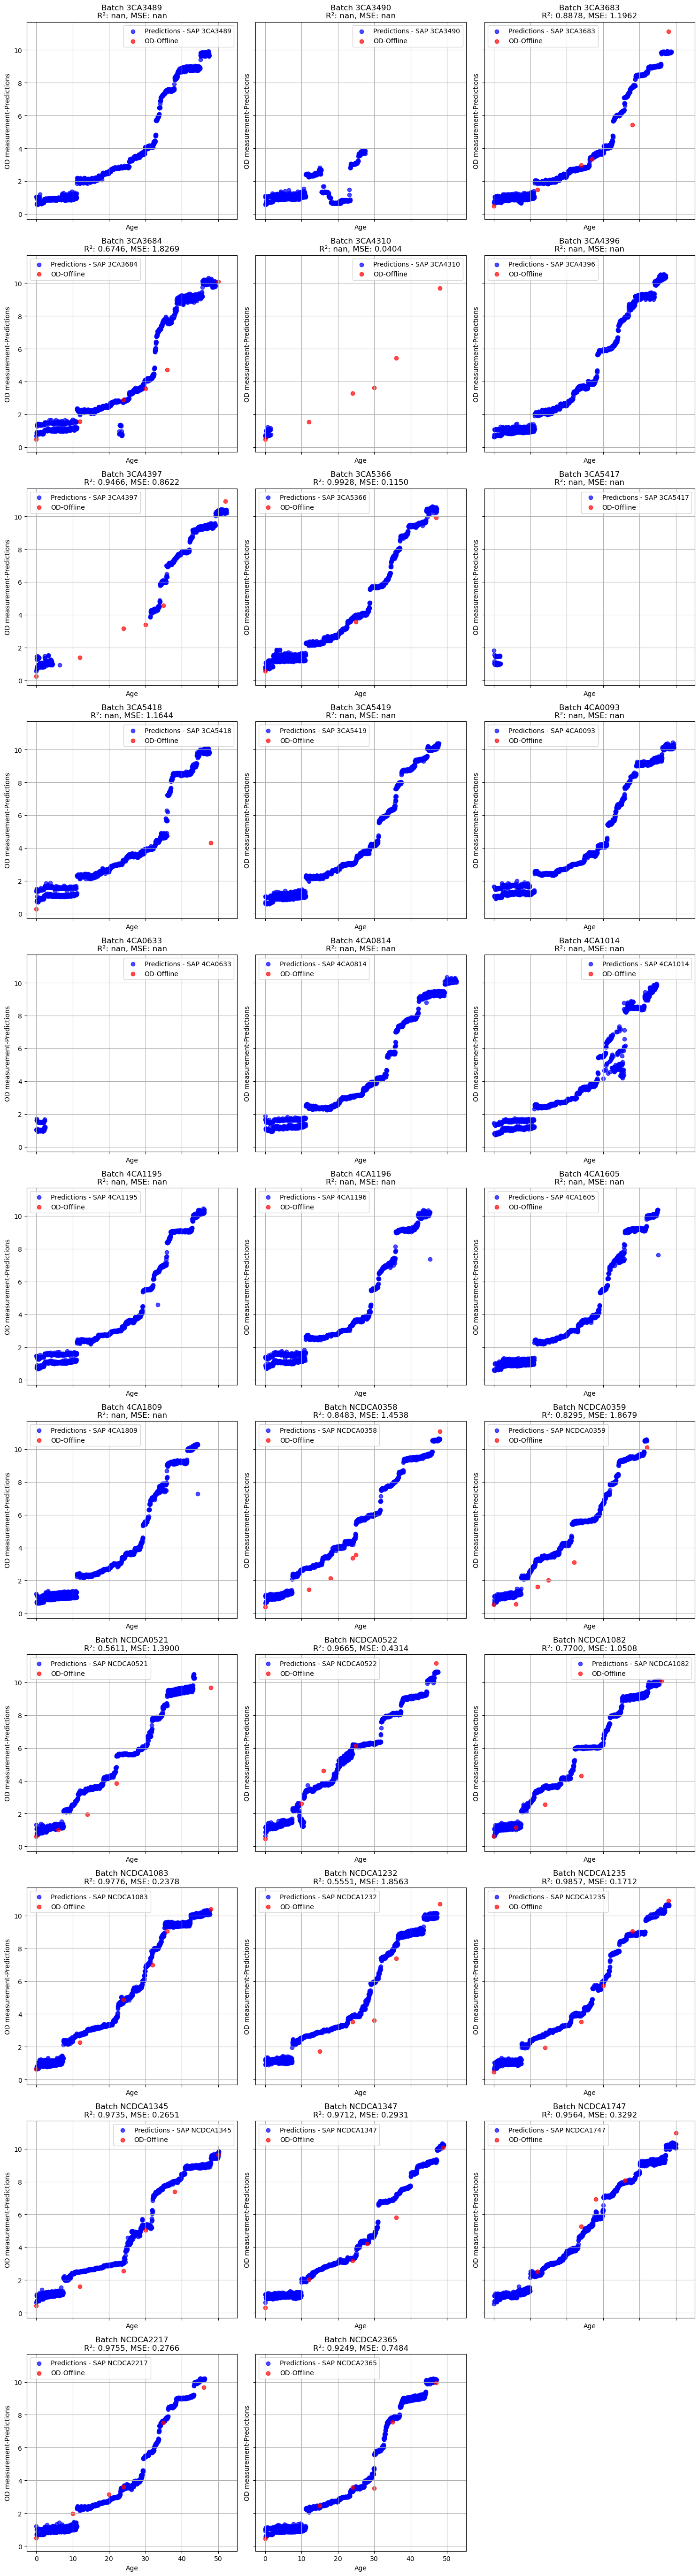

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Get unique batches from df_true_pivot_clean
batches = df_true_pivot_clean['SAP'].unique()

# Define number of columns
num_cols = 3
num_batches = len(batches)
num_rows = int(np.ceil(num_batches / num_cols))  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)

# Flatten the axes array for easy iteration if there's more than one row
axes = axes.flatten()

# Plot data and calculate R² and MSE for each batch
for i, batch in enumerate(batches):
    # Filter data for the current batch
    batch_data = df_true_pivot_clean[df_true_pivot_clean['SAP'] == batch]
    raman_data = df_Raman_v2_clean[df_Raman_v2_clean['BatchID'] == batch]

    # Ensure the data is aligned by Age
    merged_data = pd.merge(batch_data, raman_data, left_on='Age', right_on='Age(hr)', suffixes=('_pred', '_obs'))

    if not merged_data.empty:
        # Calculate R² and MSE between Predictions and OD-Offline measurement
        r2 = r2_score(merged_data['Predictions'], merged_data['OD- Offline measurement'])
        mse = mean_squared_error(merged_data['Predictions'], merged_data['OD- Offline measurement'])
    else:
        r2 = float('nan')
        mse = float('nan')

    # Plot predictions by Age for the current batch
    axes[i].scatter(batch_data['Age'], batch_data['Predictions'], alpha=0.7, color='blue', label=f'Predictions - SAP {batch}')
    
    # Overlay OD-Offline measurement from df_Raman_v2_clean
    axes[i].scatter(raman_data['Age(hr)'], raman_data['OD- Offline measurement'], alpha=0.7, color='red', label='OD-Offline')
    
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('OD measurement-Predictions')
    axes[i].set_title(f'Batch {batch}\nR²: {r2:.4f}, MSE: {mse:.4f}')
    axes[i].legend()
    axes[i].grid(True)

# Turn off unused subplots
for j in range(len(batches), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


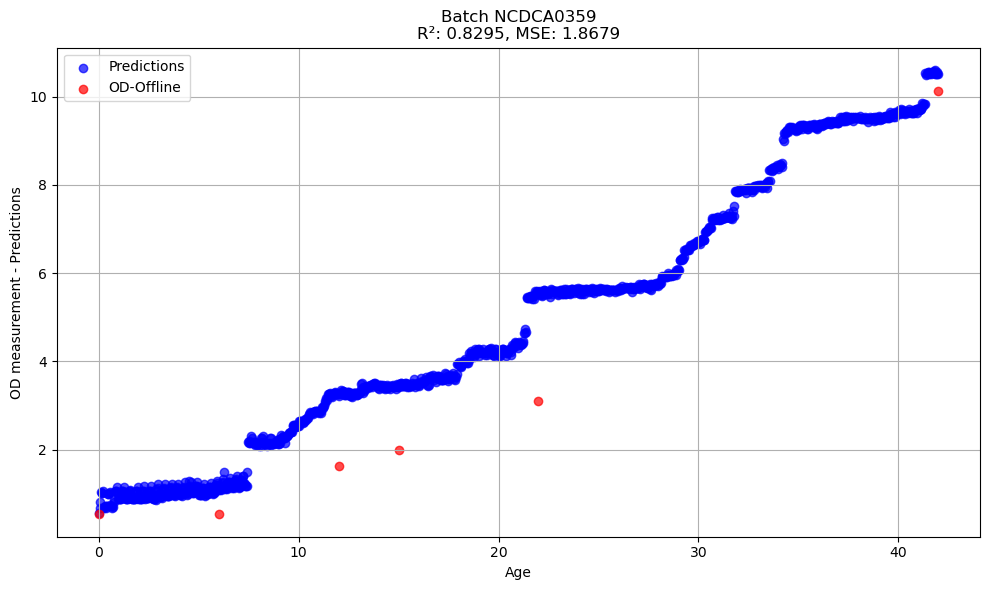

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

# Define the specific batch to plot
target_batch = 'NCDCA0359'

# Filter data for the specific batch
batch_data = df_true_pivot_clean[df_true_pivot_clean['SAP'] == target_batch]
raman_data = df_Raman_v2_clean[df_Raman_v2_clean['BatchID'] == target_batch]

# Ensure the data is aligned by Age
merged_data = pd.merge(batch_data, raman_data, left_on='Age', right_on='Age(hr)', suffixes=('_pred', '_obs'))

# Calculate R² and MSE if merged data is not empty
if not merged_data.empty:
    r2 = r2_score(merged_data['Predictions'], merged_data['OD- Offline measurement'])
    mse = mean_squared_error(merged_data['Predictions'], merged_data['OD- Offline measurement'])
else:
    r2 = float('nan')
    mse = float('nan')

# Create a single plot
plt.figure(figsize=(10, 6))

# Plot predictions by Age for the specific batch
plt.scatter(batch_data['Age'], batch_data['Predictions'], alpha=0.7, color='blue', label='Predictions')

# Overlay OD-Offline measurement from raman_data
plt.scatter(raman_data['Age(hr)'], raman_data['OD- Offline measurement'], alpha=0.7, color='red', label='OD-Offline')

# Add titles and labels
plt.xlabel('Age')
plt.ylabel('OD measurement - Predictions')
plt.title(f'Batch {target_batch}\nR²: {r2:.4f}, MSE: {mse:.4f}')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


#### Plot the predicted result by batchs with measured OD (only for batahces where OD is available)

C:\Users\U1031072\AppData\Local\anaconda3_v1\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\U1031072\AppData\Local\anaconda3_v1\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


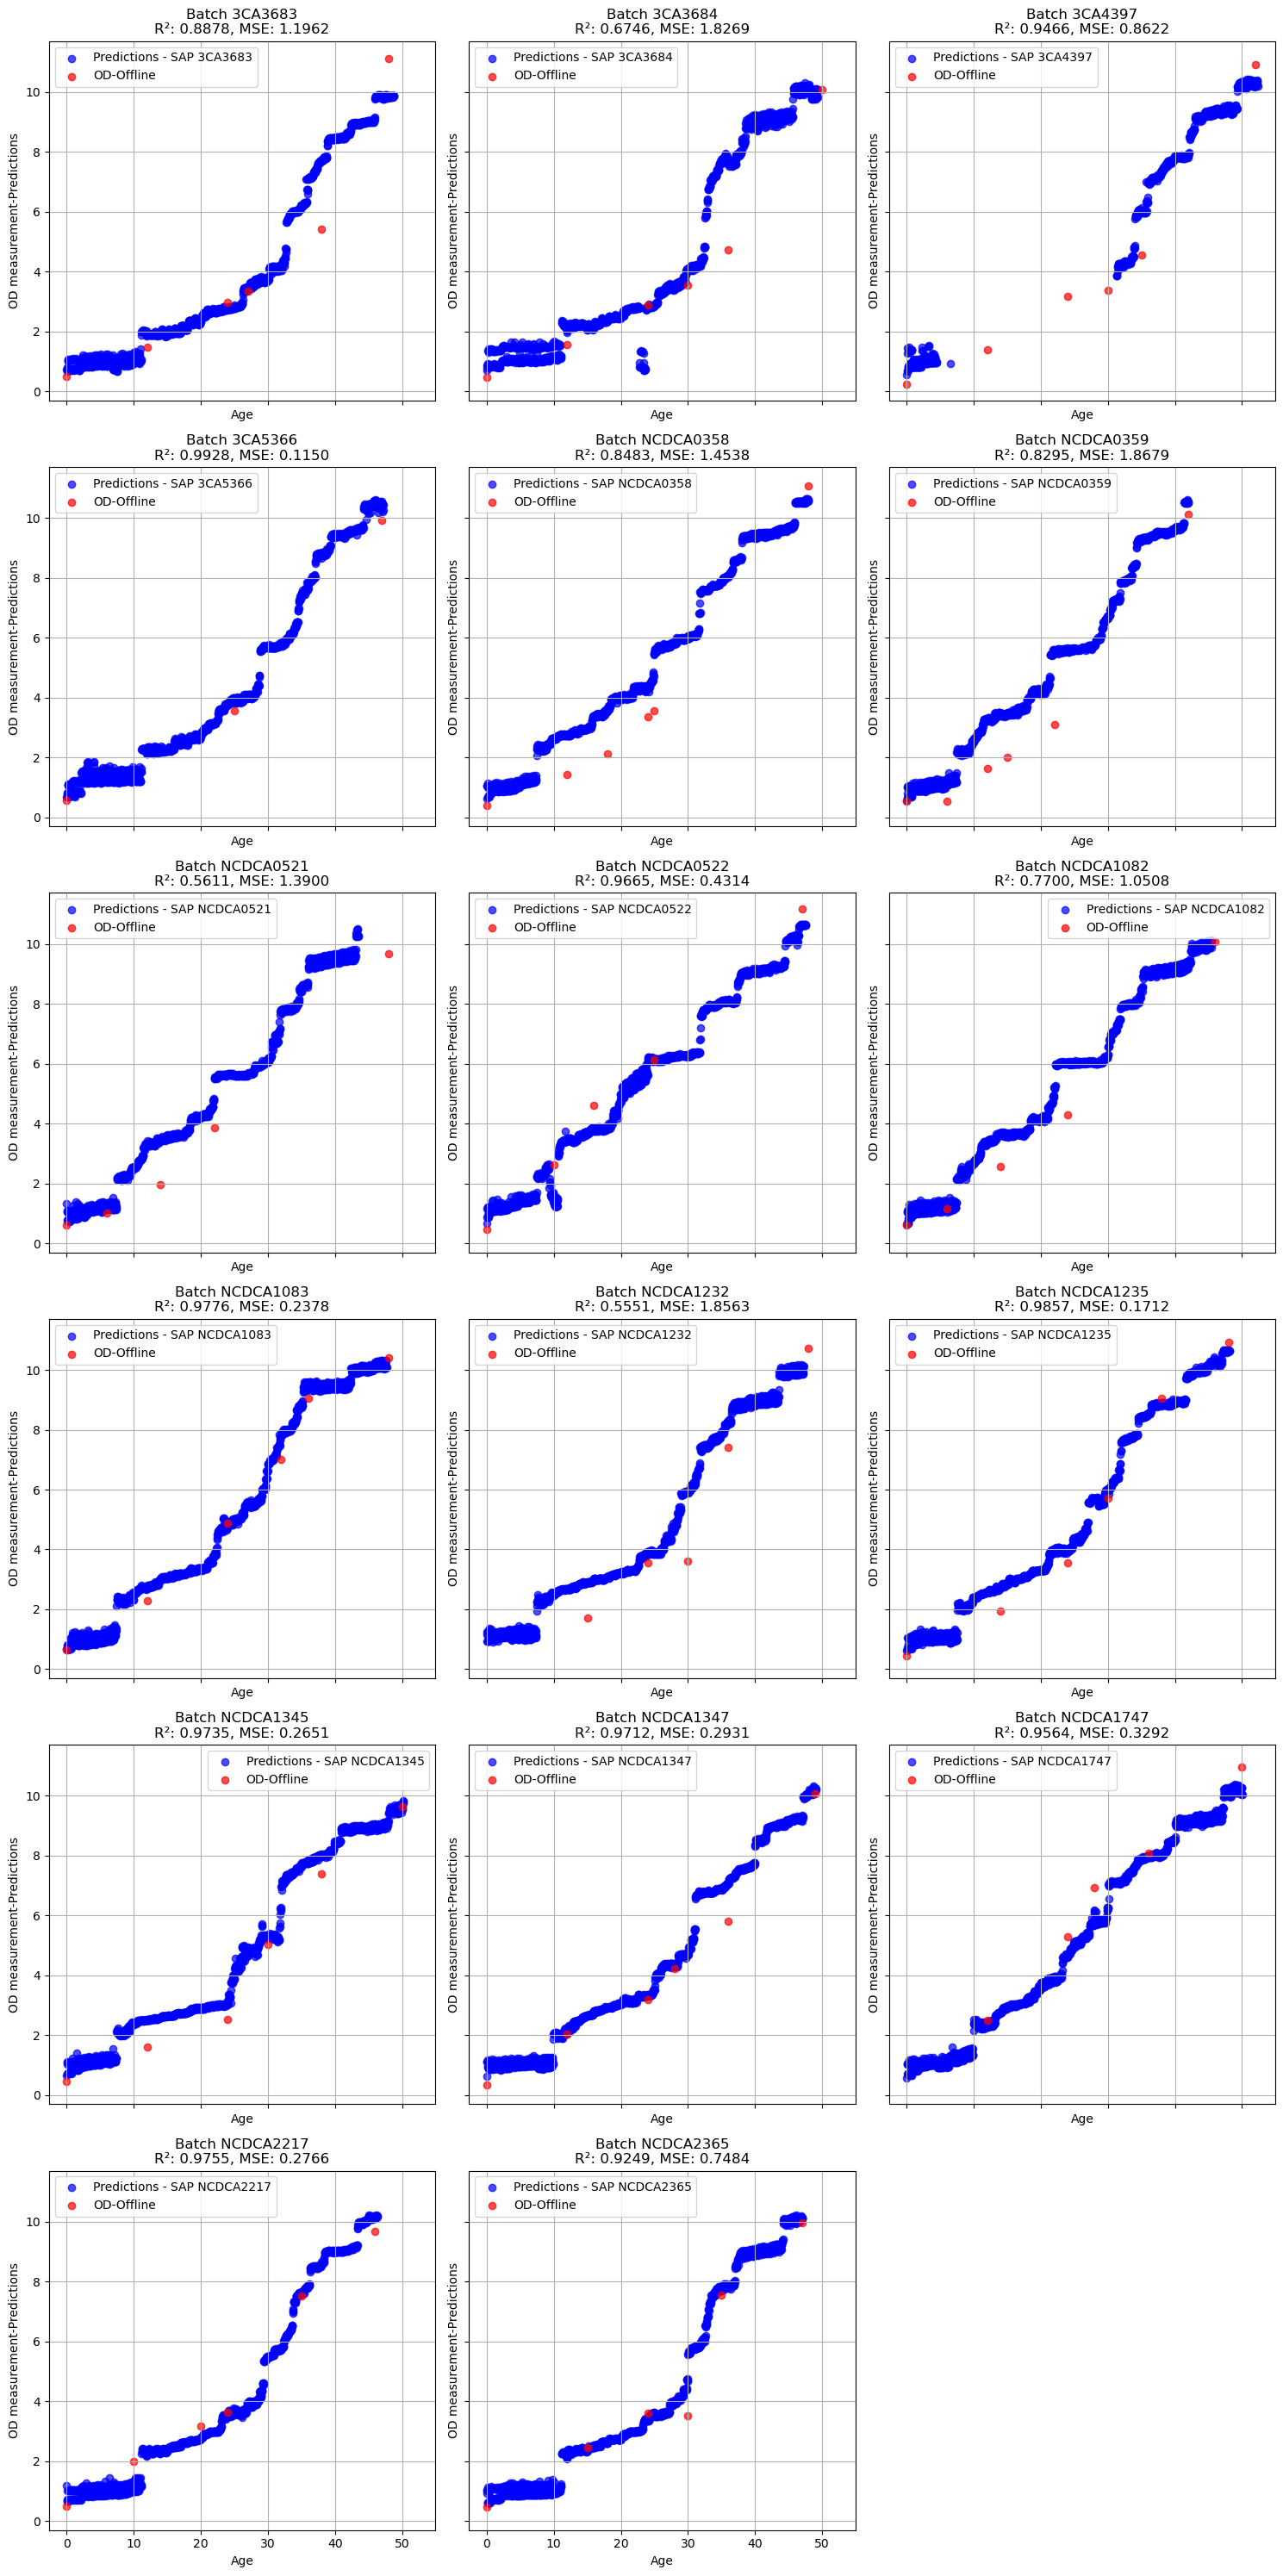

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Get unique batches from df_true_pivot_clean
batches = df_true_pivot_clean['SAP'].unique()

# Define number of columns
num_cols = 3
# Initialize list to track which axes to plot
axes_to_plot = []

# Calculate the number of rows based on the number of valid plots
for batch in batches:
    # Filter data for the current batch
    batch_data = df_true_pivot_clean[df_true_pivot_clean['SAP'] == batch]
    raman_data = df_Raman_v2_clean[df_Raman_v2_clean['BatchID'] == batch]

    # Ensure the data is aligned by Age
    merged_data = pd.merge(batch_data, raman_data, left_on='Age', right_on='Age(hr)', suffixes=('_pred', '_obs'))

    if not merged_data.empty:
        # Calculate R² and MSE between Predictions and OD-Offline measurement
        r2 = r2_score(merged_data['Predictions'], merged_data['OD- Offline measurement'])
        mse = mean_squared_error(merged_data['Predictions'], merged_data['OD- Offline measurement'])

        # Only plot if R² and MSE are valid numbers
        if not np.isnan(r2) and not np.isnan(mse):
            axes_to_plot.append(batch)

# Update num_batches and num_rows based on valid plots
num_batches = len(axes_to_plot)
num_rows = int(np.ceil(num_batches / num_cols))  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)

# Flatten the axes array for easy iteration if there's more than one row
axes = axes.flatten()

# Plot data and calculate R² and MSE for each valid batch
for i, batch in enumerate(axes_to_plot):
    # Filter data for the current batch
    batch_data = df_true_pivot_clean[df_true_pivot_clean['SAP'] == batch]
    raman_data = df_Raman_v2_clean[df_Raman_v2_clean['BatchID'] == batch]

    # Ensure the data is aligned by Age
    merged_data = pd.merge(batch_data, raman_data, left_on='Age', right_on='Age(hr)', suffixes=('_pred', '_obs'))

    # Calculate R² and MSE between Predictions and OD-Offline measurement
    r2 = r2_score(merged_data['Predictions'], merged_data['OD- Offline measurement'])
    mse = mean_squared_error(merged_data['Predictions'], merged_data['OD- Offline measurement'])

    # Plot predictions by Age for the current batch
    axes[i].scatter(batch_data['Age'], batch_data['Predictions'], alpha=0.7, color='blue', label=f'Predictions - SAP {batch}')
    
    # Overlay OD-Offline measurement from df_Raman_v2_clean
    axes[i].scatter(raman_data['Age(hr)'], raman_data['OD- Offline measurement'], alpha=0.7, color='red', label='OD-Offline')
    
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('OD measurement-Predictions')
    axes[i].set_title(f'Batch {batch}\nR²: {r2:.4f}, MSE: {mse:.4f}')
    axes[i].legend()
    axes[i].grid(True)

# Turn off unused subplots
for j in range(len(axes_to_plot), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Raman prediction model (NaN dropped)

In [62]:
import pandas as pd
file_path_Y = 'adjusted_df_Raman_Offline_OD.csv' 
df_Raman = pd.read_csv(file_path_Y)

In [63]:
df_Raman

Primary ID    BatchID    Age(hr)      Max1      Max2  \
0                3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
1              3CA3683-2.1    3CA3683   2.100000  4.946474  1.499905   
2      3CA3683-3.166666667    3CA3683   3.166667  4.920959  1.498602   
3      3CA3683-4.266666667    3CA3683   4.266667  5.869157  1.526436   
4      3CA3683-5.333333333    3CA3683   5.333333  5.234006  1.529197   
..                     ...        ...        ...       ...       ...   
238           NCDCA5242-24  NCDCA5242  24.000000  5.556314  0.475437   
239  NCDCA5242-33.23333333  NCDCA5242  33.233333  6.967318 -0.204087   
240           NCDCA5242-38  NCDCA5242  38.000000  7.174154 -0.213850   
241  NCDCA5242-43.46666667  NCDCA5242  43.466667  6.945235 -0.207621   
242           NCDCA5242-48  NCDCA5242  48.000000  4.950044 -0.236521   

         Max3      Max4      Max5      Max6  Age (h)  OD- Offline measurement  
0    0.293164  0.796074  2.927938  1.212130      0.0                    0.492  
1    0.289281  0.783597  2.861098  1.184933      NaN                      NaN  
2    0.281416  0.761361  2.834997  1.056845      NaN                      NaN  
3    0.276953  0.747706  2.735640  1.121744      NaN                      NaN  
4    0.266563  0.732086  2.755655  0.991809      NaN                      NaN  
..        ...       ...       ...       ...      ...                      ...  
238  0.107389  0.144852  1.961006  3.049581     24.0                    3.560  
239 -0.225534  0.274392  3.083424  2.938881      NaN                      NaN  
240 -0.090631 -0.014679  3.019546  3.118682      NaN                      NaN  
241 -0.119842  0.232199  1.112553  2.716811      NaN                      NaN  
242 -0.082413 -0.013536  1.273813  2.747120     48.0                    9.080  

[243 rows x 11 columns]

##### Drop rows with NaN

In [64]:
# Drop rows with any NaN values
df_Raman_clean = df_Raman.dropna()

In [65]:
df_Raman_clean.shape

(106, 11)

In [66]:
df_Raman_clean.head()

Primary ID  BatchID  Age(hr)      Max1      Max2      Max3      Max4  \
0    3CA3683-0  3CA3683      0.0  5.863282  1.483690  0.293164  0.796074   
11  3CA3683-12  3CA3683     12.0  5.506593  1.659500  0.237996  0.624207   
22  3CA3683-24  3CA3683     24.0  5.481324  1.847111  0.174586  0.330816   
24  3CA3683-27  3CA3683     27.0  5.478559  1.840556  0.152951  0.280825   
28  3CA3683-38  3CA3683     38.0  5.795407  1.899617  0.142383  0.310347   

        Max5      Max6  Age (h)  OD- Offline measurement  
0   2.927938  1.212130      0.0                    0.492  
11  2.579938  0.950721     12.0                    1.490  
22  2.139538  0.885068     24.0                    2.980  
24  2.052354  0.836901     27.0                    3.350  
28  1.701117  0.505041     38.0                    5.420

### Approach 1: Random Forest Regression Model - Raman

Mean Squared Error: 0.680
R^2 Score: 0.933


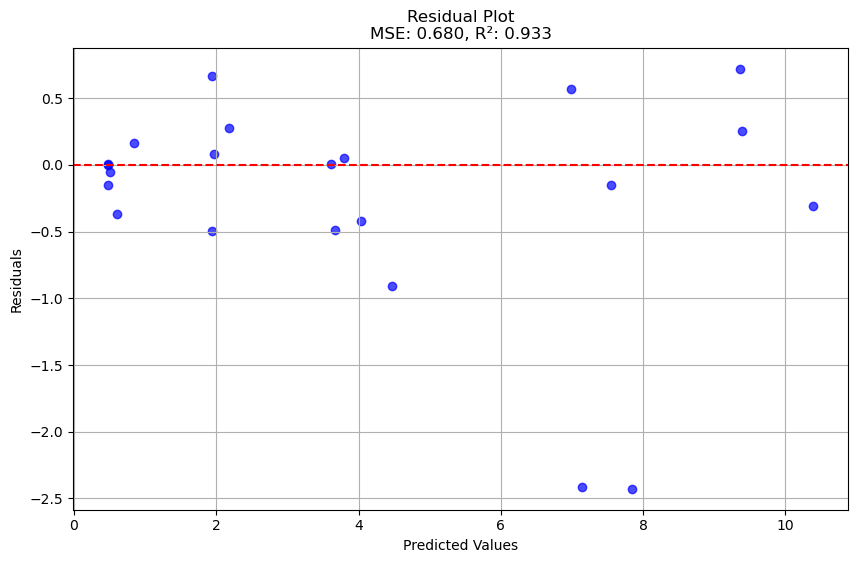

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Define predictor columns and response column
predictors = ['Max1', 'Max2', 'Max3', 'Max4', 'Max5', 'Max6', 'Age (h)']
response = 'OD- Offline measurement'

# Prepare the features and target variable
X_Raman = df_Raman_clean[predictors]  # Changed X to X_Raman
y_Raman = df_Raman_clean[response]    # Changed y to y_Raman

# Split the data into training and testing sets
X_Raman_train, X_Raman_test, y_Raman_train, y_Raman_test = train_test_split(X_Raman, y_Raman, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model_Raman = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model_Raman.fit(X_Raman_train, y_Raman_train)

# Make predictions
y_Raman_pred = rf_model_Raman.predict(X_Raman_test)

# Evaluate the model
mse = mean_squared_error(y_Raman_test, y_Raman_pred)
r2 = r2_score(y_Raman_test, y_Raman_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# Create a residual plot
residuals = y_Raman_test - y_Raman_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_Raman_pred, residuals, alpha=0.7, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residual Plot\nMSE: {mse:.3f}, R²: {r2:.3f}')
plt.grid(True)
plt.show()


#### 5-fold Cross-valiation

5-Fold Cross-Validation Mean MSE: 1.486
5-Fold Cross-Validation MSE Standard Deviation: 0.732
5-Fold Cross-Validation Mean R²: 0.872
5-Fold Cross-Validation R² Standard Deviation: 0.059


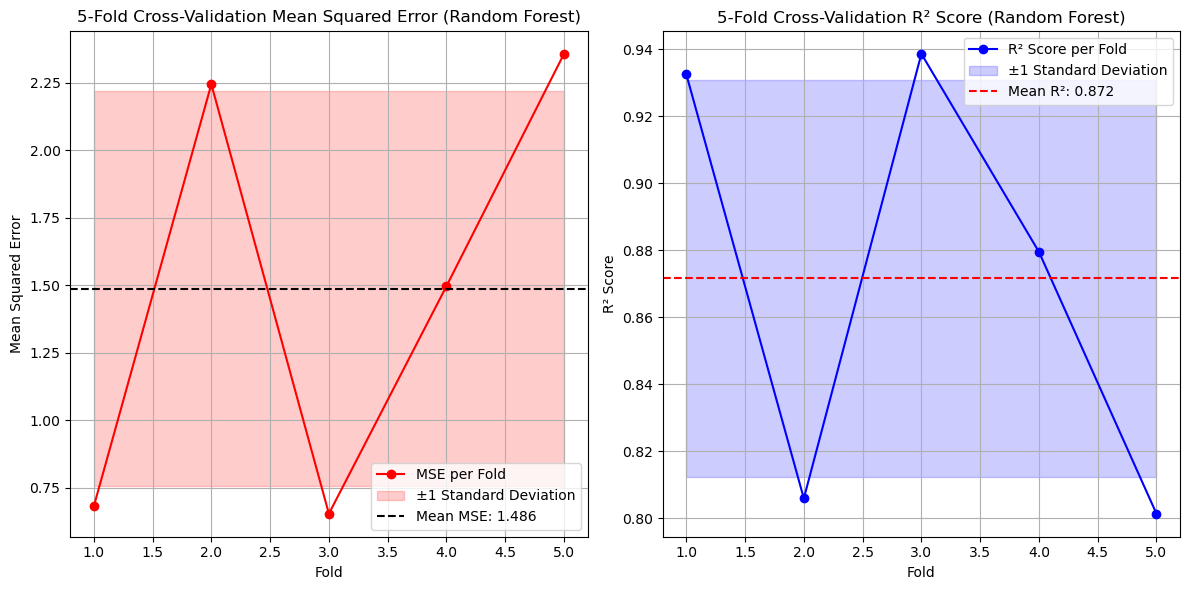

In [68]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

# Define predictor columns and response column
predictors = ['Max1', 'Max2', 'Max3', 'Max4', 'Max5', 'Max6', 'Age (h)']
response = 'OD- Offline measurement'

# Prepare the features and target variable
X = df_Raman_clean[predictors]
y = df_Raman_clean[response]

# Initialize the Random Forest model with the new name
rf_Raman_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for MSE and R²
cv_mse_results = cross_val_score(rf_Raman_model, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_r2_results = cross_val_score(rf_Raman_model, X, y, cv=kf, scoring='r2')

# Convert negative MSE values to positive
cv_mse = -cv_mse_results

# Calculate mean and standard deviation for MSE and R²
mean_mse = cv_mse.mean()
std_mse = cv_mse.std()
mean_r2 = cv_r2_results.mean()
std_r2 = cv_r2_results.std()

# Print results
print(f"5-Fold Cross-Validation Mean MSE: {mean_mse:.3f}")
print(f"5-Fold Cross-Validation MSE Standard Deviation: {std_mse:.3f}")
print(f"5-Fold Cross-Validation Mean R²: {mean_r2:.3f}")
print(f"5-Fold Cross-Validation R² Standard Deviation: {std_r2:.3f}")

# Plot the cross-validation results
plt.figure(figsize=(12, 6))

# MSE Plot with shaded standard deviation region
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), cv_mse, marker='o', linestyle='-', color='red', label='MSE per Fold')
plt.fill_between(range(1, 6), 
                 mean_mse - std_mse, 
                 mean_mse + std_mse, 
                 color='red', 
                 alpha=0.2, 
                 label='±1 Standard Deviation')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('5-Fold Cross-Validation Mean Squared Error (Random Forest)')
plt.axhline(mean_mse, color='black', linestyle='--', label=f'Mean MSE: {mean_mse:.3f}')
plt.legend()
plt.grid(True)

# R² Plot with shaded standard deviation region
plt.subplot(1, 2, 2)
plt.plot(range(1, 6), cv_r2_results, marker='o', linestyle='-', color='blue', label='R² Score per Fold')
plt.fill_between(range(1, 6), 
                 mean_r2 - std_r2, 
                 mean_r2 + std_r2, 
                 color='blue', 
                 alpha=0.2, 
                 label='±1 Standard Deviation')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('5-Fold Cross-Validation R² Score (Random Forest)')
plt.axhline(mean_r2, color='red', linestyle='--', label=f'Mean R²: {mean_r2:.3f}')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [69]:
df_Raman_clean

Primary ID    BatchID  Age(hr)      Max1      Max2      Max3      Max4  \
0       3CA3683-0    3CA3683      0.0  5.863282  1.483690  0.293164  0.796074   
11     3CA3683-12    3CA3683     12.0  5.506593  1.659500  0.237996  0.624207   
22     3CA3683-24    3CA3683     24.0  5.481324  1.847111  0.174586  0.330816   
24     3CA3683-27    3CA3683     27.0  5.478559  1.840556  0.152951  0.280825   
28     3CA3683-38    3CA3683     38.0  5.795407  1.899617  0.142383  0.310347   
..            ...        ...      ...       ...       ...       ...       ...   
227  NCDCA2365-47  NCDCA2365     47.0  1.284329  4.969198  0.512385  0.916294   
228   NCDCA4426-0  NCDCA4426      0.0  2.215256  1.144644  0.146935  0.956372   
237  NCDCA4426-49  NCDCA4426     49.0  3.061474  3.949604  0.486564  0.913085   
238  NCDCA5242-24  NCDCA5242     24.0  5.556314  0.475437  0.107389  0.144852   
242  NCDCA5242-48  NCDCA5242     48.0  4.950044 -0.236521 -0.082413 -0.013536   

         Max5      Max6  Age (h)  OD- Offline measurement  
0    2.927938  1.212130      0.0                    0.492  
11   2.579938  0.950721     12.0                    1.490  
22   2.139538  0.885068     24.0                    2.980  
24   2.052354  0.836901     27.0                    3.350  
28   1.701117  0.505041     38.0                    5.420  
..        ...       ...      ...                      ...  
227  3.723414  1.847902     47.0                    9.960  
228  7.100017  4.753893      0.0                    0.330  
237  3.793392  1.618652     49.0                    8.800  
238  1.961006  3.049581     24.0                    3.560  
242  1.273813  2.747120     48.0                    9.080  

[106 rows x 11 columns]

### Compilation

In [70]:
import pandas as pd

# Define the summary data
data = {
    'Model': ['Random Forest Regression', 'Neural Network'],
    'R² Score': [0.933, 0.924],  # R² Score for both models
    '5-Fold Cross-Validation Mean R²': [0.872, 0.891]  # Mean R² from cross-validation
}

# Create a DataFrame
summary_table = pd.DataFrame(data)

# Add an overall title
print("Raman Prediction Model Summary (NaN dropped)")

# Display the summary table
#print(summary_table)
summary_table

Raman Prediction Model Summary (NaN dropped)


Model  R² Score  5-Fold Cross-Validation Mean R²
0  Random Forest Regression     0.933                            0.872
1            Neural Network     0.924                            0.891

Try interpolate the OD-offiline measurement before training the model

In [71]:
df_Raman.head()

Primary ID  BatchID   Age(hr)      Max1      Max2      Max3  \
0            3CA3683-0  3CA3683  0.000000  5.863282  1.483690  0.293164   
1          3CA3683-2.1  3CA3683  2.100000  4.946474  1.499905  0.289281   
2  3CA3683-3.166666667  3CA3683  3.166667  4.920959  1.498602  0.281416   
3  3CA3683-4.266666667  3CA3683  4.266667  5.869157  1.526436  0.276953   
4  3CA3683-5.333333333  3CA3683  5.333333  5.234006  1.529197  0.266563   

       Max4      Max5      Max6  Age (h)  OD- Offline measurement  
0  0.796074  2.927938  1.212130      0.0                    0.492  
1  0.783597  2.861098  1.184933      NaN                      NaN  
2  0.761361  2.834997  1.056845      NaN                      NaN  
3  0.747706  2.735640  1.121744      NaN                      NaN  
4  0.732086  2.755655  0.991809      NaN                      NaN

In [72]:
# Drop the duplicate 'Age (h)' column
df_Raman.drop(columns='Age (h)', inplace=True)

In [73]:
df_Raman.head()

Primary ID  BatchID   Age(hr)      Max1      Max2      Max3  \
0            3CA3683-0  3CA3683  0.000000  5.863282  1.483690  0.293164   
1          3CA3683-2.1  3CA3683  2.100000  4.946474  1.499905  0.289281   
2  3CA3683-3.166666667  3CA3683  3.166667  4.920959  1.498602  0.281416   
3  3CA3683-4.266666667  3CA3683  4.266667  5.869157  1.526436  0.276953   
4  3CA3683-5.333333333  3CA3683  5.333333  5.234006  1.529197  0.266563   

       Max4      Max5      Max6  OD- Offline measurement  
0  0.796074  2.927938  1.212130                    0.492  
1  0.783597  2.861098  1.184933                      NaN  
2  0.761361  2.834997  1.056845                      NaN  
3  0.747706  2.735640  1.121744                      NaN  
4  0.732086  2.755655  0.991809                      NaN

Use 6 PREDICTORS from the JMP table: Age + 5 peaks to predict OD. Using random forest first, if is greater than 0.89, use it; if not considering uisng simple neutral network (try 7 nodes, max 2 layers, this is the model JMP was using and it got 0.92 R2 with 5 fold average). Next step will be how to reinforce the data-driven model with the Raman prediction data.

### Predict using Raman model

In [74]:
df_Raman

Primary ID    BatchID    Age(hr)      Max1      Max2  \
0                3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
1              3CA3683-2.1    3CA3683   2.100000  4.946474  1.499905   
2      3CA3683-3.166666667    3CA3683   3.166667  4.920959  1.498602   
3      3CA3683-4.266666667    3CA3683   4.266667  5.869157  1.526436   
4      3CA3683-5.333333333    3CA3683   5.333333  5.234006  1.529197   
..                     ...        ...        ...       ...       ...   
238           NCDCA5242-24  NCDCA5242  24.000000  5.556314  0.475437   
239  NCDCA5242-33.23333333  NCDCA5242  33.233333  6.967318 -0.204087   
240           NCDCA5242-38  NCDCA5242  38.000000  7.174154 -0.213850   
241  NCDCA5242-43.46666667  NCDCA5242  43.466667  6.945235 -0.207621   
242           NCDCA5242-48  NCDCA5242  48.000000  4.950044 -0.236521   

         Max3      Max4      Max5      Max6  OD- Offline measurement  
0    0.293164  0.796074  2.927938  1.212130                    0.492  
1    0.289281  0.783597  2.861098  1.184933                      NaN  
2    0.281416  0.761361  2.834997  1.056845                      NaN  
3    0.276953  0.747706  2.735640  1.121744                      NaN  
4    0.266563  0.732086  2.755655  0.991809                      NaN  
..        ...       ...       ...       ...                      ...  
238  0.107389  0.144852  1.961006  3.049581                    3.560  
239 -0.225534  0.274392  3.083424  2.938881                      NaN  
240 -0.090631 -0.014679  3.019546  3.118682                      NaN  
241 -0.119842  0.232199  1.112553  2.716811                      NaN  
242 -0.082413 -0.013536  1.273813  2.747120                    9.080  

[243 rows x 10 columns]

In [75]:
# Drop the second 'Age (h)' column which is completely NaN
#df_Raman_cleaned2 = df_Raman.drop(columns='Age (h)')

# Print the updated DataFrame
#df_Raman_cleaned2
df_Raman_cleaned2=df_Raman
df_Raman_cleaned2

Primary ID    BatchID    Age(hr)      Max1      Max2  \
0                3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
1              3CA3683-2.1    3CA3683   2.100000  4.946474  1.499905   
2      3CA3683-3.166666667    3CA3683   3.166667  4.920959  1.498602   
3      3CA3683-4.266666667    3CA3683   4.266667  5.869157  1.526436   
4      3CA3683-5.333333333    3CA3683   5.333333  5.234006  1.529197   
..                     ...        ...        ...       ...       ...   
238           NCDCA5242-24  NCDCA5242  24.000000  5.556314  0.475437   
239  NCDCA5242-33.23333333  NCDCA5242  33.233333  6.967318 -0.204087   
240           NCDCA5242-38  NCDCA5242  38.000000  7.174154 -0.213850   
241  NCDCA5242-43.46666667  NCDCA5242  43.466667  6.945235 -0.207621   
242           NCDCA5242-48  NCDCA5242  48.000000  4.950044 -0.236521   

         Max3      Max4      Max5      Max6  OD- Offline measurement  
0    0.293164  0.796074  2.927938  1.212130                    0.492  
1    0.289281  0.783597  2.861098  1.184933                      NaN  
2    0.281416  0.761361  2.834997  1.056845                      NaN  
3    0.276953  0.747706  2.735640  1.121744                      NaN  
4    0.266563  0.732086  2.755655  0.991809                      NaN  
..        ...       ...       ...       ...                      ...  
238  0.107389  0.144852  1.961006  3.049581                    3.560  
239 -0.225534  0.274392  3.083424  2.938881                      NaN  
240 -0.090631 -0.014679  3.019546  3.118682                      NaN  
241 -0.119842  0.232199  1.112553  2.716811                      NaN  
242 -0.082413 -0.013536  1.273813  2.747120                    9.080  

[243 rows x 10 columns]

In [76]:
df_Raman_cleaned3 = df_Raman_cleaned2.drop(columns=['Primary ID', 'OD- Offline measurement'])

# Rename the column
df_Raman_cleaned3 = df_Raman_cleaned3.rename(columns={'Age(hr)': 'Age (h)'})

# Reorder columns to place 'Age (h)' after 'Max6'
column_order = ['Max1', 'Max2', 'Max3', 'Max4', 'Max5', 'Max6', 'Age (h)',"BatchID"]
df_Raman_cleaned3 = df_Raman_cleaned3[column_order]

df_Raman_cleaned3

Max1      Max2      Max3      Max4      Max5      Max6    Age (h)  \
0    5.863282  1.483690  0.293164  0.796074  2.927938  1.212130   0.000000   
1    4.946474  1.499905  0.289281  0.783597  2.861098  1.184933   2.100000   
2    4.920959  1.498602  0.281416  0.761361  2.834997  1.056845   3.166667   
3    5.869157  1.526436  0.276953  0.747706  2.735640  1.121744   4.266667   
4    5.234006  1.529197  0.266563  0.732086  2.755655  0.991809   5.333333   
..        ...       ...       ...       ...       ...       ...        ...   
238  5.556314  0.475437  0.107389  0.144852  1.961006  3.049581  24.000000   
239  6.967318 -0.204087 -0.225534  0.274392  3.083424  2.938881  33.233333   
240  7.174154 -0.213850 -0.090631 -0.014679  3.019546  3.118682  38.000000   
241  6.945235 -0.207621 -0.119842  0.232199  1.112553  2.716811  43.466667   
242  4.950044 -0.236521 -0.082413 -0.013536  1.273813  2.747120  48.000000   

       BatchID  
0      3CA3683  
1      3CA3683  
2      3CA3683  
3      3CA3683  
4      3CA3683  
..         ...  
238  NCDCA5242  
239  NCDCA5242  
240  NCDCA5242  
241  NCDCA5242  
242  NCDCA5242  

[243 rows x 8 columns]

In [77]:
features = ['Max1', 'Max2', 'Max3', 'Max4', 'Max5', 'Max6', 'Age (h)']

# Make predictions
y_pred = rf_model_Raman.predict(df_Raman_cleaned3[features])

In [78]:
df_Raman_cleaned4 = df_Raman_cleaned2.copy()
df_Raman_cleaned4['prediction'] = y_pred

In [79]:
df_Raman_cleaned4

Primary ID    BatchID    Age(hr)      Max1      Max2  \
0                3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
1              3CA3683-2.1    3CA3683   2.100000  4.946474  1.499905   
2      3CA3683-3.166666667    3CA3683   3.166667  4.920959  1.498602   
3      3CA3683-4.266666667    3CA3683   4.266667  5.869157  1.526436   
4      3CA3683-5.333333333    3CA3683   5.333333  5.234006  1.529197   
..                     ...        ...        ...       ...       ...   
238           NCDCA5242-24  NCDCA5242  24.000000  5.556314  0.475437   
239  NCDCA5242-33.23333333  NCDCA5242  33.233333  6.967318 -0.204087   
240           NCDCA5242-38  NCDCA5242  38.000000  7.174154 -0.213850   
241  NCDCA5242-43.46666667  NCDCA5242  43.466667  6.945235 -0.207621   
242           NCDCA5242-48  NCDCA5242  48.000000  4.950044 -0.236521   

         Max3      Max4      Max5      Max6  OD- Offline measurement  \
0    0.293164  0.796074  2.927938  1.212130                    0.492   
1    0.289281  0.783597  2.861098  1.184933                      NaN   
2    0.281416  0.761361  2.834997  1.056845                      NaN   
3    0.276953  0.747706  2.735640  1.121744                      NaN   
4    0.266563  0.732086  2.755655  0.991809                      NaN   
..        ...       ...       ...       ...                      ...   
238  0.107389  0.144852  1.961006  3.049581                    3.560   
239 -0.225534  0.274392  3.083424  2.938881                      NaN   
240 -0.090631 -0.014679  3.019546  3.118682                      NaN   
241 -0.119842  0.232199  1.112553  2.716811                      NaN   
242 -0.082413 -0.013536  1.273813  2.747120                    9.080   

     prediction  
0       0.48270  
1       0.47925  
2       0.63566  
3       0.63497  
4       0.76210  
..          ...  
238     3.44170  
239     5.64170  
240     6.99400  
241     9.29860  
242     9.17860  

[243 rows x 11 columns]

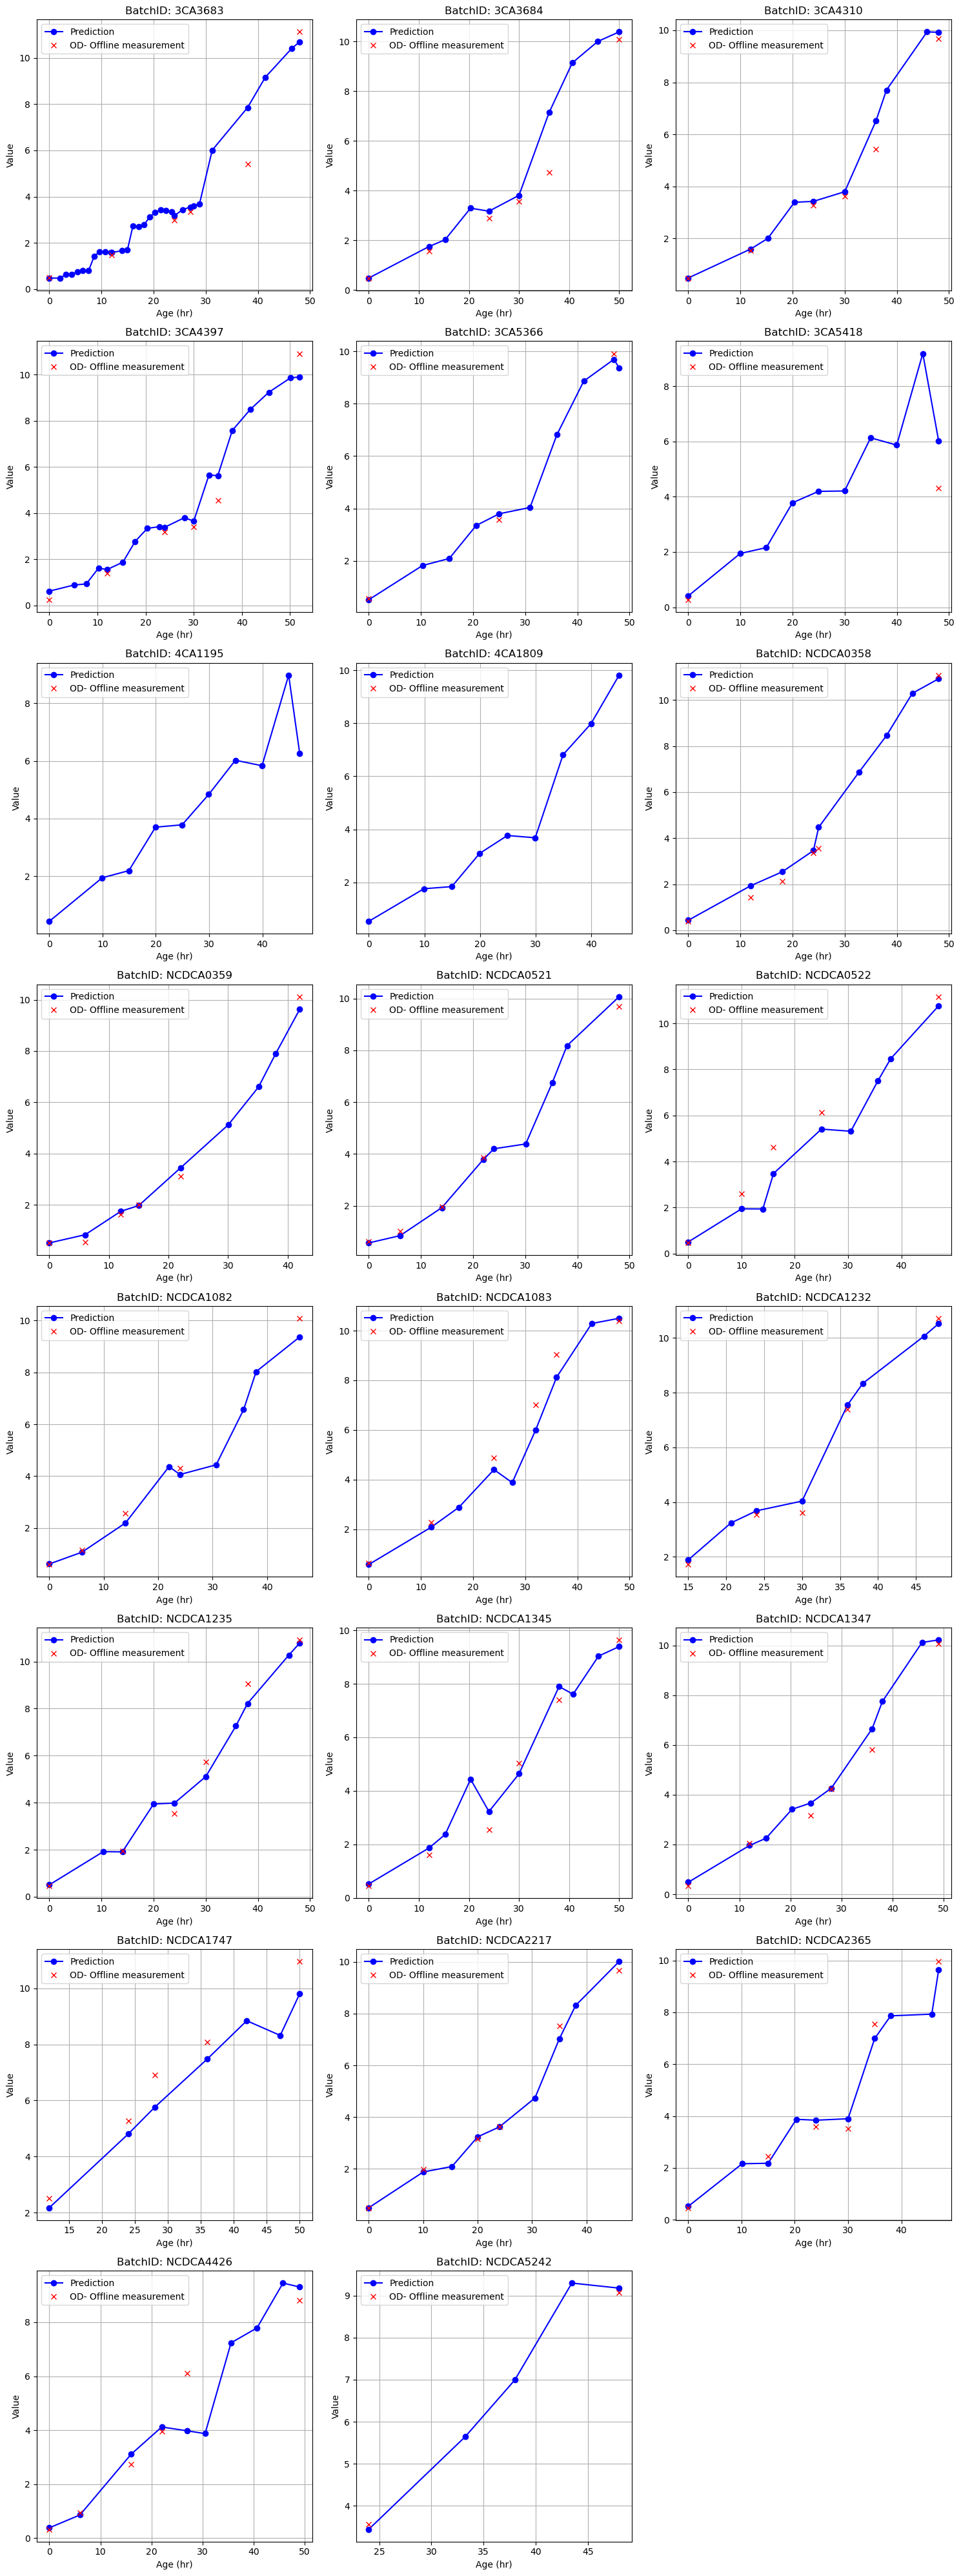

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_Raman_cleaned4 is already created and available

# Group the DataFrame by 'BatchID'
grouped = df_Raman_cleaned4.groupby('BatchID')

# Determine the number of unique BatchIDs to set the number of subplots
num_batches = len(grouped)

# Define the number of rows and columns for subplots
num_cols = 3
num_rows = int(np.ceil(num_batches / num_cols))

# Create a figure and set of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration (useful when there's more than one row)
axes = axes.flatten()

# Loop through each batch and corresponding axis
for ax, (batch_id, group) in zip(axes, grouped):
    # Plot 'Age(hr)' on the x-axis and 'prediction' on the y-axis for each batch
    ax.plot(group['Age(hr)'], group['prediction'], marker='o', linestyle='-', color='blue', label='Prediction')
    
    # Overlay with 'OD- Offline measurement' (only markers, no connecting lines)
    ax.plot(group['Age(hr)'], group['OD- Offline measurement'], marker='x', linestyle='none', color='red', label='OD- Offline measurement')
    
    # Set the title, labels, and add a grid
    ax.set_title(f'BatchID: {batch_id}')
    ax.set_xlabel('Age (hr)')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.legend()

# If there are unused subplots (when num_batches is not a multiple of 3), hide them
for i in range(num_batches, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


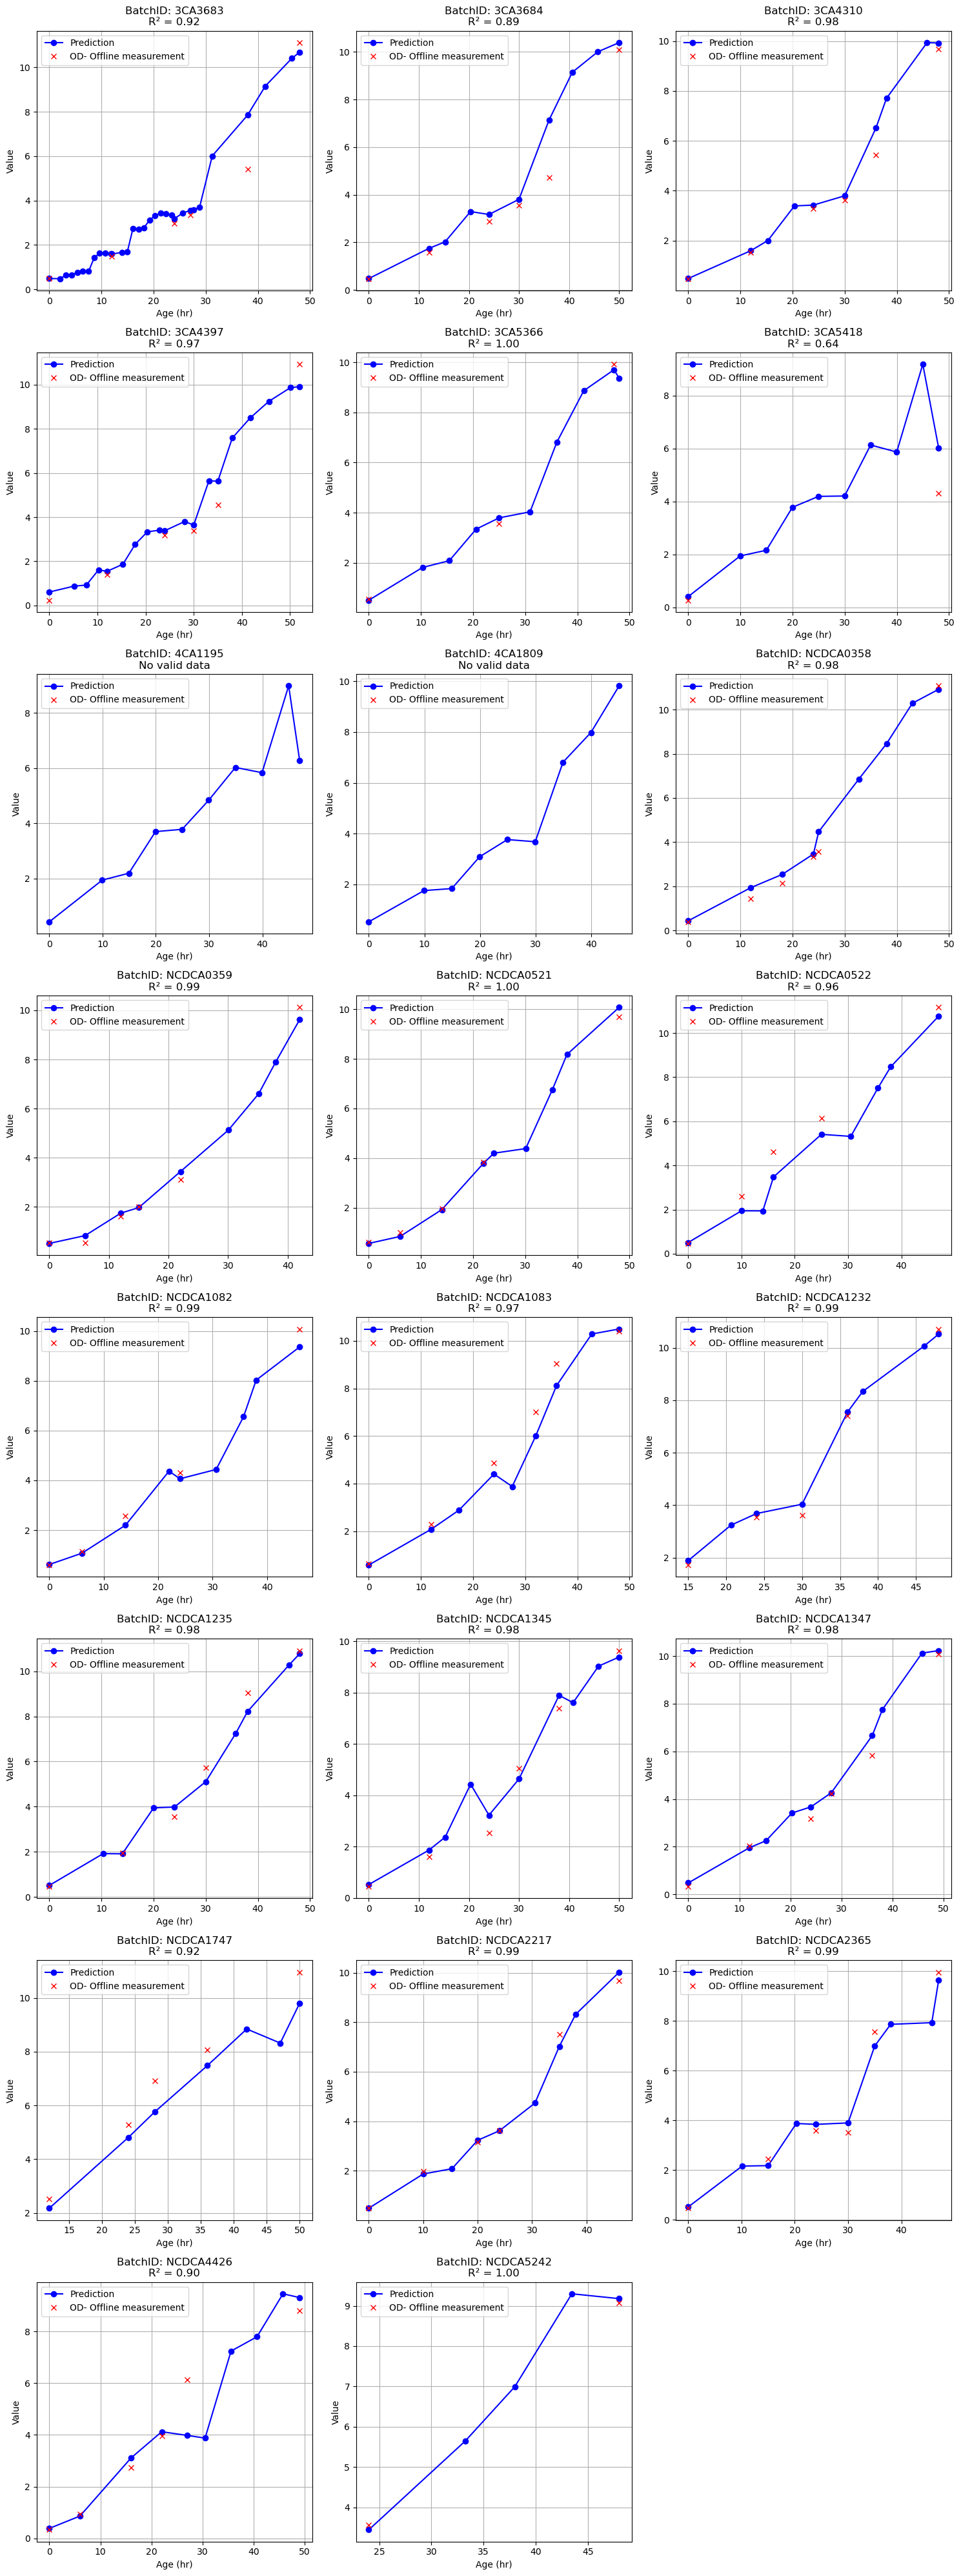

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

# Assuming df_Raman_cleaned4 is already created and available

# Group the DataFrame by 'BatchID'
grouped = df_Raman_cleaned4.groupby('BatchID')

# Determine the number of unique BatchIDs to set the number of subplots
num_batches = len(grouped)

# Define the number of rows and columns for subplots
num_cols = 3
num_rows = int(np.ceil(num_batches / num_cols))

# Create a figure and set of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration (useful when there's more than one row)
axes = axes.flatten()

# Loop through each batch and corresponding axis
for ax, (batch_id, group) in zip(axes, grouped):
    # Plot 'Age(hr)' on the x-axis and 'prediction' on the y-axis for each batch
    ax.plot(group['Age(hr)'], group['prediction'], marker='o', linestyle='-', color='blue', label='Prediction')
    
    # Overlay with 'OD- Offline measurement' (only markers, no connecting lines)
    ax.plot(group['Age(hr)'], group['OD- Offline measurement'], marker='x', linestyle='none', color='red', label='OD- Offline measurement')
    
    # Drop rows where either 'prediction' or 'OD- Offline measurement' is NaN for R² calculation
    valid_group = group.dropna(subset=['prediction', 'OD- Offline measurement'])
    
    if not valid_group.empty:
        # Calculate R² for the valid data
        r2 = r2_score(valid_group['OD- Offline measurement'], valid_group['prediction'])
        
        # Set the title with R² value, labels, and add a grid
        ax.set_title(f'BatchID: {batch_id}\nR² = {r2:.2f}')
    else:
        # If no valid data, set a title indicating no data
        ax.set_title(f'BatchID: {batch_id}\nNo valid data')
    
    ax.set_xlabel('Age (hr)')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.legend()

# If there are unused subplots (when num_batches is not a multiple of 3), hide them
for i in range(num_batches, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


### Overlay all three data

The objective of this is to overlay model prediction, Raman prediction, and offline measurement.

C:\Users\U1031072\AppData\Local\anaconda3_v1\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\U1031072\AppData\Local\anaconda3_v1\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


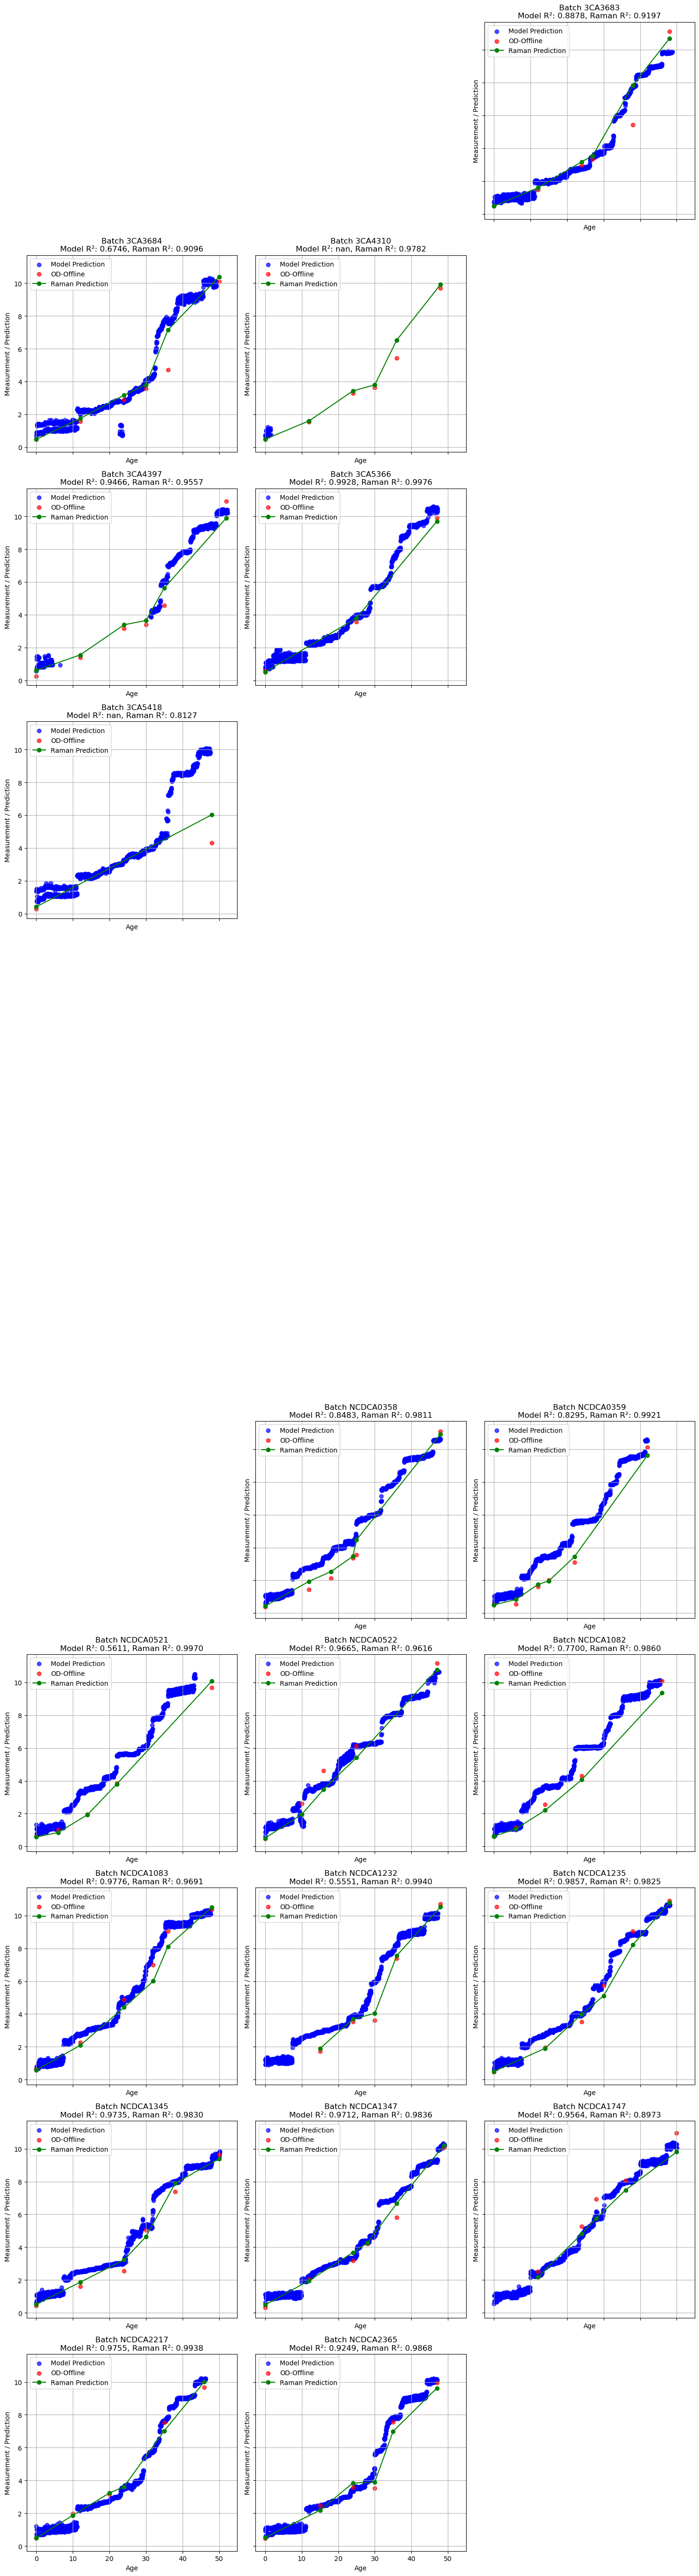

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Assuming df_true_pivot_clean, df_Raman_v2_clean, and df_Raman_cleaned4 are already created and available

# Get unique batches from df_true_pivot_clean
batches = df_true_pivot_clean['SAP'].unique()

# Define number of columns for the subplot grid
num_cols = 3
num_rows = int(np.ceil(len(batches) / num_cols))  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)

# Flatten the axes array for easy iteration if there's more than one row
axes = axes.flatten()

# Initialize list to track which axes to plot
axes_to_plot = []

for i, batch in enumerate(batches):
    # Filter data for the current batch
    batch_data = df_true_pivot_clean[df_true_pivot_clean['SAP'] == batch]
    raman_data = df_Raman_v2_clean[df_Raman_v2_clean['BatchID'] == batch]
    raman_cleaned_data = df_Raman_cleaned4[df_Raman_cleaned4['BatchID'] == batch]

    # Ensure the data is aligned by Age
    merged_data = pd.merge(batch_data, raman_data, left_on='Age', right_on='Age(hr)', suffixes=('_pred', '_obs'))
    valid_raman_data = raman_cleaned_data.dropna(subset=['prediction', 'OD- Offline measurement'])

    if not merged_data.empty:
        # Calculate R² and MSE between Predictions and OD-Offline measurement
        r2_model = r2_score(merged_data['Predictions'], merged_data['OD- Offline measurement'])
        mse_model = mean_squared_error(merged_data['Predictions'], merged_data['OD- Offline measurement'])
        
        # Plot Predictions vs OD-Offline measurements
        axes[i].scatter(batch_data['Age'], batch_data['Predictions'], alpha=0.7, color='blue', label=f'Model Prediction')
        axes[i].scatter(raman_data['Age(hr)'], raman_data['OD- Offline measurement'], alpha=0.7, color='red', label='OD-Offline')
        
        if not valid_raman_data.empty:
            # Plot Raman cleaned data
            axes[i].plot(valid_raman_data['Age(hr)'], valid_raman_data['prediction'], marker='o', linestyle='-', color='green', label='Raman Prediction')
            #axes[i].plot(valid_raman_data['Age(hr)'], valid_raman_data['OD- Offline measurement'], marker='x', linestyle='none', color='purple', label='Raman OD-Offline')

            # Calculate R² for Raman predictions
            r2_raman = r2_score(valid_raman_data['prediction'], valid_raman_data['OD- Offline measurement'])
        else:
            r2_raman = np.nan  # No Raman data available

        # Set title with R² and MSE values, labels, and add a grid
        #axes[i].set_title(f'Batch {batch}\nModel R²: {r2_model:.4f}, Raman R²: {r2_raman:.4f}\nMSE: {mse_model:.4f}')
        axes[i].set_title(f'Batch {batch}\nModel R²: {r2_model:.4f}, Raman R²: {r2_raman:.4f}')
        axes[i].set_xlabel('Age')
        axes[i].set_ylabel('Measurement / Prediction')
        axes[i].grid(True)
        axes[i].legend()

        # Track which axes to plot
        axes_to_plot.append(i)
    else:
        # If no data to plot, hide the subplot
        axes[i].axis('off')

# Turn off unused subplots
for j in range(len(batches), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


C:\Users\U1031072\AppData\Local\anaconda3_v1\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\U1031072\AppData\Local\anaconda3_v1\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


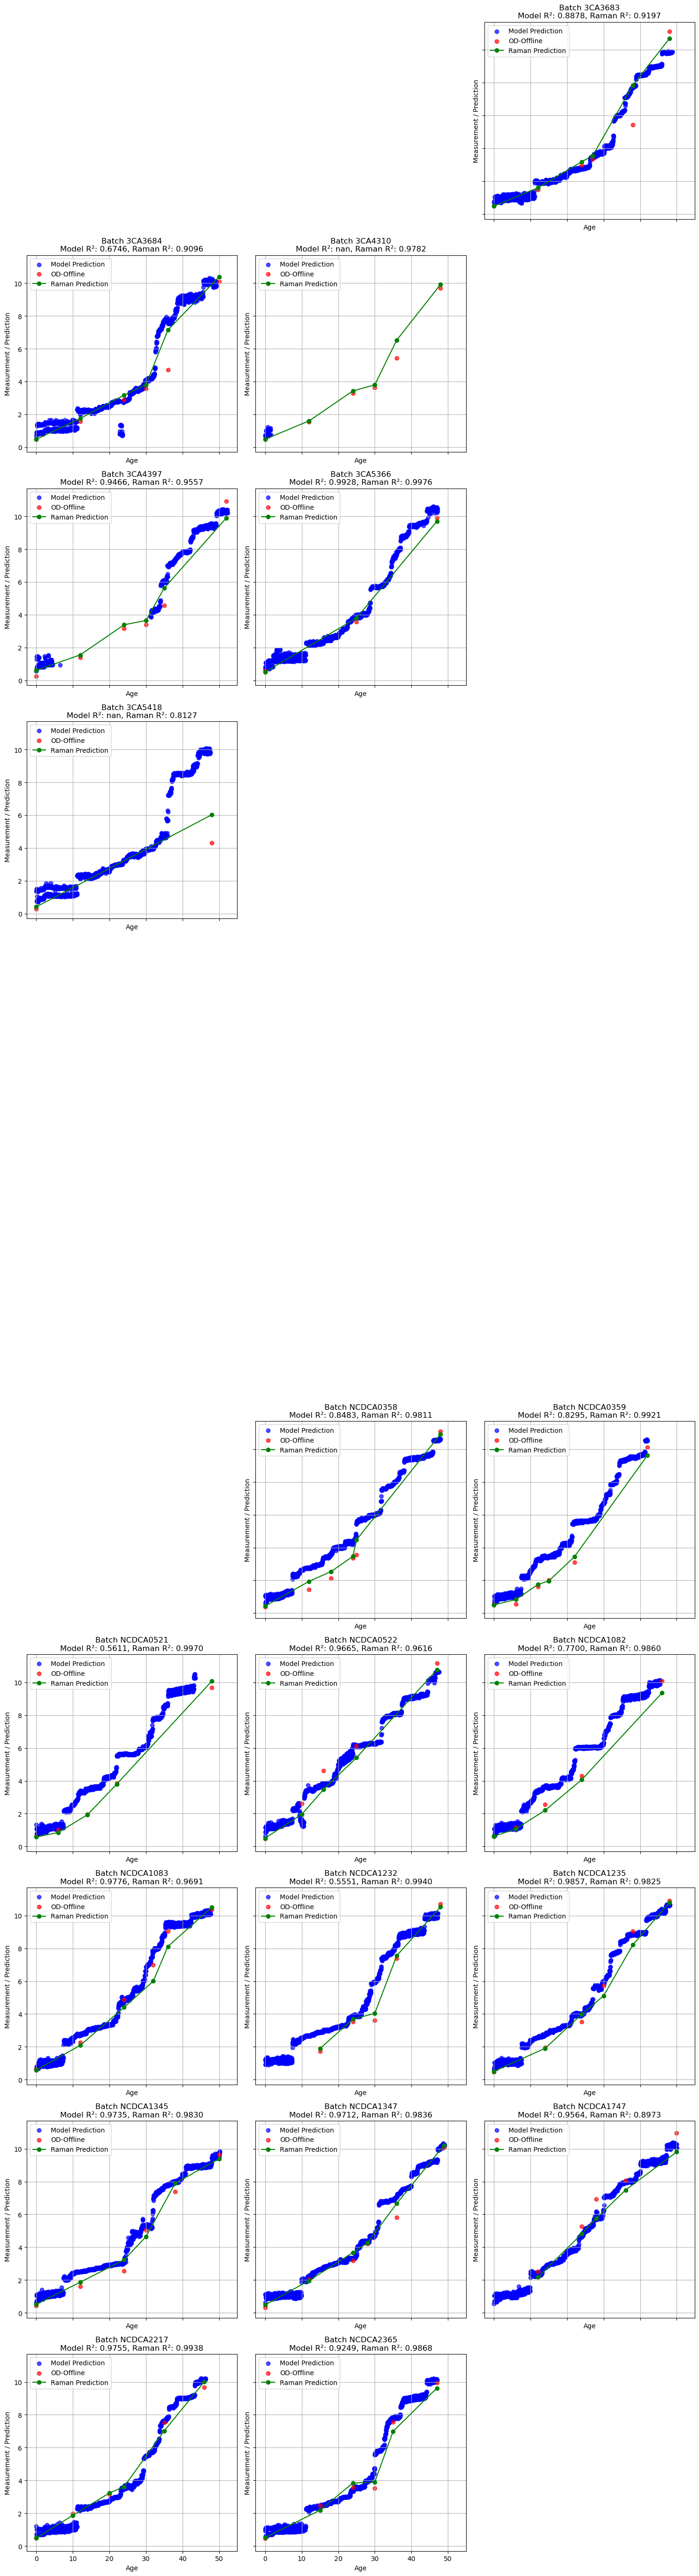

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

# Assuming df_true_pivot_clean, df_Raman_v2_clean, and df_Raman_cleaned4 are already created and available

# Get unique batches from df_true_pivot_clean
batches = df_true_pivot_clean['SAP'].unique()
num_batches = len(batches)

# Define number of columns for the subplot grid
num_cols = 3
num_rows = int(np.ceil(num_batches / num_cols))  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)

# Flatten the axes array for easy iteration if there's more than one row
axes = axes.flatten()

for i, batch in enumerate(batches):
    # Filter data for the current batch
    batch_data = df_true_pivot_clean[df_true_pivot_clean['SAP'] == batch]
    raman_data = df_Raman_v2_clean[df_Raman_v2_clean['BatchID'] == batch]
    raman_cleaned_data = df_Raman_cleaned4[df_Raman_cleaned4['BatchID'] == batch]

    # Ensure the data is aligned by Age
    merged_data = pd.merge(batch_data, raman_data, left_on='Age', right_on='Age(hr)', suffixes=('_pred', '_obs'))
    valid_raman_data = raman_cleaned_data.dropna(subset=['prediction', 'OD- Offline measurement'])

    if not merged_data.empty:
        # Calculate R² for Model and Raman predictions
        r2_model = r2_score(merged_data['Predictions'], merged_data['OD- Offline measurement'])
        r2_raman = r2_score(valid_raman_data['prediction'], valid_raman_data['OD- Offline measurement']) if not valid_raman_data.empty else np.nan

        # Plot Predictions vs OD-Offline measurements
        axes[i].scatter(batch_data['Age'], batch_data['Predictions'], alpha=0.7, color='blue', label='Model Prediction')
        axes[i].scatter(raman_data['Age(hr)'], raman_data['OD- Offline measurement'], alpha=0.7, color='red', label='OD-Offline')

        if not valid_raman_data.empty:
            # Plot Raman cleaned data
            axes[i].plot(valid_raman_data['Age(hr)'], valid_raman_data['prediction'], marker='o', linestyle='-', color='green', label='Raman Prediction')

        # Set title with R² values, labels, and add a grid
        axes[i].set_title(f'Batch {batch}\nModel R²: {r2_model:.4f}, Raman R²: {r2_raman:.4f}')
        axes[i].set_xlabel('Age')
        axes[i].set_ylabel('Measurement / Prediction')
        axes[i].grid(True)
        axes[i].legend()
    else:
        # If no data to plot, hide the subplot
        axes[i].axis('off')

# Remove unused subplots
for j in range(num_batches, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


## Raman Integration

#### Trial 1:

Dataset: 
- X_Raman is the dataset with actual/experiemental OD offline measuremnent; using as the actual value. (only rows with OD- offline measurement)
- X_process is the process parameters data using by rf_model.(shape 243*18; rows with OD-offline meaurement and interpolated


R^2 Score for Predicted OD (before correction): -0.7797
R^2 Score for Corrected OD (EKF): 0.7510


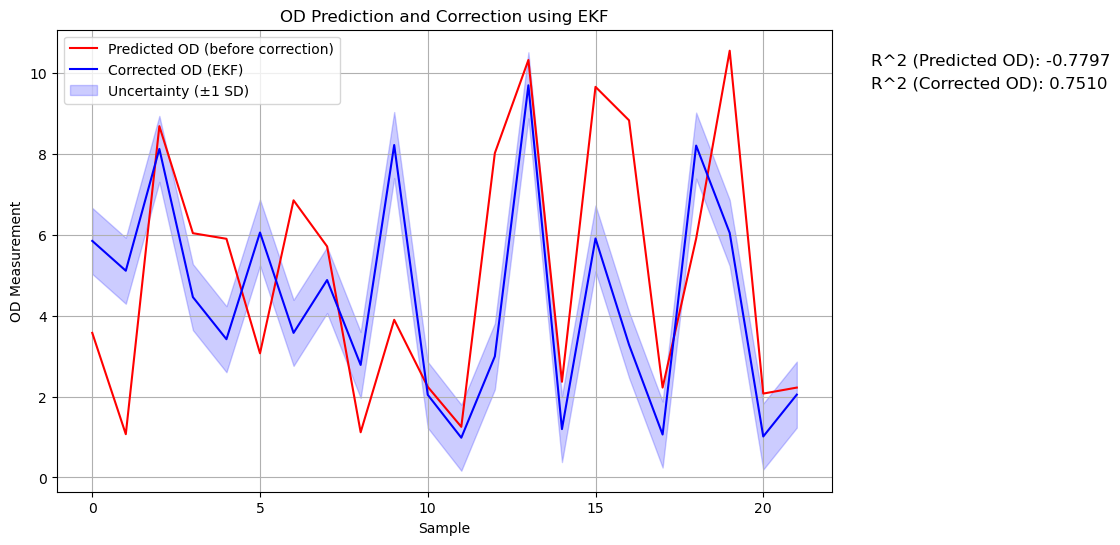

In [84]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define the ekf_predict function
def ekf_predict(x_prev, P_prev, F, Q):
    x_prev = np.array([x_prev])  # Convert scalar to 1D array if necessary
    x_pred = F @ x_prev.T  # Transpose x_prev to make it a column vector
    P_pred = F @ P_prev @ F.T + Q
    return x_pred, P_pred

# Define the ekf_update function
def ekf_update(x_pred, P_pred, z, H, R):
    y = z - (H @ x_pred)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_upd = x_pred + K @ y
    P_upd = (np.eye(len(K)) - K @ H) @ P_pred
    return x_upd, P_upd

# Load your data (assuming df_Raman_clean is already loaded)
# Split the data into training and testing sets
X_process_train, X_process_test, y_process_train, y_process_test = train_test_split(X_process, y_process, test_size=0.2, random_state=42)
X_Raman_train, X_Raman_test, y_Raman_train, y_Raman_test = train_test_split(X_Raman, y_Raman, test_size=0.2, random_state=42)

# Initialize the Random Forest models
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model_Raman = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the models
rf_model.fit(X_process_train, y_process_train)
rf_model_Raman.fit(X_Raman_train, y_Raman_train)

# Perform prediction and correction using EKF
n_Raman = len(X_Raman_test)
P = np.eye(1)
F = np.eye(1)
Q = np.eye(1)
H = np.eye(1)
R = np.eye(1)

x_preds = []
x_upds = []
P_upds = []  # Initialize list to store uncertainties
actual_OD = df_Raman_clean.loc[X_Raman_test.index, "OD- Offline measurement"].values

for i in range(n_Raman):
    # Prediction from rf_model
    x_prev = rf_model.predict(X_process_test.iloc[i:i+1])[0]
    
    # Prediction step in EKF
    x_pred, P_pred = ekf_predict(x_prev, P, F, Q)
    
    # Prediction from rf_model_Raman
    z = rf_model_Raman.predict(X_Raman_test.iloc[i:i+1])[0]
    
    # Update step in EKF
    x_upd, P_upd = ekf_update(x_pred, P_pred, z, H, R)
    
    # Store results
    x_preds.append(x_pred[0])
    x_upds.append(x_upd[0])
    P_upds.append(P_upd[0, 0])  # Assuming P_upd is a 1x1 matrix; adjust if it's larger

# Convert lists to numpy arrays
x_preds = np.array(x_preds)
x_upds = np.array(x_upds)
P_upds = np.array(P_upds)

# Calculate R^2 scores
r2_pred = r2_score(actual_OD, x_preds)
r2_upd = r2_score(actual_OD, x_upds)

print(f"R^2 Score for Predicted OD (before correction): {r2_pred:.4f}")
print(f"R^2 Score for Corrected OD (EKF): {r2_upd:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(n_Raman), x_preds, 'r-', label='Predicted OD (before correction)')
plt.plot(range(n_Raman), x_upds, 'b-', label='Corrected OD (EKF)')
plt.fill_between(range(n_Raman), x_upds - np.sqrt(P_upds), x_upds + np.sqrt(P_upds), color='blue', alpha=0.2, label='Uncertainty (±1 SD)')
plt.xlabel('Sample')
plt.ylabel('OD Measurement')
plt.title('OD Prediction and Correction using EKF')

# Display R^2 scores on the plot
plt.text(1.05, 0.95, f'R^2 (Predicted OD): {r2_pred:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(1.05, 0.90, f'R^2 (Corrected OD): {r2_upd:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.legend()
plt.grid(True)
plt.show()


#### Trial 2:

- Actual OD: 243 rows, not scaled.
- df_Raman_cleaned3: 243 rows
- X_process: 243 rows
- (however, since some of the Actual OD are interpolated from the RAMAN measurement files)
- potential issue: used X_process data, however, in real setting, all process parameters should be used, and also this data has been seen already, which cause very high prediction accuracy.

In [85]:
# Try to toggle this on/offif the code is not running. Drop the 'BatchID' column from df_Raman_cleaned3
df_Raman_cleaned3 = df_Raman_cleaned3.drop(columns=['BatchID'])
df_Raman_cleaned3 = df_Raman_cleaned3.rename(columns={'Age': 'Age (h)'})


In [86]:
df_Raman_cleaned3

Max1      Max2      Max3      Max4      Max5      Max6    Age (h)
0    5.863282  1.483690  0.293164  0.796074  2.927938  1.212130   0.000000
1    4.946474  1.499905  0.289281  0.783597  2.861098  1.184933   2.100000
2    4.920959  1.498602  0.281416  0.761361  2.834997  1.056845   3.166667
3    5.869157  1.526436  0.276953  0.747706  2.735640  1.121744   4.266667
4    5.234006  1.529197  0.266563  0.732086  2.755655  0.991809   5.333333
..        ...       ...       ...       ...       ...       ...        ...
238  5.556314  0.475437  0.107389  0.144852  1.961006  3.049581  24.000000
239  6.967318 -0.204087 -0.225534  0.274392  3.083424  2.938881  33.233333
240  7.174154 -0.213850 -0.090631 -0.014679  3.019546  3.118682  38.000000
241  6.945235 -0.207621 -0.119842  0.232199  1.112553  2.716811  43.466667
242  4.950044 -0.236521 -0.082413 -0.013536  1.273813  2.747120  48.000000

[243 rows x 7 columns]

R^2 Score for Predicted OD (before correction): 0.9515
R^2 Score for Predicted OD (rf_model_Raman): 0.7904
R^2 Score for Corrected OD (EKF): 0.8859


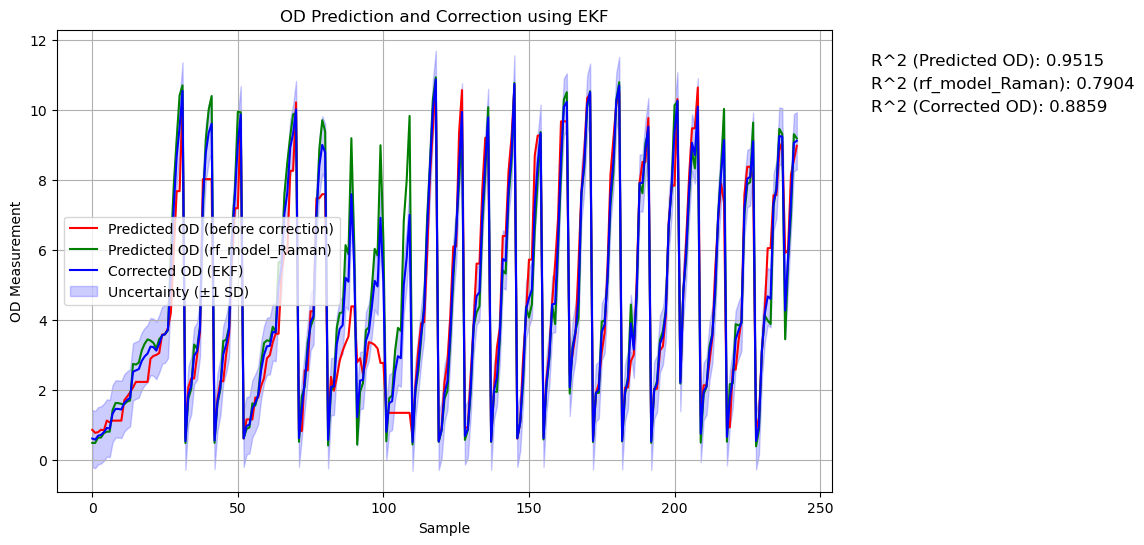

In [87]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define the ekf_predict function
def ekf_predict(x_prev, P_prev, F, Q):
    x_prev = np.array([x_prev])  # Convert scalar to 1D array if necessary
    x_pred = F @ x_prev.T  # Transpose x_prev to make it a column vector
    P_pred = F @ P_prev @ F.T + Q
    return x_pred, P_pred

# Define the ekf_update function
def ekf_update(x_pred, P_pred, z, H, R):
    y = z - (H @ x_pred)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_upd = x_pred + K @ y
    P_upd = (np.eye(len(K)) - K @ H) @ P_pred
    return x_upd, P_upd

# Assume df_merged is the merged DataFrame containing the actual OD measurements
# Extract actual OD measurements
actual_OD = df_merged["OD_Offline_measurement"].values

# Determine the number of samples to iterate over
n_Raman = min(len(X_process), len(df_Raman_cleaned3))

# Initialize matrices and lists for EKF
P = np.eye(1)
F = np.eye(1)
Q = np.eye(1)
H = np.eye(1)
R = np.eye(1)

x_preds = []
x_upds = []
rf_model_Raman_preds = []  # List to store predictions from rf_model_Raman
P_upds = []  # Initialize list to store uncertainties

# Loop over each sample
for i in range(n_Raman):
    # Prediction from rf_model (based on X_process)
    x_prev = rf_model.predict(X_process.iloc[i:i+1])[0]
    
    # Prediction step in EKF
    x_pred, P_pred = ekf_predict(x_prev, P, F, Q)
    
    # Prediction from rf_model_Raman (based on df_Raman_cleaned3)
    z = rf_model_Raman.predict(df_Raman_cleaned3.iloc[i:i+1])[0]
    rf_model_Raman_preds.append(z)
    
    # Update step in EKF
    x_upd, P_upd = ekf_update(x_pred, P_pred, z, H, R)
    
    # Store results
    x_preds.append(x_pred[0])
    x_upds.append(x_upd[0])
    P_upds.append(P_upd[0, 0])  # Assuming P_upd is a 1x1 matrix; adjust if it's larger

# Convert lists to numpy arrays
x_preds = np.array(x_preds)
x_upds = np.array(x_upds)
rf_model_Raman_preds = np.array(rf_model_Raman_preds)
P_upds = np.array(P_upds)

# Calculate R^2 scores
r2_pred = r2_score(actual_OD[:n_Raman], x_preds)
r2_rf_model_Raman = r2_score(actual_OD[:n_Raman], rf_model_Raman_preds)
r2_upd = r2_score(actual_OD[:n_Raman], x_upds)

print(f"R^2 Score for Predicted OD (before correction): {r2_pred:.4f}")
print(f"R^2 Score for Predicted OD (rf_model_Raman): {r2_rf_model_Raman:.4f}")
print(f"R^2 Score for Corrected OD (EKF): {r2_upd:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(n_Raman), x_preds, 'r-', label='Predicted OD (before correction)')
plt.plot(range(n_Raman), rf_model_Raman_preds, 'g-', label='Predicted OD (rf_model_Raman)')
plt.plot(range(n_Raman), x_upds, 'b-', label='Corrected OD (EKF)')
plt.fill_between(range(n_Raman), x_upds - np.sqrt(P_upds), x_upds + np.sqrt(P_upds), color='blue', alpha=0.2, label='Uncertainty (±1 SD)')
plt.xlabel('Sample')
plt.ylabel('OD Measurement')
plt.title('OD Prediction and Correction using EKF')

# Display R^2 scores on the plot
plt.text(1.05, 0.95, f'R^2 (Predicted OD): {r2_pred:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(1.05, 0.90, f'R^2 (rf_model_Raman): {r2_rf_model_Raman:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(1.05, 0.85, f'R^2 (Corrected OD): {r2_upd:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.legend()
plt.grid(True)
plt.show()


#### Tiral 5:

R^2 Score for Predicted OD (before correction): 0.9534
R^2 Score for Predicted OD (rf_model_Raman): 0.9692
R^2 Score for Corrected OD (EKF): 0.9744


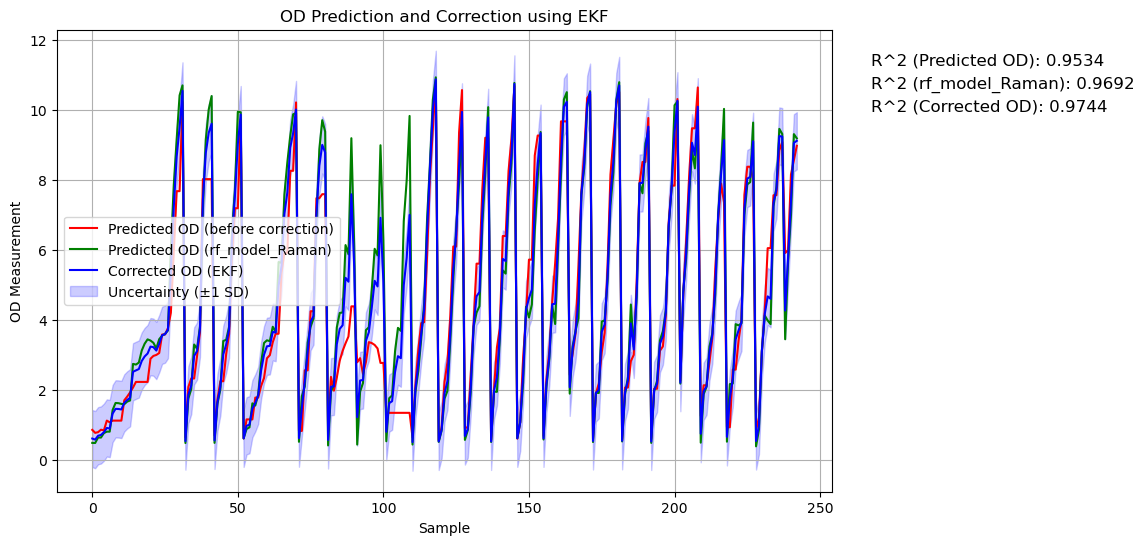

In [88]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define the ekf_predict function
def ekf_predict(x_prev, P_prev, F, Q):
    x_prev = np.array([x_prev])  # Convert scalar to 1D array if necessary
    x_pred = F @ x_prev.T  # Transpose x_prev to make it a column vector
    P_pred = F @ P_prev @ F.T + Q
    return x_pred, P_pred

# Define the ekf_update function
def ekf_update(x_pred, P_pred, z, H, R):
    y = z - (H @ x_pred)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_upd = x_pred + K @ y
    P_upd = (np.eye(len(K)) - K @ H) @ P_pred
    return x_upd, P_upd

# Extract actual OD measurements
#actual_OD = df_merged["OD_Offline_measurement"].values
actual_OD = df_Raman["OD- Offline measurement"].values
# Determine the number of samples to iterate over
n_Raman = min(len(X_process), len(df_Raman_cleaned3))

# Initialize matrices and lists for EKF
P = np.eye(1)
F = np.eye(1)
Q = np.eye(1)
H = np.eye(1)
R = np.eye(1)

x_preds = []
x_upds = []
rf_model_Raman_preds = []  # List to store predictions from rf_model_Raman
P_upds = []  # Initialize list to store uncertainties

# Loop over each sample
for i in range(n_Raman):
    # Prediction from rf_model (based on X_process)
    x_prev = rf_model.predict(X_process.iloc[i:i+1])[0]
    
    # Prediction step in EKF
    x_pred, P_pred = ekf_predict(x_prev, P, F, Q)
    
    # Prediction from rf_model_Raman (based on df_Raman_cleaned3)
    z = rf_model_Raman.predict(df_Raman_cleaned3.iloc[i:i+1])[0]
    rf_model_Raman_preds.append(z)
    
    # Update step in EKF
    x_upd, P_upd = ekf_update(x_pred, P_pred, z, H, R)
    
    # Store results
    x_preds.append(x_pred[0])
    x_upds.append(x_upd[0])
    P_upds.append(P_upd[0, 0])  # Assuming P_upd is a 1x1 matrix; adjust if it's larger

# Convert lists to numpy arrays
x_preds = np.array(x_preds)
x_upds = np.array(x_upds)
rf_model_Raman_preds = np.array(rf_model_Raman_preds)
P_upds = np.array(P_upds)

# Create the OD_results DataFrame
OD_results = pd.DataFrame({
    'Actual_OD': actual_OD[:n_Raman],
    'Predicted_OD_before_Correction': x_preds,
    'RF_Model_Raman_Prediction': rf_model_Raman_preds,
    'Corrected_OD': x_upds
})

# Drop rows where Actual_OD is NaN for R^2 calculation
valid_indices = ~np.isnan(OD_results['Actual_OD'])
actual_OD_valid = OD_results['Actual_OD'][valid_indices]
x_preds_valid = OD_results['Predicted_OD_before_Correction'][valid_indices]
rf_model_Raman_preds_valid = OD_results['RF_Model_Raman_Prediction'][valid_indices]
x_upds_valid = OD_results['Corrected_OD'][valid_indices]

# Calculate R^2 scores
r2_pred = r2_score(actual_OD_valid, x_preds_valid)
r2_rf_model_Raman = r2_score(actual_OD_valid, rf_model_Raman_preds_valid)
r2_upd = r2_score(actual_OD_valid, x_upds_valid)

print(f"R^2 Score for Predicted OD (before correction): {r2_pred:.4f}")
print(f"R^2 Score for Predicted OD (rf_model_Raman): {r2_rf_model_Raman:.4f}")
print(f"R^2 Score for Corrected OD (EKF): {r2_upd:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(n_Raman), x_preds, 'r-', label='Predicted OD (before correction)')
plt.plot(range(n_Raman), rf_model_Raman_preds, 'g-', label='Predicted OD (rf_model_Raman)')
plt.plot(range(n_Raman), x_upds, 'b-', label='Corrected OD (EKF)')
plt.fill_between(range(n_Raman), x_upds - np.sqrt(P_upds), x_upds + np.sqrt(P_upds), color='blue', alpha=0.2, label='Uncertainty (±1 SD)')
plt.xlabel('Sample')
plt.ylabel('OD Measurement')
plt.title('OD Prediction and Correction using EKF')

# Display R^2 scores on the plot
plt.text(1.05, 0.95, f'R^2 (Predicted OD): {r2_pred:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(1.05, 0.90, f'R^2 (rf_model_Raman): {r2_rf_model_Raman:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(1.05, 0.85, f'R^2 (Corrected OD): {r2_upd:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.legend()
plt.grid(True)
plt.show()


Dataset:
- Raman_features_for_model: Raman data for prediction. The Age (h) has been converted to the closet Age in process parameters data.(188 rows × 7 columns). Extracted from: Raman_adjusted
- df_true_pivot_features_scaled: 440067 rows × 18 columns. extracted from: df_true_pivot_features_scaled_v2
- Raman_adjusted (188 rows × 8 columns)
- df_true_pivot_features_scaled_v2 (40067 rows × 20 columns)
- df_merged: where OD_offline_measuremnt is stored
- rf_model: prediction model
- rf_model_Raman: observation model


#### Trial 3: 

In [89]:
import pandas as pd

# Assuming df_true_pivot_clean and df_true_pivot_features_scaled are already defined

# Extract 'SAP' and 'Age' columns from df_true_pivot_clean
df_sap_age = df_true_pivot_clean[['SAP', 'Age']].copy()

# Add these columns to df_true_pivot_features_scaled
df_true_pivot_features_scaled_v2 = df_true_pivot_features_scaled.copy()
df_true_pivot_features_scaled_v2['SAP'] = df_sap_age['SAP']
df_true_pivot_features_scaled_v2['Age'] = df_sap_age['Age']

# Display the first few rows of the new DataFrame to verify
df_true_pivot_features_scaled_v2


Acid_Tank_Weight  Agitator_VFD_Current_Value  Airflow_Current_Value  \
0              1.151515                   -2.971734              -0.666176   
1              1.151568                   -2.959059              -1.164549   
2              1.151278                   -2.946518              -1.163210   
3              1.151942                   -2.933979              -1.165621   
4              1.151639                   -2.921444              -1.159191   
...                 ...                         ...                    ...   
40062         -1.690611                    0.258889               1.266586   
40063         -1.694472                    0.258890               1.268372   
40064         -1.697124                    0.258891               1.268372   
40065         -1.698783                    0.258892               1.263013   
40066         -1.702762                    0.258893               1.284449   

       Antifoam_Tank_Temperature  Antifoam_Tank_Weight  Dissolved_Oxygen  \
0                       0.328248              1.848329          2.534552   
1                       0.328435              1.812997         -0.863953   
2                       0.326914              1.810918         -1.520808   
3                       0.328451              1.810696         -1.095769   
4                       0.326549              1.813403         -0.859336   
...                          ...                   ...               ...   
40062                  -1.090701             -1.825305          0.240906   
40063                  -1.094363             -1.823152          0.032481   
40064                  -1.095927             -1.808084          0.095663   
40065                  -1.101680             -1.808604          0.260999   
40066                  -1.104593             -1.817177          0.149677   

       Fermentor_Skid_Pressure  Fermentor_Skid_Temperature  Fermentor_Weight  \
0                    -0.056213                    0.152723         -0.891786   
1                    -0.119530                    0.187117         -0.887038   
2                    -0.119559                    0.201416         -0.880250   
3                    -0.119588                    0.123088         -0.881666   
4                    -0.119618                    0.041321         -0.881563   
...                        ...                         ...               ...   
40062                 0.216211                    0.012490          2.214746   
40063                 0.217545                    0.038702          2.222642   
40064                 0.218879                    0.009477          2.218189   
40065                 0.220213                    0.058908          2.226386   
40066                 0.221547                   -0.003249          2.227095   

       Fermentor_pH_Probe_A  Fermentor_pH_Probe_B  Gas_Analyzer_CER Ratio  \
0                  0.105481              0.054801               -0.939266   
1                  0.105435              0.037485               -0.939266   
2                  0.055837              0.019601               -0.939266   
3                  0.022945             -0.000568               -0.939266   
4                 -0.014700             -0.041880               -0.939266   
...                     ...                   ...                     ...   
40062              0.045286              0.321628                1.301883   
40063              0.021990              0.301923                1.301883   
40064              0.060870              0.313118                1.301883   
40065              0.011021              0.309231                1.301883   
40066              0.034422              0.312071                1.301883   

       Gas_Analyzer_OUR Ratio  Jacket_Temperature  Oxygen Gas (%)  \
0                   -0.853895            0.939419        0.971967   
1                   -0.853895            1.335184        0.930033   
2                   -0.906068            0.680504        0.88810

In [90]:
df_Raman_cleaned3.rename(columns={'Age (h)': 'Age'}, inplace=True)


In [91]:
df_Raman_cleaned4

Primary ID    BatchID    Age(hr)      Max1      Max2  \
0                3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
1              3CA3683-2.1    3CA3683   2.100000  4.946474  1.499905   
2      3CA3683-3.166666667    3CA3683   3.166667  4.920959  1.498602   
3      3CA3683-4.266666667    3CA3683   4.266667  5.869157  1.526436   
4      3CA3683-5.333333333    3CA3683   5.333333  5.234006  1.529197   
..                     ...        ...        ...       ...       ...   
238           NCDCA5242-24  NCDCA5242  24.000000  5.556314  0.475437   
239  NCDCA5242-33.23333333  NCDCA5242  33.233333  6.967318 -0.204087   
240           NCDCA5242-38  NCDCA5242  38.000000  7.174154 -0.213850   
241  NCDCA5242-43.46666667  NCDCA5242  43.466667  6.945235 -0.207621   
242           NCDCA5242-48  NCDCA5242  48.000000  4.950044 -0.236521   

         Max3      Max4      Max5      Max6  OD- Offline measurement  \
0    0.293164  0.796074  2.927938  1.212130                    0.492   
1    0.289281  0.783597  2.861098  1.184933                      NaN   
2    0.281416  0.761361  2.834997  1.056845                      NaN   
3    0.276953  0.747706  2.735640  1.121744                      NaN   
4    0.266563  0.732086  2.755655  0.991809                      NaN   
..        ...       ...       ...       ...                      ...   
238  0.107389  0.144852  1.961006  3.049581                    3.560   
239 -0.225534  0.274392  3.083424  2.938881                      NaN   
240 -0.090631 -0.014679  3.019546  3.118682                      NaN   
241 -0.119842  0.232199  1.112553  2.716811                      NaN   
242 -0.082413 -0.013536  1.273813  2.747120                    9.080   

     prediction  
0       0.48270  
1       0.47925  
2       0.63566  
3       0.63497  
4       0.76210  
..          ...  
238     3.44170  
239     5.64170  
240     6.99400  
241     9.29860  
242     9.17860  

[243 rows x 11 columns]

Convert the Age(hr) to the closest multiples of 0.03

In [92]:
import pandas as pd

# Assuming df_Raman_cleaned4 is your original DataFrame
# Example DataFrame creation for demonstration
# df_Raman_cleaned4 = pd.read_csv("path_to_your_file.csv")

# Define a function to round values to the nearest multiple of 0.03
def round_to_nearest_multiple(x, multiple=0.03):
    return round(x / multiple) * multiple

# Create a copy of the original DataFrame to make adjustments
df_Raman_cleaned5 = df_Raman_cleaned4.copy()

# Apply the rounding function to the 'Age(hr)' column in the new DataFrame
df_Raman_cleaned5['Age(hr)'] = df_Raman_cleaned5['Age(hr)'].apply(round_to_nearest_multiple)

# Optionally, save the new DataFrame to a CSV file
# df_Raman_cleaned5.to_csv("df_Raman_cleaned5.csv", index=False)
df_Raman_cleaned5.rename(columns={'Age(hr)': 'Age (h)'}, inplace=True)
# Display the new DataFrame with adjusted values
df_Raman_cleaned5

Primary ID    BatchID  Age (h)      Max1      Max2      Max3  \
0                3CA3683-0    3CA3683     0.00  5.863282  1.483690  0.293164   
1              3CA3683-2.1    3CA3683     2.10  4.946474  1.499905  0.289281   
2      3CA3683-3.166666667    3CA3683     3.18  4.920959  1.498602  0.281416   
3      3CA3683-4.266666667    3CA3683     4.26  5.869157  1.526436  0.276953   
4      3CA3683-5.333333333    3CA3683     5.34  5.234006  1.529197  0.266563   
..                     ...        ...      ...       ...       ...       ...   
238           NCDCA5242-24  NCDCA5242    24.00  5.556314  0.475437  0.107389   
239  NCDCA5242-33.23333333  NCDCA5242    33.24  6.967318 -0.204087 -0.225534   
240           NCDCA5242-38  NCDCA5242    38.01  7.174154 -0.213850 -0.090631   
241  NCDCA5242-43.46666667  NCDCA5242    43.47  6.945235 -0.207621 -0.119842   
242           NCDCA5242-48  NCDCA5242    48.00  4.950044 -0.236521 -0.082413   

         Max4      Max5      Max6  OD- Offline measurement  prediction  
0    0.796074  2.927938  1.212130                    0.492     0.48270  
1    0.783597  2.861098  1.184933                      NaN     0.47925  
2    0.761361  2.834997  1.056845                      NaN     0.63566  
3    0.747706  2.735640  1.121744                      NaN     0.63497  
4    0.732086  2.755655  0.991809                      NaN     0.76210  
..        ...       ...       ...                      ...         ...  
238  0.144852  1.961006  3.049581                    3.560     3.44170  
239  0.274392  3.083424  2.938881                      NaN     5.64170  
240 -0.014679  3.019546  3.118682                      NaN     6.99400  
241  0.232199  1.112553  2.716811                      NaN     9.29860  
242 -0.013536  1.273813  2.747120                    9.080     9.17860  

[243 rows x 11 columns]

In [93]:
import pandas as pd

# Assuming df_Raman_cleaned5 is your DataFrame
# Example DataFrame creation for demonstration
# df_Raman_cleaned5 = pd.read_csv("path_to_your_file.csv")

# Get the list of columns
columns = df_Raman_cleaned5.columns.tolist()

# Remove 'Age (h)' from its current position
columns.remove('Age (h)')

# Append 'Age (h)' to the end of the columns list
columns.append('Age (h)')

# Reorder the DataFrame columns
df_Raman_cleaned5 = df_Raman_cleaned5[columns]

# Display the DataFrame to verify the column reordering
df_Raman_cleaned5

# Optionally, save the DataFrame with the reordered columns to a CSV file
# df_Raman_cleaned5.to_csv("df_Raman_cleaned5.csv", index=False)


Primary ID    BatchID      Max1      Max2      Max3      Max4  \
0                3CA3683-0    3CA3683  5.863282  1.483690  0.293164  0.796074   
1              3CA3683-2.1    3CA3683  4.946474  1.499905  0.289281  0.783597   
2      3CA3683-3.166666667    3CA3683  4.920959  1.498602  0.281416  0.761361   
3      3CA3683-4.266666667    3CA3683  5.869157  1.526436  0.276953  0.747706   
4      3CA3683-5.333333333    3CA3683  5.234006  1.529197  0.266563  0.732086   
..                     ...        ...       ...       ...       ...       ...   
238           NCDCA5242-24  NCDCA5242  5.556314  0.475437  0.107389  0.144852   
239  NCDCA5242-33.23333333  NCDCA5242  6.967318 -0.204087 -0.225534  0.274392   
240           NCDCA5242-38  NCDCA5242  7.174154 -0.213850 -0.090631 -0.014679   
241  NCDCA5242-43.46666667  NCDCA5242  6.945235 -0.207621 -0.119842  0.232199   
242           NCDCA5242-48  NCDCA5242  4.950044 -0.236521 -0.082413 -0.013536   

         Max5      Max6  OD- Offline measurement  prediction  Age (h)  
0    2.927938  1.212130                    0.492     0.48270     0.00  
1    2.861098  1.184933                      NaN     0.47925     2.10  
2    2.834997  1.056845                      NaN     0.63566     3.18  
3    2.735640  1.121744                      NaN     0.63497     4.26  
4    2.755655  0.991809                      NaN     0.76210     5.34  
..        ...       ...                      ...         ...      ...  
238  1.961006  3.049581                    3.560     3.44170    24.00  
239  3.083424  2.938881                      NaN     5.64170    33.24  
240  3.019546  3.118682                      NaN     6.99400    38.01  
241  1.112553  2.716811                      NaN     9.29860    43.47  
242  1.273813  2.747120                    9.080     9.17860    48.00  

[243 rows x 11 columns]

In [94]:
merged_df_v2 = pd.merge(df_Raman_cleaned4, df_true_pivot_features_scaled_v2[['SAP', 'Age']], 
                        left_on='BatchID', right_on='SAP', how='left')
merged_df_v2

Primary ID    BatchID    Age(hr)      Max1      Max2  \
0                   3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
1                   3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
2                   3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
3                   3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
4                   3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
...                       ...        ...        ...       ...       ...   
276502           NCDCA5242-24  NCDCA5242  24.000000  5.556314  0.475437   
276503  NCDCA5242-33.23333333  NCDCA5242  33.233333  6.967318 -0.204087   
276504           NCDCA5242-38  NCDCA5242  38.000000  7.174154 -0.213850   
276505  NCDCA5242-43.46666667  NCDCA5242  43.466667  6.945235 -0.207621   
276506           NCDCA5242-48  NCDCA5242  48.000000  4.950044 -0.236521   

            Max3      Max4      Max5      Max6  OD- Offline measurement  \
0       0.293164  0.796074  2.927938  1.212130                    0.492   
1       0.293164  0.796074  2.927938  1.212130                    0.492   
2       0.293164  0.796074  2.927938  1.212130                    0.492   
3       0.293164  0.796074  2.927938  1.212130                    0.492   
4       0.293164  0.796074  2.927938  1.212130                    0.492   
...          ...       ...       ...       ...                      ...   
276502  0.107389  0.144852  1.961006  3.049581                    3.560   
276503 -0.225534  0.274392  3.083424  2.938881                      NaN   
276504 -0.090631 -0.014679  3.019546  3.118682                      NaN   
276505 -0.119842  0.232199  1.112553  2.716811                      NaN   
276506 -0.082413 -0.013536  1.273813  2.747120                    9.080   

        prediction      SAP   Age  
0           0.4827  3CA3683  0.00  
1           0.4827  3CA3683  0.03  
2           0.4827  3CA3683  0.07  
3           0.4827  3CA3683  0.10  
4           0.4827  3CA3683  0.13  
...            ...      ...   ...  
276502      3.4417      NaN   NaN  
276503      5.6417      NaN   NaN  
276504      6.9940      NaN   NaN  
276505      9.2986      NaN   NaN  
276506      9.1786      NaN   NaN  

[276507 rows x 13 columns]

In [95]:
# Calculate Age difference
#merged_df_v2['Age_Difference'] = merged_df_v2['Age_y'] - merged_df_v2['Age_x']
merged_df_v2['Age_Difference'] = merged_df_v2['Age'] - merged_df_v2['Age(hr)']
#merged_df_v2_cleaned = merged_df_v2.dropna()
merged_df_v2_cleaned=merged_df_v2
merged_df_v2_cleaned

Primary ID    BatchID    Age(hr)      Max1      Max2  \
0                   3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
1                   3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
2                   3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
3                   3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
4                   3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
...                       ...        ...        ...       ...       ...   
276502           NCDCA5242-24  NCDCA5242  24.000000  5.556314  0.475437   
276503  NCDCA5242-33.23333333  NCDCA5242  33.233333  6.967318 -0.204087   
276504           NCDCA5242-38  NCDCA5242  38.000000  7.174154 -0.213850   
276505  NCDCA5242-43.46666667  NCDCA5242  43.466667  6.945235 -0.207621   
276506           NCDCA5242-48  NCDCA5242  48.000000  4.950044 -0.236521   

            Max3      Max4      Max5      Max6  OD- Offline measurement  \
0       0.293164  0.796074  2.927938  1.212130                    0.492   
1       0.293164  0.796074  2.927938  1.212130                    0.492   
2       0.293164  0.796074  2.927938  1.212130                    0.492   
3       0.293164  0.796074  2.927938  1.212130                    0.492   
4       0.293164  0.796074  2.927938  1.212130                    0.492   
...          ...       ...       ...       ...                      ...   
276502  0.107389  0.144852  1.961006  3.049581                    3.560   
276503 -0.225534  0.274392  3.083424  2.938881                      NaN   
276504 -0.090631 -0.014679  3.019546  3.118682                      NaN   
276505 -0.119842  0.232199  1.112553  2.716811                      NaN   
276506 -0.082413 -0.013536  1.273813  2.747120                    9.080   

        prediction      SAP   Age  Age_Difference  
0           0.4827  3CA3683  0.00            0.00  
1           0.4827  3CA3683  0.03            0.03  
2           0.4827  3CA3683  0.07            0.07  
3           0.4827  3CA3683  0.10            0.10  
4           0.4827  3CA3683  0.13            0.13  
...            ...      ...   ...             ...  
276502      3.4417      NaN   NaN             NaN  
276503      5.6417      NaN   NaN             NaN  
276504      6.9940      NaN   NaN             NaN  
276505      9.2986      NaN   NaN             NaN  
276506      9.1786      NaN   NaN             NaN  

[276507 rows x 14 columns]

In [96]:
# Step 2: Create a new column with absolute Age_Difference
merged_df_v2_cleaned['Absolute_Age_Difference'] = merged_df_v2_cleaned['Age_Difference'].abs()

# Step 3: Sort by BatchID, Age (h), and Absolute_Age_Difference
#merged_df_v2_cleaned = merged_df_v2_cleaned.sort_values(by=['BatchID', 'Age_x', 'Absolute_Age_Difference'])
merged_df_v2_cleaned = merged_df_v2_cleaned.sort_values(by=['BatchID', 'Age(hr)', 'Absolute_Age_Difference'])
# Step 4: Drop duplicates, keeping the row with the smallest absolute Age_Difference
#merged_df_v2_cleaned = merged_df_v2_cleaned.drop_duplicates(subset=['BatchID', 'Age_x'], keep='first')
#merged_df_v2_cleaned = merged_df_v2_cleaned.drop_duplicates(subset=['BatchID', 'Age(hr)'], keep='first')


# Keep only the rows where Age_Difference is non-negative
merged_df_v2_cleaned = merged_df_v2_cleaned[merged_df_v2_cleaned['Absolute_Age_Difference'] < 0.03]
#merged_df_v2_cleaned = merged_df_v2_cleaned.drop_duplicates(subset=['BatchID', 'Age(hr)'], keep='first')
merged_df_v2_cleaned

Primary ID    BatchID    Age(hr)      Max1      Max2  \
0                   3CA3683-0    3CA3683   0.000000  5.863282  1.483690   
1528              3CA3683-2.1    3CA3683   2.100000  4.946474  1.499905   
1529              3CA3683-2.1    3CA3683   2.100000  4.946474  1.499905   
3025      3CA3683-3.166666667    3CA3683   3.166667  4.920959  1.498602   
4523      3CA3683-4.266666667    3CA3683   4.266667  5.869157  1.526436   
...                       ...        ...        ...       ...       ...   
272142           NCDCA2217-10  NCDCA2217  10.000000  5.956877  1.844516   
272141           NCDCA2217-10  NCDCA2217  10.000000  5.956877  1.844516   
272143           NCDCA2217-10  NCDCA2217  10.000000  5.956877  1.844516   
272880  NCDCA2217-15.28333333  NCDCA2217  15.283333  6.044321  1.957714   
272881  NCDCA2217-15.28333333  NCDCA2217  15.283333  6.044321  1.957714   

            Max3      Max4      Max5      Max6  OD- Offline measurement  \
0       0.293164  0.796074  2.927938  1.212130                    0.492   
1528    0.289281  0.783597  2.861098  1.184933                      NaN   
1529    0.289281  0.783597  2.861098  1.184933                      NaN   
3025    0.281416  0.761361  2.834997  1.056845                      NaN   
4523    0.276953  0.747706  2.735640  1.121744                      NaN   
...          ...       ...       ...       ...                      ...   
272142  0.324910  0.757625  2.772036  1.062028                    1.980   
272141  0.324910  0.757625  2.772036  1.062028                    1.980   
272143  0.324910  0.757625  2.772036  1.062028                    1.980   
272880  0.318983  0.667611  2.669267  1.143320                      NaN   
272881  0.318983  0.667611  2.669267  1.143320                      NaN   

        prediction        SAP    Age  Age_Difference  Absolute_Age_Difference  
0          0.48270    3CA3683   0.00        0.000000                 0.000000  
1528       0.47925    3CA3683   2.10        0.000000                 0.000000  
1529       0.47925    3CA3683   2.13        0.030000                 0.030000  
3025       0.63566    3CA3683   3.17        0.003333                 0.003333  
4523       0.63497    3CA3683   4.27        0.003333                 0.003333  
...            ...        ...    ...             ...                      ...  
272142     1.87130  NCDCA2217  10.00        0.000000                 0.000000  
272141     1.87130  NCDCA2217   9.97       -0.030000                 0.030000  
272143     1.87130  NCDCA2217  10.03        0.030000                 0.030000  
272880     2.08470  NCDCA2217  15.27       -0.013333                 0.013333  
272881     2.08470  NCDCA2217  15.30        0.016667                 0.016667  

[265 rows x 15 columns]

In [97]:
# Drop the columns Age_x, Age_Difference, and Absolute_Age_Difference
#Raman_adjusted = merged_df_v2_cleaned.drop(columns=['Age_x', 'SAP','Age_Difference', 'Absolute_Age_Difference'])
Raman_adjusted = merged_df_v2_cleaned.drop(columns=['Primary ID','Age(hr)', 'SAP','Age_Difference', 'Absolute_Age_Difference'])
# Rename the 'Age_y' column to 'Age (h)' in Raman_adjusted
#Raman_adjusted = Raman_adjusted.rename(columns={'Age_y': 'Age (h)'})
Raman_adjusted = Raman_adjusted.rename(columns={'Age': 'Age (h)'})
# Display the first few rows to confirm the change
Raman_adjusted
#merged_df_v2_cleaned

BatchID      Max1      Max2      Max3      Max4      Max5      Max6  \
0         3CA3683  5.863282  1.483690  0.293164  0.796074  2.927938  1.212130   
1528      3CA3683  4.946474  1.499905  0.289281  0.783597  2.861098  1.184933   
1529      3CA3683  4.946474  1.499905  0.289281  0.783597  2.861098  1.184933   
3025      3CA3683  4.920959  1.498602  0.281416  0.761361  2.834997  1.056845   
4523      3CA3683  5.869157  1.526436  0.276953  0.747706  2.735640  1.121744   
...           ...       ...       ...       ...       ...       ...       ...   
272142  NCDCA2217  5.956877  1.844516  0.324910  0.757625  2.772036  1.062028   
272141  NCDCA2217  5.956877  1.844516  0.324910  0.757625  2.772036  1.062028   
272143  NCDCA2217  5.956877  1.844516  0.324910  0.757625  2.772036  1.062028   
272880  NCDCA2217  6.044321  1.957714  0.318983  0.667611  2.669267  1.143320   
272881  NCDCA2217  6.044321  1.957714  0.318983  0.667611  2.669267  1.143320   

        OD- Offline measurement  prediction  Age (h)  
0                         0.492     0.48270     0.00  
1528                        NaN     0.47925     2.10  
1529                        NaN     0.47925     2.13  
3025                        NaN     0.63566     3.17  
4523                        NaN     0.63497     4.27  
...                         ...         ...      ...  
272142                    1.980     1.87130    10.00  
272141                    1.980     1.87130     9.97  
272143                    1.980     1.87130    10.03  
272880                      NaN     2.08470    15.27  
272881                      NaN     2.08470    15.30  

[265 rows x 10 columns]

In [98]:
# Select the features for the model
Raman_features_for_model = Raman_adjusted[['Max1', 'Max2', 'Max3', 'Max4', 'Max5', 'Max6', 'Age (h)']]
Raman_features_for_model

Max1      Max2      Max3      Max4      Max5      Max6  Age (h)
0       5.863282  1.483690  0.293164  0.796074  2.927938  1.212130     0.00
1528    4.946474  1.499905  0.289281  0.783597  2.861098  1.184933     2.10
1529    4.946474  1.499905  0.289281  0.783597  2.861098  1.184933     2.13
3025    4.920959  1.498602  0.281416  0.761361  2.834997  1.056845     3.17
4523    5.869157  1.526436  0.276953  0.747706  2.735640  1.121744     4.27
...          ...       ...       ...       ...       ...       ...      ...
272142  5.956877  1.844516  0.324910  0.757625  2.772036  1.062028    10.00
272141  5.956877  1.844516  0.324910  0.757625  2.772036  1.062028     9.97
272143  5.956877  1.844516  0.324910  0.757625  2.772036  1.062028    10.03
272880  6.044321  1.957714  0.318983  0.667611  2.669267  1.143320    15.27
272881  6.044321  1.957714  0.318983  0.667611  2.669267  1.143320    15.30

[265 rows x 7 columns]

In [99]:
Raman_adjusted

BatchID      Max1      Max2      Max3      Max4      Max5      Max6  \
0         3CA3683  5.863282  1.483690  0.293164  0.796074  2.927938  1.212130   
1528      3CA3683  4.946474  1.499905  0.289281  0.783597  2.861098  1.184933   
1529      3CA3683  4.946474  1.499905  0.289281  0.783597  2.861098  1.184933   
3025      3CA3683  4.920959  1.498602  0.281416  0.761361  2.834997  1.056845   
4523      3CA3683  5.869157  1.526436  0.276953  0.747706  2.735640  1.121744   
...           ...       ...       ...       ...       ...       ...       ...   
272142  NCDCA2217  5.956877  1.844516  0.324910  0.757625  2.772036  1.062028   
272141  NCDCA2217  5.956877  1.844516  0.324910  0.757625  2.772036  1.062028   
272143  NCDCA2217  5.956877  1.844516  0.324910  0.757625  2.772036  1.062028   
272880  NCDCA2217  6.044321  1.957714  0.318983  0.667611  2.669267  1.143320   
272881  NCDCA2217  6.044321  1.957714  0.318983  0.667611  2.669267  1.143320   

        OD- Offline measurement  prediction  Age (h)  
0                         0.492     0.48270     0.00  
1528                        NaN     0.47925     2.10  
1529                        NaN     0.47925     2.13  
3025                        NaN     0.63566     3.17  
4523                        NaN     0.63497     4.27  
...                         ...         ...      ...  
272142                    1.980     1.87130    10.00  
272141                    1.980     1.87130     9.97  
272143                    1.980     1.87130    10.03  
272880                      NaN     2.08470    15.27  
272881                      NaN     2.08470    15.30  

[265 rows x 10 columns]

In [100]:
import pandas as pd


# Specify the columns to consider for identifying duplicates
#columns_to_check = ['BatchID', 'Max1', 'Max2', 'Max3', 'Max4', 'Max5', 'Max6']
columns_to_check = ['Max6']
# Sort by 'Age (h)' in ascending order so that the smallest age comes first
Raman_adjusted_sorted = Raman_adjusted.sort_values(by='Age (h)')

# Drop duplicates, keeping the first occurrence (which is the row with the smallest 'Age (h)')
Raman_adjusted_filtered = Raman_adjusted_sorted.drop_duplicates(subset=columns_to_check, keep='first')

# Reset index if needed
Raman_adjusted_filtered.reset_index(drop=True, inplace=True)

# Save the filtered DataFrame to a new CSV file (optional)
# Raman_adjusted_filtered.to_csv("filtered_Raman_adjusted.csv", index=False)
#Raman_adjusted=Raman_adjusted_filtered

In [101]:
Raman_adjusted_filtered

BatchID      Max1      Max2      Max3      Max4      Max5      Max6  \
0      3CA3683  5.863282  1.483690  0.293164  0.796074  2.927938  1.212130   
1    NCDCA1345  1.723686  3.501845  0.500143  1.071297  3.569463  1.519859   
2    NCDCA1235  5.555192  1.796908  0.371242  0.851484  2.991474  1.047489   
3      3CA3684  4.712062  1.724338  0.373141  0.869619  3.250513  1.316657   
4    NCDCA1083  5.276529  1.970633  0.378081  0.852577  3.383364  1.142364   
..         ...       ...       ...       ...       ...       ...       ...   
178  NCDCA1347  6.166657  2.736100  0.223447  0.482784  1.969749  0.666986   
179  NCDCA1747  0.999370  4.489366  0.539668  0.881052  3.956554  1.722191   
180  NCDCA1345  1.307042  4.411895  0.524468  0.904560  3.883878  1.759125   
181    3CA4397  4.991594  4.844951  0.041293  0.269385  1.533076  3.613872   
182    3CA4397  4.852972  5.053305 -0.034955  0.175475  1.196722  4.047950   

     OD- Offline measurement  prediction  Age (h)  
0                      0.492     0.48270      0.0  
1                      0.443     0.52348      0.0  
2                      0.453     0.50689      0.0  
3                      0.476     0.47885      0.0  
4                      0.632     0.57929      0.0  
..                       ...         ...      ...  
178                   10.080    10.22740     49.0  
179                   10.960     9.80560     50.0  
180                    9.640     9.38910     50.0  
181                      NaN     9.86510     50.1  
182                   10.920     9.90070     52.0  

[183 rows x 10 columns]

#### Filter for the Batch of interest

In [102]:
import pandas as pd

# Raman_adjusted_filtered = pd.read_csv("path_to_filtered_file.csv")

# Filter the DataFrame for rows where BatchID is "3CA4397"
batch_id_filtered = Raman_adjusted_filtered[Raman_adjusted_filtered['BatchID'] == '3CA4397']

# Print the filtered DataFrame
#print(Raman_adjusted_filtered[Raman_adjusted_filtered['BatchID'] == '3CA4397'])
batch_id_filtered

BatchID      Max1      Max2      Max3      Max4      Max5      Max6  \
8    3CA4397  4.190692  4.218709  0.236708  0.751268  2.698060  2.948951   
124  3CA4397  4.000916  4.580905  0.300021  0.492991  2.721203  2.771604   
128  3CA4397  4.062434  4.591376  0.312853  0.530032  2.691319  2.688795   
148  3CA4397  3.864521  4.826125  0.359884  0.618850  2.868415  2.787246   
158  3CA4397  3.454961  4.810546  0.453570  0.820141  3.398498  2.526660   
165  3CA4397  2.910526  4.564409  0.505296  0.917517  3.519350  2.361023   
181  3CA4397  4.991594  4.844951  0.041293  0.269385  1.533076  3.613872   
182  3CA4397  4.852972  5.053305 -0.034955  0.175475  1.196722  4.047950   

     OD- Offline measurement  prediction  Age (h)  
8                      0.241     0.61196     0.00  
124                      NaN     5.64650    33.13  
128                    4.560     5.62540    35.00  
148                      NaN     7.58060    38.00  
158                      NaN     8.48820    41.70  
165                      NaN     9.23960    45.60  
181                      NaN     9.86510    50.10  
182                   10.920     9.90070    52.00

In [103]:
print(merged_df_v2_cleaned[merged_df_v2_cleaned['BatchID'] == '3CA4397'])

                     Primary ID  BatchID    Age(hr)      Max1      Max2  \
62130                 3CA4397-0  3CA4397   0.000000  4.190692  4.218709   
71524             3CA4397-33.15  3CA4397  33.150000  4.000916  4.580905   
71525             3CA4397-33.15  3CA4397  33.150000  4.000916  4.580905   
72347                3CA4397-35  3CA4397  35.000000  4.062434  4.591376   
73204                3CA4397-38  3CA4397  38.000000  3.864521  4.826125   
74083  3CA4397-41.7166666666667  3CA4397  41.716667  3.454961  4.810546   
74082  3CA4397-41.7166666666667  3CA4397  41.716667  3.454961  4.810546   
74966              3CA4397-45.6  3CA4397  45.600000  2.910526  4.564409   
75869  3CA4397-50.1166666666667  3CA4397  50.116667  4.991594  4.844951   
75868  3CA4397-50.1166666666667  3CA4397  50.116667  4.991594  4.844951   
76692                3CA4397-52  3CA4397  52.000000  4.852972  5.053305   

           Max3      Max4      Max5      Max6  OD- Offline measurement  \
62130  0.236708  0.751268

## Scenario simulation

- Initial Measurement: Use Raman data to measure OD for the first 10 hours. 
- Model Prediction: Predict OD using process data continuously for t_final hours
- Kalman Filter Setup: Implement EKF framework to adjust the model’s predictions
- Error Calculation: Calculate the error between Raman measurements and model predictions for the first 10 hours. 
- Correction Application: After 10 hours, use the initial error to correct the model's predictions for the remaining 40 hours.

### Select a batch

Select a batch, organize the dataframe (model prediction, Raman prediction, Age). For Raman prediction maybe only first 10 hours, and the rest should be NaN.
- Selected batch: NCDCA0359

Dataset:
- NCDCA0359_proPramas: process parameters data for the specific batch (1261 rows × 20 columns)
- NCDCA0359_Raman: (9, 8)
- NCDCA0359_Raman_12h: (3, 8)
- rf_model: prediction model
- rf_model_Raman: observation model
- df_true_pivot_features_scaled_v2: all process parameters, with SAP and Age. (40067 rows × 20 columns)

In [104]:
# Display unique values in the 'SAP' column
df_Raman_cleaned5['BatchID'].unique()

array(['3CA3683', '3CA3684', '3CA4310', '3CA4397', '3CA5366', '3CA5418',
       '4CA1195', '4CA1809', 'NCDCA0358', 'NCDCA0359', 'NCDCA0521',
       'NCDCA0522', 'NCDCA1082', 'NCDCA1083', 'NCDCA1232', 'NCDCA1235',
       'NCDCA1345', 'NCDCA1347', 'NCDCA1747', 'NCDCA2217', 'NCDCA2365',
       'NCDCA4426', 'NCDCA5242'], dtype=object)

In [533]:
current_batch='NCDCA5242'

Select NCDCA0359 batch

In [534]:
import pandas as pd
# Filtering rows where the column matches 'NCDCA0359'
NCDCA0359_proParamas = df_true_pivot_features_scaled_v2[df_true_pivot_features_scaled_v2['SAP'] == current_batch]
NCDCA0359_Raman = df_Raman_cleaned5[df_Raman_cleaned5['BatchID'] == current_batch]

#NCDCA0359_Raman: select when Age is smaller than 40h
NCDCA0359_Raman_12h = NCDCA0359_Raman[NCDCA0359_Raman['Age (h)'] <= 40.00]
num_rows = NCDCA0359_Raman_12h.shape[0]

print(f"Number of rows: {num_rows}")
NCDCA0359_Raman_12h

Number of rows: 3


Primary ID    BatchID      Max1      Max2      Max3      Max4  \
238           NCDCA5242-24  NCDCA5242  5.556314  0.475437  0.107389  0.144852   
239  NCDCA5242-33.23333333  NCDCA5242  6.967318 -0.204087 -0.225534  0.274392   
240           NCDCA5242-38  NCDCA5242  7.174154 -0.213850 -0.090631 -0.014679   

         Max5      Max6  OD- Offline measurement  prediction  Age (h)  
238  1.961006  3.049581                     3.56      3.4417    24.00  
239  3.083424  2.938881                      NaN      5.6417    33.24  
240  3.019546  3.118682                      NaN      6.9940    38.01

### Prediction

#### Model Predcition

Select process parameters (standardize) data for Batch of interest

In [535]:
import pandas as pd

# Exclude 'SAP' and 'Age' columns
features_proParamas = NCDCA0359_proParamas.drop(columns=['SAP', 'Age'])
# Use the existing Random Forest model to make predictions
predictions_proParams = rf_model.predict(features_proParamas)
predictions_proParams_wPred=NCDCA0359_proParamas.copy()
predictions_proParams_wPred['Predictions'] = predictions_proParams

ValueError: Found array with 0 sample(s) (shape=(0, 18)) while a minimum of 1 is required by RandomForestRegressor.

In [ ]:
import pandas as pd


# Function to modify the Age (h) value based on the last digit
def modify_age(age):
    last_digit = int(str(age)[-1])
    if last_digit in {0, 3, 7}:
        return age  # No change
    elif last_digit == 1:
        return age - 0.01
    elif last_digit == 2:
        return age + 0.01
    elif last_digit == 4:
        return age - 0.01
    elif last_digit == 5:
        return age + 0.02
    elif last_digit == 6:
        return age + 0.01
    elif last_digit == 8:
        return age - 0.01
    elif last_digit == 9:
        return age + 0.01

# Apply the function to the 'Age (h)' column
NCDCA0359_Raman_12h['Age (h)'] = NCDCA0359_Raman_12h['Age (h)'].apply(modify_age)

# Display the modified DataFrame
NCDCA0359_Raman_12h


Merge Raman data with Process Parameter data

In [ ]:
NCDCA0359_merged_df = pd.merge(
    NCDCA0359_Raman_12h,
    predictions_proParams_wPred, 
    left_on='Age (h)', 
    right_on='Age', 
    how='left'
)
NCDCA0359_merged_df
#NCDCA0359_merged_df
#Filter for rows where 'Max6' is not NaN
#filtered_df = NCDCA0359_merged_df[NCDCA0359_merged_df['prediction'].notna()]

#filtered_df

In [ ]:

# Clean the DataFrame and rename it
current_batch_merged_df_cleaned = NCDCA0359_merged_df[['Age', 'prediction', 'Predictions']]
current_batch_merged_df_cleaned = current_batch_merged_df_cleaned.rename(columns={
    'prediction': 'Predictions_Raman',
    'Predictions': 'Predictions_Model'
})

# Drop rows with NaN values in any of the columns
current_batch_merged_df_cleaned = current_batch_merged_df_cleaned.dropna()

# Display the cleaned DataFrame
current_batch_merged_df_cleaned


##### Interpolate the Predictions_Raman

Since the avilale Predictions_Raman is limited, the corrected results are less accureate.

In [ ]:
import pandas as pd

# Assuming NCDCA0359_merged_df_cleaned is already defined

# Forward fill to handle leading NaNs
#NCDCA0359_merged_df_cleaned['Predictions_Raman'] = NCDCA0359_merged_df_cleaned['Predictions_Raman'].fillna(method='ffill')

# Interpolate remaining NaNs
#NCDCA0359_merged_df_cleaned['Predictions_Raman'] = NCDCA0359_merged_df_cleaned['Predictions_Raman'].interpolate(method='linear')

# Backward fill to handle any trailing NaNs
#NCDCA0359_merged_df_cleaned['Predictions_Raman'] = NCDCA0359_merged_df_cleaned['Predictions_Raman'].fillna(method='bfill')

#NCDCA0359_merged_df_cleaned

In [ ]:
current_batch

#### Implement EKF

The implementation of EKF is based on this tutorial: https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/
Model predictions are corrected whenever Predictions_Raman are available.

In [ ]:
import numpy as np
import pandas as pd

# Initialize variables
age = current_batch_merged_df_cleaned['Age'].values
predictions_x = current_batch_merged_df_cleaned['Predictions_Raman'].values
Predictions_Model = current_batch_merged_df_cleaned['Predictions_Model'].values

# Assuming Predictions_Model is a scalar for each step
x_est = np.zeros(len(Predictions_Model))  # State estimates
P = np.array([[1]])  # Initial state covariance (assuming scalar state)

# Define process noise covariance (Q) and measurement noise covariance (R)
Q = np.array([[0.1]])  # Process noise covariance (scalar state)
R = np.array([[0.1]])  # Measurement noise covariance (scalar state)

# Measurement matrix (identity matrix for scalar state)
H = np.array([[1]])

# Initialize list to store Kalman Gains and corresponding ages
K_list = []
age_list = []

# EKF loop
for k in range(0, len(age)):
    # Prediction step
    x_pred = Predictions_Model[k]  # Predicted state (scalar)
    P_pred = P + Q

    # Measurement update step
    if not np.isnan(predictions_x[k]):
        z = np.array([predictions_x[k]])  # Measurement vector (scalar measurement)
        x_pred_array = np.array([x_pred])  # Predicted state vector (scalar state)
        y = z - x_pred_array
        
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)

        # Store Kalman Gain and corresponding Age
        K_list.append(K[0, 0])
        age_list.append(age[k])  # Store the current age

        # Print Kalman Gain
        print(f"Kalman Gain at step {k}: {K}")

        x_est[k] = x_pred + K[0, 0] * y[0]  # Update state estimate (scalar)
        P = (np.eye(1) - K @ H) @ P_pred
    else:
        x_est[k] = x_pred  # Use the scalar value from x_pred
        P = P_pred
# The last calculated Kalman Gain
K_last = K_list[-1] if K_list else None
print(f"Last Kalman Gain: {K_last}")

# The average of all Kalman Gains
K_avg = np.mean(K_list) if K_list else None
print(f"Average Kalman Gain: {K_avg}")

In [ ]:
x_est_list = x_est.tolist()
# Create a new DataFrame for Age, Kalman Gain, and Batch
kalman_results_df = pd.DataFrame({
    'Age': age_list,  # Only ages where Kalman Gain was computed
    'Kalman Gain': K_list,
    'SAP': current_batch,  # Fill the Batch column with the current_batch value
    'Corrected_Prediction': x_est_list,
})

# Display the DataFrame
kalman_results_df

In [ ]:
# First merge predictions_proParams_wPred with kalman_results_df on 'SAP' and 'Age'
kalman_results_df_temp = pd.merge(predictions_proParams_wPred, kalman_results_df, on=['SAP', 'Age'], how='inner')

# Then merge the result with current_batch_merged_df_cleaned on 'Age'
kalman_results_merged_df = pd.merge(current_batch_merged_df_cleaned, kalman_results_df_temp, on='Age', how='inner')
kalman_results_merged_df = kalman_results_merged_df.drop(columns=['Predictions'], errors='ignore')
kalman_results_merged_df

Call the atcual OD-offline measurement

In [ ]:
import pandas as pd

# Filter for rows where BatchID is 'NCDCA0359'
filtered_df_currentBatch= df_Raman[df_Raman['BatchID'] == current_batch]

# Drop all columns except 'Age (h)' and 'OD- Offline measurement'
#filtered_df_currentBatch9 = filtered_df_currentBatch[['Age (h)', 'OD- Offline measurement']]
filtered_df_currentBatch= filtered_df_currentBatch[['Age(hr)', 'OD- Offline measurement']]
# Remove rows where 'OD- Offline measurement' is NaN
filtered_df_currentBatch = filtered_df_currentBatch.dropna(subset=['OD- Offline measurement'])

# Display the resulting DataFrame
filtered_df_currentBatch


In [ ]:
# Merge the DataFrames on the age columns
merged_df_withActualMeasurement = pd.merge(current_batch_merged_df_cleaned,
                     filtered_df_currentBatch,
                     left_on='Age',
                     #right_on='Age (h)',
                     right_on='Age(hr)',
                     how='left')
# Drop the 'Age (h)' column
#merged_df_withActualMeasurement = merged_df_withActualMeasurement.drop(columns=['Age (h)'])
merged_df_withActualMeasurement = merged_df_withActualMeasurement.drop(columns=['Age(hr)'])

merged_df_withActualMeasurement
# Display the resulting Da

In [ ]:
kalman_results_merged_df_final = pd.merge(filtered_df_currentBatch, kalman_results_merged_df, left_on='Age(hr)', right_on='Age', how='right')
kalman_results_merged_df_final = kalman_results_merged_df_final.drop(columns=['Age(hr)'])
kalman_results_merged_df_final

#### Plot all model and corrected predictions with actual OD

Merge the two table to plot the actual OD-measuremnet

In [ ]:
offline_measurements = kalman_results_merged_df_final['OD- Offline measurement'].values
Predictions_Model = kalman_results_merged_df_final['Predictions_Model'].values  
x_est = kalman_results_merged_df_final['Corrected_Prediction'].values  

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Create a mask for non-NaN values
mask = ~np.isnan(offline_measurements) & ~np.isnan(Predictions_Model) & ~np.isnan(x_est)

# Filter the arrays
filtered_offline_measurements = offline_measurements[mask]
filtered_predictions_model = Predictions_Model[mask]
filtered_x_est = x_est[mask]

# Check if the filtered arrays have values before calculating MSE
if len(filtered_offline_measurements) > 0 and len(filtered_predictions_model) > 0 and len(filtered_x_est) > 0:
    # Calculate MSE with the filtered arrays
    mse_predictions_model = mean_squared_error(filtered_offline_measurements, filtered_predictions_model)
    mse_corrected_prediction = mean_squared_error(filtered_offline_measurements, filtered_x_est)

    # Calculate percentage drop
    percentage_drop = ((mse_predictions_model - mse_corrected_prediction) / mse_predictions_model) * 100
else:
    # If there are no values, set MSE and percentage drop to NaN
    mse_predictions_model = np.nan
    mse_corrected_prediction = np.nan
    percentage_drop = np.nan

# Print results
print(f"MSE between Predictions_Model and Offline Measurements: {mse_predictions_model}")
print(f"MSE between Corrected Prediction (x_est) and Offline Measurements: {mse_corrected_prediction}")
print(f"Percentage Drop in MSE: {percentage_drop}")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Predictions_Model
plt.plot(age, Predictions_Model, label='Predictions_Model', marker='o', linestyle='-', color='blue')

# Plot x_est
plt.plot(age, x_est, label='Corrected Prediction (x_est)', marker='x', linestyle='--', color='red')

# Plot offline_measurements
plt.plot(age, offline_measurements, label='OD - Offline Measurement', marker='s', linestyle='-', color='green')

# Customize the plot
plt.xlabel('Age (h)')
plt.ylabel('OD')
plt.title('Predictions_Model vs. Corrected Prediction (x_est) vs. Offline Measurements')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import pandas as pd


# Create new DataFrame by adding the new columns
kalman_results_merged_df_final_mse = kalman_results_merged_df_final.copy()
kalman_results_merged_df_final_mse['mse_predictions_model'] = mse_predictions_model
kalman_results_merged_df_final_mse['mse_corrected_prediction'] = mse_corrected_prediction
kalman_results_merged_df_final_mse['percentage_drop'] = percentage_drop
kalman_results_merged_df_final_mse

In [ ]:
# Define the filename with the current batch
filename = f"kalman_results_merged_{current_batch}.csv"

# Save the DataFrame to a CSV file
kalman_results_merged_df_final_mse.to_csv(filename, index=False)

print(f"Data saved to {filename}")


In [ ]:
import sys

# Execution paused
input("Execution paused. Press Enter to continue...")

# Stop execution instead of continuing
sys.exit("Execution halted.")


### Plot model correction

#### Trial 1

For trial 1, only error corretion for the first 12 hours, no further error correction for remaining hours. 

##### Implement the EKF - Trial 1

In [ ]:
import numpy as np
import pandas as pd

# Initialize variables
age = current_batch_merged_df_cleaned['Age'].values
predictions_x = current_batch_merged_df_cleaned['Predictions_Raman'].values
Predictions_y = current_batch_merged_df_cleaned['Predictions_Model'].values

# Assuming Predictions_Model is a scalar for each step
x_est = np.zeros(len(Predictions_Model))  # State estimates
P = np.array([[1]])  # Initial state covariance

# Define process noise covariance (Q) and measurement noise covariance (R)
Q = np.array([[0.1]])  # Process noise covariance (scalar state)
R = np.array([[0.1]])  # Measurement noise covariance (scalar state)

# Measurement matrix (identity matrix)
H = np.array([[1]])

# Initialize list to store Kalman Gains
K_list = []

# EKF loop
for k in range(1, len(age)):
    # Prediction step
    x_pred = Predictions_Model[k]  # Predicted state (scalar)
    P_pred = P + Q

    # Measurement update step
    if not np.isnan(predictions_x[k]):
        z = np.array([predictions_x[k]])  # Measurement vector
        x_pred_array = np.array([x_pred])  # Predicted state vector 
        y = z - x_pred_array
        
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)

        # Store Kalman Gain
        K_list.append(K[0, 0])

        # Print Kalman Gain
        print(f"Kalman Gain at step {k}: {K}")

        x_est[k] = x_pred + K[0, 0] * y[0]  # Update state estimate (scalar)
        P = (np.eye(1) - K @ H) @ P_pred
    else:
        # Calculate the average Kalman Gain up to this point
        if K_list:
            K_avg = np.mean(K_list)
            x_est[k] = x_pred + K_avg * (x_pred - x_pred)  # Apply the average Kalman Gain
        else:
            x_est[k] = x_pred  # If no previous Kalman Gain is available, just use x_pred

        P = P_pred

# The last calculated Kalman Gain
K_last = K_list[-1] if K_list else None
print(f"Last Kalman Gain: {K_last}")

# The average of all Kalman Gains
K_avg = np.mean(K_list) if K_list else None
print(f"Average Kalman Gain: {K_avg}")

# Store Kalman Gains in a DataFrame
df_kalman_gain = pd.DataFrame(K_list, columns=['Kalman Gain'])

# Save the DataFrame to a CSV file
#df_kalman_gain.to_csv("kalmanGain_T1.csv", index=False)

# The filtered estimates are in x_est

##### Plot the predictions - Trial 1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Example data
# offline_measurements = pd.Series([...])  # Replace with your actual data
# filtered_Predictions_Model = pd.Series([...])  # Replace with your actual data
# filtered_x_est = pd.Series([...])  # Replace with your actual data

# Convert numpy arrays to pandas Series if needed
def ensure_series(data):
    if isinstance(data, np.ndarray):
        return pd.Series(data)
    return data

# Example usage
offline_measurements = ensure_series(offline_measurements)
filtered_predictions_y = ensure_series(filtered_predictions_y)
filtered_x_est = ensure_series(filtered_x_est)

# Drop rows where offline_measurements is NaN
mask = offline_measurements.notna()

# Apply mask to filter out NaNs
filtered_offline_measurements = offline_measurements[mask]
filtered_predictions_y = filtered_predictions_y[mask]
filtered_x_est = filtered_x_est[mask]

# Calculate MAE for filtered predictions
mae_predictions_y = mean_absolute_error(filtered_offline_measurements, filtered_predictions_y)
mae_x_est = mean_absolute_error(filtered_offline_measurements, filtered_x_est)

# Print results
print(f"MAE for predictions_y: {mae_predictions_y}")
print(f"MAE for x_est: {mae_x_est}")

# Plotting
plt.figure(figsize=(10, 6))

# Plotting each dataset
plt.plot(ages_from_df, filtered_predictions_y, label='Model Predictions', marker='o', linestyle='-', color='blue')
plt.plot(ages_from_df, filtered_x_est, label='Corrected Prediction', marker='x', linestyle='--', color='red')
plt.plot(ages_from_df, offline_measurements, label='OD - Offline Measurement', marker='s', linestyle='-', color='green')
plt.plot(predictions_x_cleaned['Age'], predictions_x_cleaned['Predictions_Raman'], 
         label='Raman Predictions', marker='d', linestyle='-.', color='purple')

# Determine the max values for positioning the text annotations
max_age = max(ages_from_df)
max_pred_y = max(filtered_predictions_y)
max_x_est = max(filtered_x_est)

# Annotate MAE values on the plot
plt.text(max_age * 0.65, max_pred_y * 0.2, f'MAE (Model Prediction): {mae_predictions_y:.2f}', 
         color='blue', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.text(max_age * 0.65, max_x_est * 0.1, f'MAE (Corrected Prediction): {mae_x_est:.2f}', 
         color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel('Age (h)')
plt.ylabel('OD')
plt.title('Trial 2: Model Prediction vs. Corrected Prediction based on MAE of Raman Prediction by Age for NCDCA0359')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
offline_measurements

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
ages_from_df = np.array([1, 2, 3, 4, 5])
offline_measurements = np.array([1.0, 2.1, np.nan, 4.0, 5.1])  # Example offline measurements
filtered_predictions_y = np.array([1.2, 2.0, 3.5, 3.8, 5.0])   # Example filtered predictions
filtered_x_est = np.array([0.9, 2.2, 3.0, 4.5, 5.2])          # Example filtered x estimates

# Convert numpy arrays to pandas Series if needed
def ensure_series(data):
    if isinstance(data, np.ndarray):
        return pd.Series(data)
    return data

# Example usage
offline_measurements = ensure_series(offline_measurements)
filtered_predictions_y = ensure_series(filtered_predictions_y)
filtered_x_est = ensure_series(filtered_x_est)

# Drop rows where offline_measurements is NaN
mask = offline_measurements.notna()

# Apply mask to filter out NaNs
filtered_offline_measurements = offline_measurements[mask]
filtered_predictions_y = filtered_predictions_y[mask]
filtered_x_est = filtered_x_est[mask]

# Calculate MAE for filtered predictions
mae_predictions_y = mean_absolute_error(filtered_offline_measurements, filtered_predictions_y)
mae_x_est = mean_absolute_error(filtered_offline_measurements, filtered_x_est)

# Print results
print(f"MAE for predictions_y: {mae_predictions_y}")
print(f"MAE for x_est: {mae_x_est}")

# Plotting
plt.figure(figsize=(10, 6))

# Plotting each dataset
plt.plot(ages_from_df[mask], filtered_predictions_y, label='Model Predictions', marker='o', linestyle='-', color='blue')
plt.plot(ages_from_df[mask], filtered_x_est, label='Corrected Prediction', marker='x', linestyle='--', color='red')
plt.plot(ages_from_df[mask], filtered_offline_measurements, label='OD - Offline Measurement', marker='s', linestyle='-', color='green')

# Assuming predictions_x_cleaned is defined and has an 'Age' and 'Predictions_Raman' columns
predictions_x_cleaned = pd.DataFrame({
    'Age': [1, 2, 3, 4, 5],
    'Predictions_Raman': [1.1, 2.3, 3.2, 4.1, 5.0]
})
plt.plot(predictions_x_cleaned['Age'], predictions_x_cleaned['Predictions_Raman'], 
         label='Raman Predictions', marker='d', linestyle='-.', color='purple')

# Determine the max values for positioning the text annotations
max_age = max(ages_from_df[mask])
max_pred_y = max(filtered_predictions_y)
max_x_est = max(filtered_x_est)

# Annotate MAE values on the plot
plt.text(max_age * 0.65, max_pred_y * 0.2, f'MAE (Model Prediction): {mae_predictions_y:.2f}', 
         color='blue', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.text(max_age * 0.65, max_x_est * 0.1, f'MAE (Corrected Prediction): {mae_x_est:.2f}', 
         color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel('Age (h)')
plt.ylabel('OD')
plt.title('Trial 2: Model Prediction vs. Corrected Prediction based on MAE of Raman Prediction by Age for NCDCA0359')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
offline_measurements

In [ ]:
import pandas as pd

# Assuming merged_df_withActualMeasurement is your DataFrame
# Example DataFrame creation for demonstration
# merged_df_withActualMeasurement = pd.read_csv("path_to_your_file.csv")

# Drop rows where 'Predictions_Raman' is NaN
merged_df_withActualMeasurement_drop = merged_df_withActualMeasurement[~merged_df_withActualMeasurement['Predictions_Raman'].isna()]

# Display the DataFrame to verify the result
print(merged_df_withActualMeasurement_drop)

# Optionally, save the updated DataFrame to a CSV file
# merged_df_withActualMeasurement.to_csv("updated_merged_df_withActualMeasurement.csv", index=False)


#### Trial 2

For Trial 2, the prediction after 12 hours is corrected based on the average of the MAE of the EKF corrected prediction and the model predicton of the first 12 hours.

##### Implement the EKF - Trial 2

In [ ]:
import numpy as np
import pandas as pd

# Initialize variables
age = current_batch_merged_df_cleaned['Age'].values
predictions_x = current_batch_merged_df_cleaned['Predictions_Raman'].values
predictions_y = current_batch_merged_df_cleaned['Predictions_Model'].values

# Assuming predictions_y is a scalar for each step
x_est = np.zeros(len(predictions_y))  # State estimates
P = np.array([[1]])  # Initial state covariance (assuming scalar state)

# Define process noise covariance (Q) and measurement noise covariance (R)
Q = np.array([[0.1]])  # Process noise covariance (scalar state)
R = np.array([[0.1]])  # Measurement noise covariance (scalar state)

# Measurement matrix (identity matrix for scalar state)
H = np.array([[1]])

# Initialize list to store Kalman Gains
K_list = []

# EKF loop
for k in range(1, len(age)):
    # Prediction step
    x_pred = predictions_y[k]  # Predicted state (scalar)
    P_pred = P + Q

    # Measurement update step
    if not np.isnan(predictions_x[k]):
        z = np.array([predictions_x[k]])  # Measurement vector (scalar measurement)
        x_pred_array = np.array([x_pred])  # Predicted state vector (scalar state)
        y = z - x_pred_array
        
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)

        # Store Kalman Gain
        K_list.append(K[0, 0])

        # Print Kalman Gain
        print(f"Kalman Gain at step {k}: {K}")

        x_est[k] = x_pred + K[0, 0] * y[0]  # Update state estimate (scalar)
        P = (np.eye(1) - K @ H) @ P_pred
    else:
        x_est[k] = x_pred  # Use the scalar value from x_pred
        P = P_pred

# The last calculated Kalman Gain
K_last = K_list[-1] if K_list else None
print(f"Last Kalman Gain: {K_last}")

# The average of all Kalman Gains
K_avg = np.mean(K_list) if K_list else None
print(f"Average Kalman Gain: {K_avg}")

# Store Kalman Gains in a DataFrame
df_kalman_gain = pd.DataFrame(K_list, columns=['Kalman Gain'])

# Save the DataFrame to a CSV file
#df_kalman_gain.to_csv("kalmanGain_T2.csv", index=False)

In [ ]:
filtered_x_est = x_est[filtered_df.index]

In [ ]:
filtered_predictions_y

Calculate the Mean Absolute Error (MAE)

In [ ]:
import numpy as np

# Extract the first 3 values and ensure they are numpy arrays
num_values = num_rows
filtered_predictions_y_first_3 = np.array(filtered_predictions_y[:num_values])
predictions_x_cleaned_first_3 = np.array(predictions_x_cleaned.Predictions_x[:num_values])

# Calculate MAE for the first 3 values
mae = np.mean(np.abs(predictions_x_cleaned_first_3 - filtered_predictions_y_first_3))

print("Mean Absolute Error (first 3 values):", mae)

In [ ]:
filtered_predictions_y

In [ ]:
x_est_corrected = np.copy(filtered_x_est)  # Make a copy to preserve the original x_est
x_est_corrected[3:] = filtered_x_est[3:] - mae
x_est_corrected

##### Plot the predictions - Trial 2

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Extract relevant columns and drop rows with NaN values
filtered_df = merged_df_withActualMeasurement.dropna(subset=['OD- Offline measurement', 'Age'])

# Extract cleaned data
offline_measurements = filtered_df['OD- Offline measurement']
ages_from_df = filtered_df['Age']

# Ensure 'predictions_y' and 'x_est' correspond to the cleaned data
# Assuming 'predictions_y' and 'x_est' have the same length as filtered_df
filtered_predictions_y = predictions_y[filtered_df.index]
#filtered_x_est = x_est_corrected[filtered_df.index]
filtered_x_est = x_est_corrected
# Calculate MAE for predictions_y and x_est
mae_predictions_y = mean_absolute_error(offline_measurements, filtered_predictions_y)
mae_x_est = mean_absolute_error(offline_measurements, filtered_x_est)

# Plotting
plt.figure(figsize=(10, 6))

# Plotting each dataset
plt.plot(ages_from_df, filtered_predictions_y, label='Model Predictions', marker='o', linestyle='-', color='blue')
plt.plot(ages_from_df, filtered_x_est, label='Corrected Prediction', marker='x', linestyle='--', color='red')
plt.plot(ages_from_df, offline_measurements, label='OD - Offline Measurement', marker='s', linestyle='-', color='green')
plt.plot(predictions_x_cleaned['Age'], predictions_x_cleaned['Predictions_Raman'], 
         label='Raman Predictions', marker='d', linestyle='-.', color='purple')

# Determine the max values for positioning the text annotations
max_age = max(ages_from_df)
max_pred_y = max(filtered_predictions_y)
max_x_est = max(filtered_x_est)

# Annotate MAE values on the plot
plt.text(max_age * 0.65, max_pred_y * 0.2, f'MAE (Model Prediction): {mae_predictions_y:.2f}', 
         color='blue', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.text(max_age * 0.65, max_x_est * 0.1, f'MAE (Corrected Prediction): {mae_x_est:.2f}', 
         color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel('Age (h)')
plt.ylabel('OD')
plt.title('Trial 2: Model Prediction vs. Corrected Prediction based on MAE of Raman Prediction by Age for NCDCA0359')
plt.legend()
plt.grid(True)
plt.show()


#### Trial 3

For Trial 3, the prediction for the remaining hours is corrected based on the last absolute error of the EKF corrected prediction and the model predicton of the first 12 hours.

In [ ]:
current_batch_merged_df_cleaned

##### Implement EKF - Trial 3

In [ ]:
import numpy as np
import pandas as pd

# Initialize variables
age = current_batch_merged_df_cleaned['Age'].values
predictions_x = current_batch_merged_df_cleaned['Predictions_Raman'].values
predictions_y = current_batch_merged_df_cleaned['Predictions_Model'].values

# Assuming predictions_y is a scalar for each step
x_est = np.zeros(len(predictions_y))  # State estimates
P = np.array([[1]])  # Initial state covariance (assuming scalar state)

# Define process noise covariance (Q) and measurement noise covariance (R)
Q = np.array([[0.1]])  # Process noise covariance (scalar state)
R = np.array([[0.1]])  # Measurement noise covariance (scalar state)

# Measurement matrix (identity matrix for scalar state)
H = np.array([[1]])

# Initialize list to store Kalman Gains
K_list = []

# EKF loop
for k in range(1, len(age)):
    # Prediction step
    x_pred = predictions_y[k]  # Predicted state (scalar)
    P_pred = P + Q

    # Measurement update step
    if not np.isnan(predictions_x[k]):
        z = np.array([predictions_x[k]])  # Measurement vector (scalar measurement)
        x_pred_array = np.array([x_pred])  # Predicted state vector (scalar state)
        y = z - x_pred_array
        
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)

        # Store Kalman Gain
        K_list.append(K[0, 0])

        # Print Kalman Gain
        print(f"Kalman Gain at step {k}: {K}")

        x_est[k] = x_pred + K[0, 0] * y[0]  # Update state estimate (scalar)
        P = (np.eye(1) - K @ H) @ P_pred
    else:
        x_est[k] = x_pred  # Use the scalar value from x_pred
        P = P_pred

# The last calculated Kalman Gain
K_last = K_list[-1] if K_list else None
print(f"Last Kalman Gain: {K_last}")

# The average of all Kalman Gains
K_avg = np.mean(K_list) if K_list else None
print(f"Average Kalman Gain: {K_avg}")

# Store Kalman Gains in a DataFrame
df_kalman_gain = pd.DataFrame(K_list, columns=['Kalman Gain'])

# Save the DataFrame to a CSV file

#df_kalman_gain.to_csv("kalmanGain_T3.csv", index=False)


In [ ]:
filtered_x_est = x_est[filtered_df.index]

In [ ]:
filtered_predictions_y

In [ ]:
import numpy as np
# Extract the last value from each dataset
last_filtered_predictions_y = filtered_predictions_y[num_values]
last_predictions_x_cleaned = predictions_x_cleaned['Predictions_Raman'].iloc[-1]

# Calculate the absolute difference
mae_last = np.abs(last_filtered_predictions_y - last_predictions_x_cleaned)

print("Absolute difference of the last value:", mae_last )

In [ ]:
filtered_predictions_y

In [ ]:
x_est_corrected_v2 = np.copy(filtered_x_est)
x_est_corrected_v2[3:]=filtered_x_est[3:]-mae_last
x_est_corrected_v2

##### Plot the predictions - Trial 3

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Extract relevant columns and drop rows with NaN values
filtered_df = merged_df_withActualMeasurement.dropna(subset=['OD- Offline measurement', 'Age'])

# Extract cleaned data
offline_measurements = filtered_df['OD- Offline measurement']
ages_from_df = filtered_df['Age']

# Ensure 'predictions_y' and 'x_est' correspond to the cleaned data
# Assuming 'predictions_y' and 'x_est' have the same length as filtered_df
filtered_predictions_y = predictions_y[filtered_df.index]
#filtered_x_est = x_est_corrected[filtered_df.index]
filtered_x_est = x_est_corrected_v2
# Calculate MAE for predictions_y and x_est
mae_predictions_y = mean_absolute_error(offline_measurements, filtered_predictions_y)
mae_x_est = mean_absolute_error(offline_measurements, filtered_x_est)

# Plotting
plt.figure(figsize=(10, 6))

# Plotting each dataset
plt.plot(ages_from_df, filtered_predictions_y, label='Model Predictions', marker='o', linestyle='-', color='blue')
plt.plot(ages_from_df, filtered_x_est, label='Corrected Prediction', marker='x', linestyle='--', color='red')
plt.plot(ages_from_df, offline_measurements, label='OD - Offline Measurement', marker='s', linestyle='-', color='green')
plt.plot(predictions_x_cleaned['Age'], predictions_x_cleaned['Predictions_Raman'], 
         label='Raman Predictions', marker='d', linestyle='-.', color='purple')

# Determine the max values for positioning the text annotations
max_age = max(ages_from_df)
max_pred_y = max(filtered_predictions_y)
max_x_est = max(filtered_x_est)

# Annotate MAE values on the plot
plt.text(max_age * 0.65, max_pred_y * 0.2, f'MAE (Model Prediction): {mae_predictions_y:.2f}', 
         color='blue', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.text(max_age * 0.65, max_x_est * 0.1, f'MAE (Corrected Prediction): {mae_x_est:.2f}', 
         color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel('Age (h)')
plt.ylabel('OD')
plt.title('Trial 3: Model Prediction vs. Corrected Prediction based on MAE of Raman Prediction by Age for NCDCA0359')
plt.legend()
plt.grid(True)
plt.show()


#### Trial 4

In Trial 4, Kalman gain K is using the K_avg for post-12 hours. yk: measurement residual is the difference between the last corrected state and current predicted state

##### EKF implementation - Trial 4

In [ ]:
import numpy as np
import pandas as pd

# Initialize variables
age = current_batch_merged_df_cleaned['Age'].values
predictions_x = current_batch_merged_df_cleaned['Predictions_Raman'].values
predictions_y = current_batch_merged_df_cleaned['Predictions_Model'].values

# Assuming predictions_y is a scalar for each step
x_est = np.zeros(len(predictions_y))  # State estimates
P = np.array([[0.5]])  # Initial state covariance (assuming scalar state)

# Define process noise covariance (Q) and measurement noise covariance (R)
Q = np.array([[0.03]])  # Process noise covariance (scalar state)
R = np.array([[1]])  # Measurement noise covariance (scalar state)

# Measurement matrix (identity matrix for scalar state)
H = np.array([[0.1]])

# Initialize list to store Kalman Gains
K_list = []

# EKF loop
for k in range(1, len(age)):
    # Prediction step
    x_pred = predictions_y[k]  # Predicted state (scalar)
    P_pred = P + Q

    # Measurement update step
    if not np.isnan(predictions_x[k]):
        z = np.array([predictions_x[k]])  # Measurement vector (scalar measurement)
        x_pred_array = np.array([x_pred])  # Predicted state vector (scalar state)
        y = z - x_pred_array
        
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)

        # Store Kalman Gain
        K_list.append(K[0, 0])

        # Print Kalman Gain
        print(f"Kalman Gain at step {k}: {K}")

        x_est[k] = x_pred + K[0, 0] * y[0]  # Update state estimate (scalar)
        P = (np.eye(1) - K @ H) @ P_pred
    else:
        # Calculate the average Kalman Gain up to this point
        if K_list:
            K_avg = np.mean(K_list)
            x_est[k] = x_pred + K_avg * (x_pred - x_est[k-1])  # Apply the average Kalman Gain
        else:
            x_est[k] = x_pred  # If no previous Kalman Gain is available, just use x_pred

        P = P_pred

# The last calculated Kalman Gain
K_last = K_list[-1] if K_list else None
print(f"Last Kalman Gain: {K_last}")

# The average of all Kalman Gains
K_avg = np.mean(K_list) if K_list else None
print(f"Average Kalman Gain: {K_avg}")

# Store Kalman Gains in a DataFrame
df_kalman_gain = pd.DataFrame(K_list, columns=['Kalman Gain'])

# Save the DataFrame to a CSV file
#df_kalman_gain.to_csv("kalmanGain_T4.csv", index=False)
# Create filename with the current_batch variable
# Save the DataFrame to a CSV file with the dynamic filename
df_kalman_gain.to_csv(f"kalmanGain_batch{current_batch}.csv", index=False)


In [ ]:
df_kalman_gain_NCDCA0358

##### Plot the predictions - Trial 4

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Extract relevant columns and drop rows with NaN values
filtered_df = merged_df_withActualMeasurement.dropna(subset=['OD- Offline measurement', 'Age'])

# Extract cleaned data
offline_measurements = filtered_df['OD- Offline measurement']
ages_from_df = filtered_df['Age']

# Ensure 'predictions_y' and 'x_est' correspond to the cleaned data
# Assuming 'predictions_y' and 'x_est' have the same length as filtered_df
filtered_predictions_y = predictions_y[filtered_df.index]
filtered_x_est = x_est[filtered_df.index]

# Calculate MAE for predictions_y and x_est
mae_predictions_y = mean_absolute_error(offline_measurements, filtered_predictions_y)
mae_x_est = mean_absolute_error(offline_measurements, filtered_x_est)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ages_from_df, filtered_predictions_y, label='Model Predictions', marker='o', linestyle='-', color='blue')
plt.plot(ages_from_df, filtered_x_est, label='Corrected Predictions', marker='x', linestyle='--', color='red')
plt.plot(ages_from_df, offline_measurements, label='OD - Offline Measurement', marker='s', linestyle='-', color='green')
plt.plot(predictions_x_cleaned['Age'], predictions_x_cleaned['Predictions_Raman'], 
         label='Raman Predictions', marker='d', linestyle='-.', color='purple')


# Annotate MAE values on the plot
plt.text(max(ages_from_df) * 0.6, max(filtered_predictions_y) * 0.9, f'MAE (Predictions_y): {mae_predictions_y:.2f}', 
         color='blue', fontsize=12)
plt.text(max(ages_from_df) * 0.6, max(filtered_x_est) * 0.7, f'MAE (Corrected Prediction): {mae_x_est:.2f}', 
         color='red', fontsize=12)

plt.xlabel('Age (h)')
plt.ylabel('OD')
plt.title('Trail 4: Model Prediction vs. Corrected Prediction by Age for NCDCA0359')
plt.legend()
plt.grid(True)
plt.show()


#### Compilation

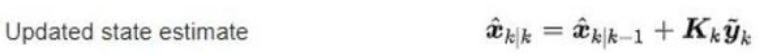

In [1]:
# Define the MAE values
mae_model_prediction = 1.09
mae_trial_1 = 0.87
mae_trial_2 = 0.64
mae_trial_3 = 0.55
mae_trial_4 = 0.64

# Print the MAE values
print(f"Prediction summary for Batch NCDCA0359")
print(f"MAE for Model Prediction: {mae_model_prediction:.2f}")
print(f"MAE for Trial 1  {mae_trial_1:.2f} - avg K*residual=0")
print(f"MAE for Trial 2  {mae_trial_2:.2f} - Avg of MAE between corrected and model predctions before 12h")
print(f"MAE for Trial 3  {mae_trial_3:.2f} - Last absolute error between corrected and model predctions before 12h")
print(f"MAE for Trial 4  {mae_trial_4:.2f} - avg K* residual between last corrected state and current predicted state")


Prediction summary for Batch NCDCA0359
MAE for Model Prediction: 1.09
MAE for Trial 1  0.87 - avg K*residual=0
MAE for Trial 2  0.64 - Avg of MAE between corrected and model predctions before 12h
MAE for Trial 3  0.55 - Last absolute error between corrected and model predctions before 12h
MAE for Trial 4  0.64 - avg K* residual between last corrected state and current predicted state


Feedback for next step: 
1. Calculate for all batches. Draw a distribution with the %drop of MAE on the x-axis. (prioritize tring for Trial 3, but can do for all 4 cases).
2. CASE 2: Objetive: using process parameters to predict the Kalman gain at each time point. (build a hybird model - so we don't actually need a Raman measurements for correction. (find correlation: interpolate Raman measurement (so more points) >> find Kalman gain at each time points for trianing the model.
Other tips: 1. interpolate Raman data st every time point. 2. collaborate with Dr.Amine for the manuscript.